In [1]:
%load_ext Cython

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import time

from tqdm import tqdm
from scipy.special import erfc
from scipy import stats

from cycler import cycler
import boost_histogram as bh

import warnings
warnings.filterwarnings('ignore')

from lmfit.models import *
from lmfit import Model

from maid_interface import maid_2007_Npi as maid

import inspect

In [3]:
df = pd.read_pickle("/Users/tylern/Desktop/show/plots/yeilds.pkl")

w_bins = pd.unique(df.w)
q2_bins = pd.unique(df.q2)
cos_t_bins = pd.unique(df.cos_t)

for b in range(10):
    df[f'acc_{b}'] = df[f'data_{b}'] * (df[f'thrown_{b}']/df[f'mc_rec_{b}'])
df = df[['w', 'q2', 'cos_t', 'acc_0', 'acc_1', 'acc_2', 'acc_3', 'acc_4', 'acc_5', 'acc_6', 'acc_7', 'acc_8', 'acc_9']]

df.head()

w          q2         cos_t        acc_0        acc_1  \
0  (1.275, 1.3]  (1.8, 2.6]    (0.8, 1.0]  1119.987997  1192.327391   
1  (1.275, 1.3]  (1.8, 2.6]  (-0.8, -0.6]   185.220203   187.105351   
2  (1.275, 1.3]  (1.8, 2.6]    (0.4, 0.6]   586.271419   524.343249   
3  (1.275, 1.3]  (1.8, 2.6]  (-0.6, -0.4]   211.338090   224.272272   
4  (1.275, 1.3]  (1.8, 2.6]    (0.6, 0.8]   888.073399   900.293974   

         acc_2        acc_3        acc_4        acc_5        acc_6  \
0  1269.368361  1200.744161  1256.080175  1154.181177  1146.095919   
1   302.089790   231.308653   166.989420   150.122453   183.478748   
2   679.231542   858.322894   860.947063   821.262872   845.698715   
3   305.774234   222.682130   270.153760   254.540486   271.580616   
4   883.394211  1174.832944  1008.505879  1031.031657  1115.880090   

         acc_7        acc_8        acc_9  
0  1136.414075  1055.166799  1132.886995  
1   287.245143   188.419756   199.202676  
2   686.082988   463.035270   579.039488  
3   362.582362   267.642159   220.195572  
4   999.531609   830.335176   840.285021

In [4]:
def momentum_fn(energy, mass):
    return np.sqrt(energy * energy - mass * mass)


def virtual_photon_energy_fn(target_mass, w, q2):
    return (((w * w + q2) / target_mass) - target_mass) / 2


def costheta_e_fn(beam_energy,target_mass,w,q2):
    electron_mass = 5.109989433549345e-4
    nu = virtual_photon_energy_fn(target_mass, w, q2)
    scattered_energy = ((beam_energy) - (nu))
    beam_momentum = momentum_fn(beam_energy, electron_mass)
    scattered_momentum = momentum_fn(scattered_energy, electron_mass)
    return (beam_energy * scattered_energy - q2 / 2.0 - electron_mass * electron_mass) /(beam_momentum * scattered_momentum)


def virtual_photon_epsilon_fn(beam_energy,target_mass,w,q2):
    theta_e = np.arccos(costheta_e_fn(beam_energy, target_mass, w, q2))
    nu = virtual_photon_energy_fn(target_mass, w, q2)
    return np.power(1 + 2 * (1 + nu * nu / q2) * np.power(np.tan(theta_e / 2), 2), -1)


def virtual_photon_flux_fn(w,q2, beam_energy: float = 4.81726, target_mass: float = 0.93827203):
    alpha = 0.007297352570866302
    epsilon = virtual_photon_epsilon_fn(beam_energy, target_mass, w, q2)
    return alpha / (4 * np.pi * q2) * w / (beam_energy * beam_energy * target_mass * target_mass) * (w * w - target_mass * target_mass) / (1 - epsilon)



In [5]:
def virtual_photon(W: float, Q2: float, beam_energy: float = 4.81726) -> float:
    MASS_E = 0.000511
    target_mass = 0.93827203
    FS_ALPHA = 0.007297352570866302

    one = FS_ALPHA/(4 * np.pi)
    two = W/(beam_energy**2 * target_mass**2 * Q2)
    three = (W**2 - target_mass**2)

    beam_momentum = np.sqrt(beam_energy**2 - MASS_E**2)
    nu = (((W**2 + Q2) / target_mass) - target_mass) / 2  # Photon Energy
    scattered_energy = (beam_energy - nu)
    scattered_momentum = np.sqrt(scattered_energy**2 - MASS_E**2)
    theta = np.arccos((beam_energy * scattered_energy - Q2 / 2.0 - MASS_E**2) /
                      (beam_momentum * scattered_momentum))
    epsilon = 1/(1 + (2 * (1 + ((nu**2) / Q2)) * np.tan(theta / 2)**2))

    four = 1/(1 - epsilon)

    # This makes it look closer? Where am I off?
    flux = one * two * three * four * 10**1

    return flux

In [6]:
def acceptence_corrected(yeilds):
    phi_bins = np.linspace(0, 2 * np.pi, 200)
    acc_corr = dict()
    for ws in w_bins:
        for q2s in q2_bins:
            for cos_ts in cos_t_bins:
                crossSections = []
                phis = []
                for phi in phi_bins:
                    crossSections.append(
                        maid(4.81726, ws.left, q2s.left, cos_ts.left, np.degrees(phi)))
                    phis.append(phi)
                    
                cut = (yeilds.w == ws) & (yeilds.q2 == q2s) & (yeilds.cos_t == cos_ts)
                data = yeilds[cut].copy()
                x = []
                y = []
                for b, phi in enumerate(np.linspace(0,2*np.pi,10)):
                    #print(virtual_photon(ws.left, q2s.left)-virtual_photon_flux_fn(ws.left, q2s.left))
                    x.append(phi)
                    y.append(data[f'acc_{b}'] * virtual_photon_flux_fn(ws.left, q2s.left) )
                    
                plt.scatter(x,y)
                plt.plot(phis,crossSections)
                try:
                    plt.ylim(0, np.max(y)*1.5)
                except ValueError:
                    pass

                
                plt.show()

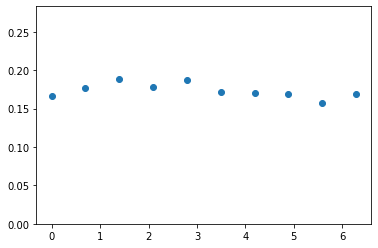

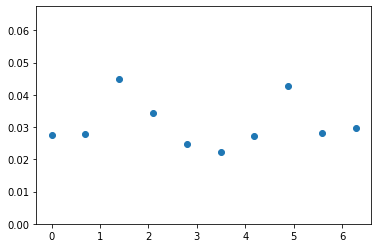

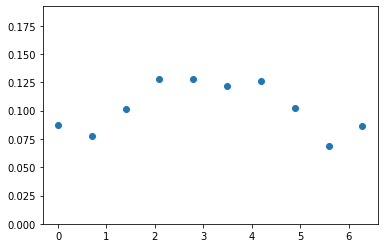

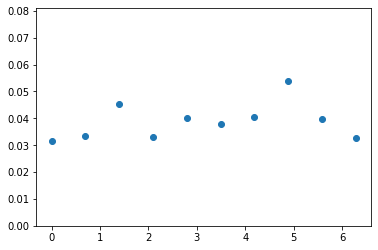

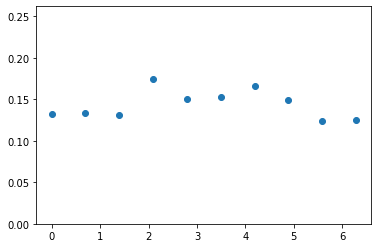

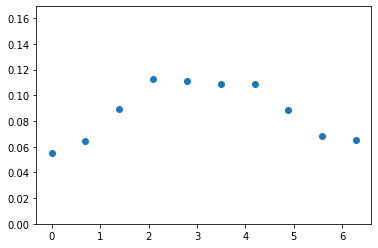

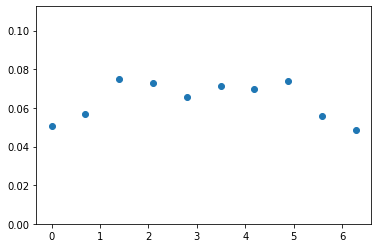

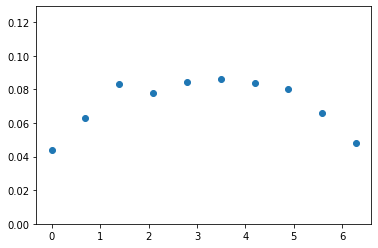

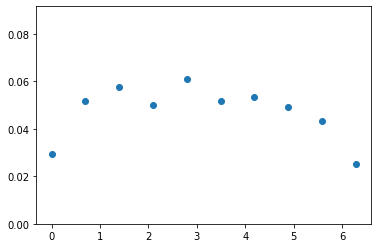

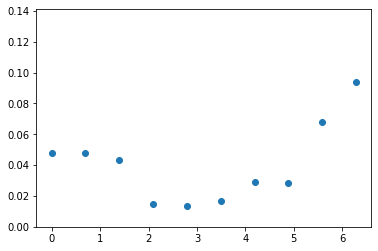

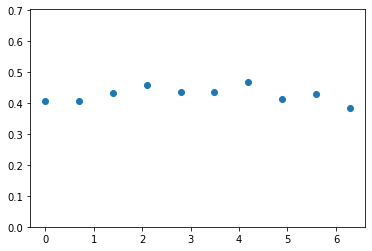

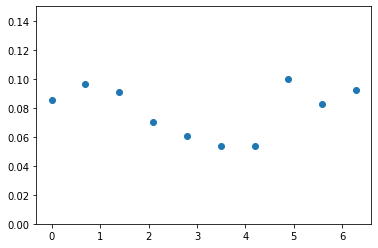

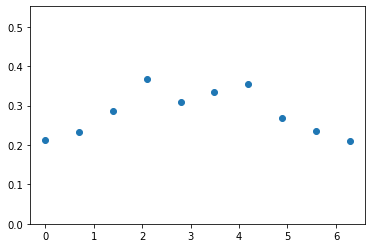

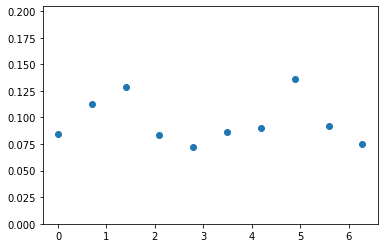

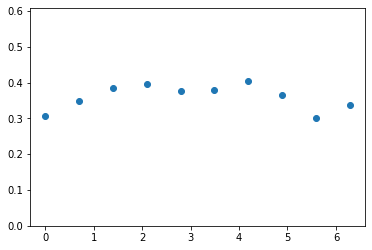

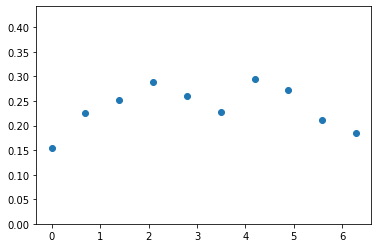

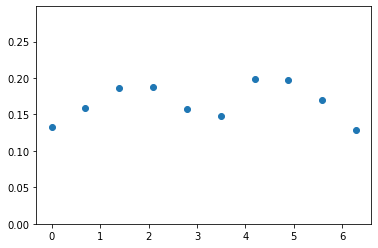

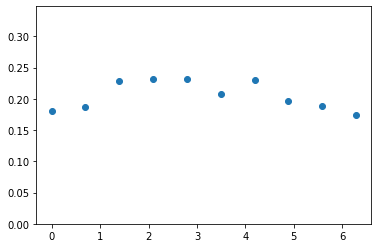

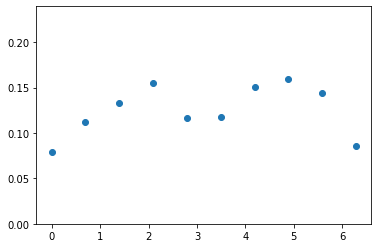

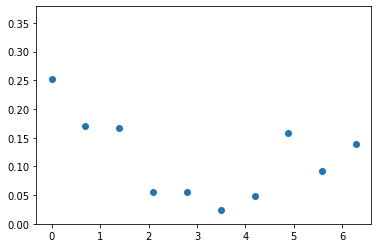

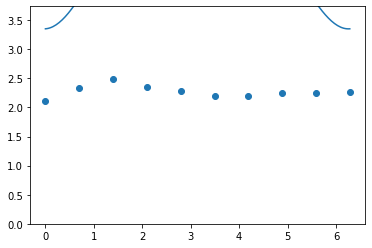

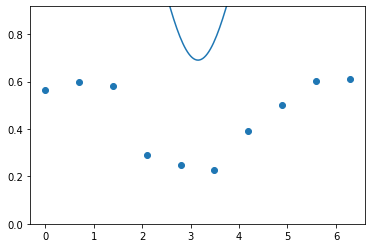

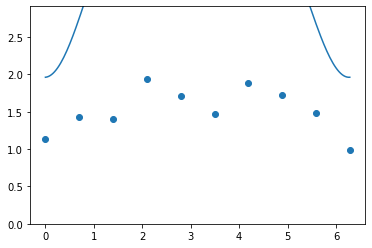

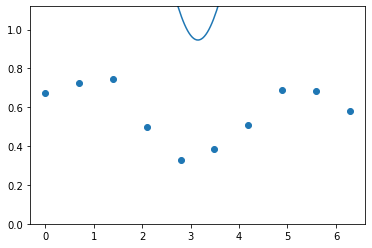

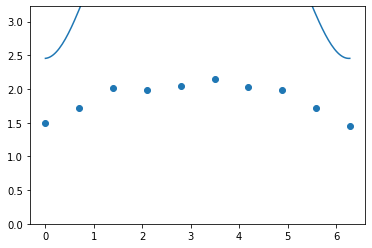

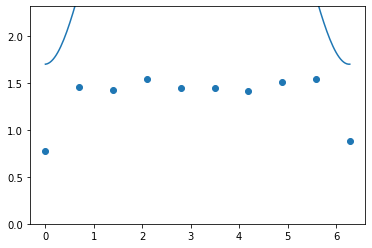

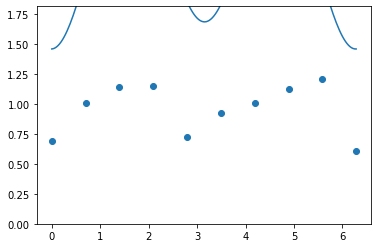

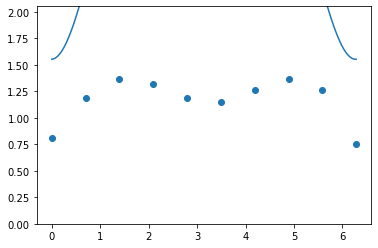

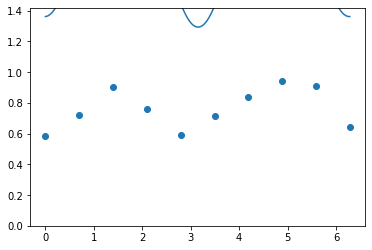

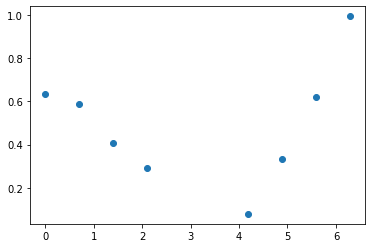

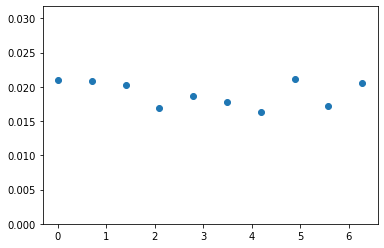

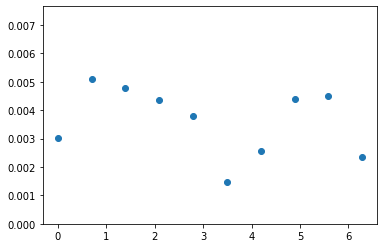

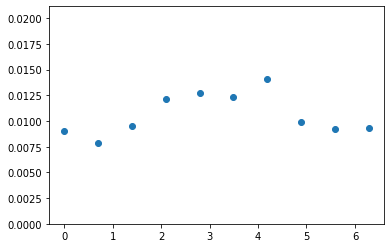

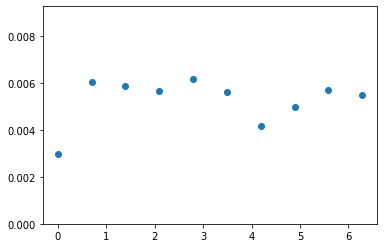

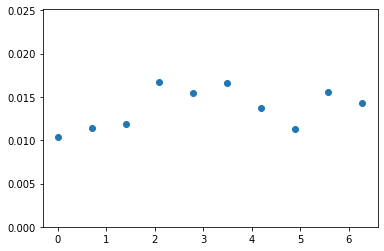

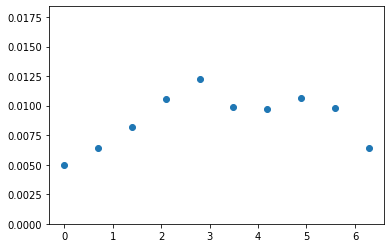

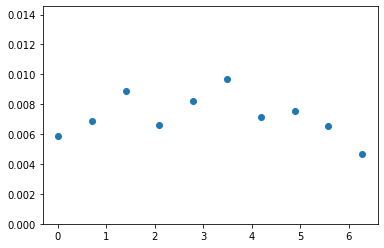

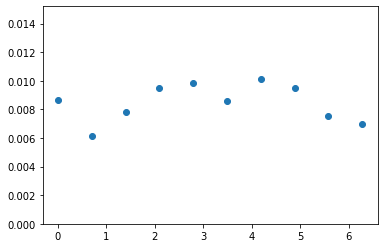

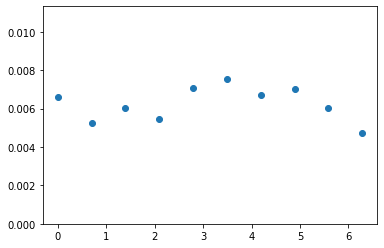

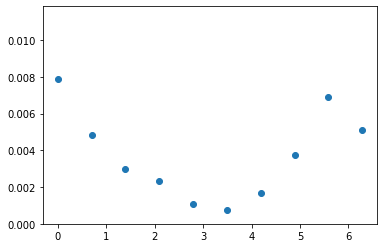

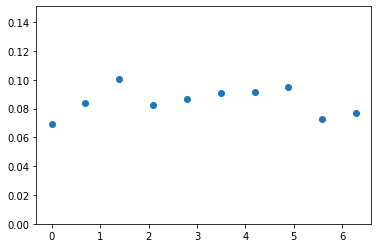

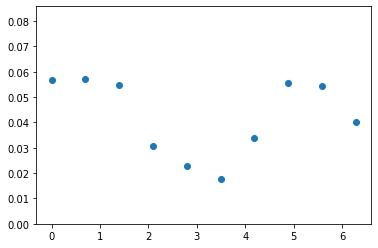

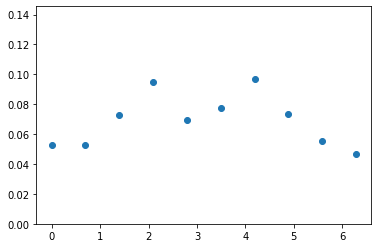

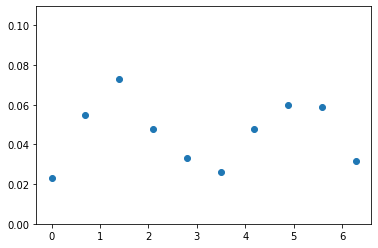

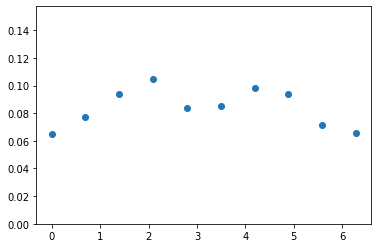

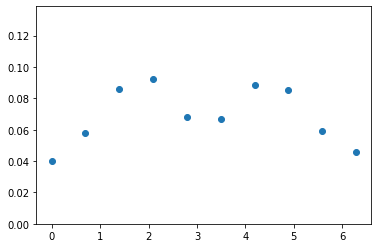

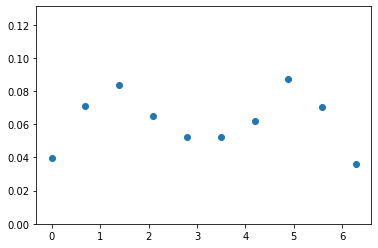

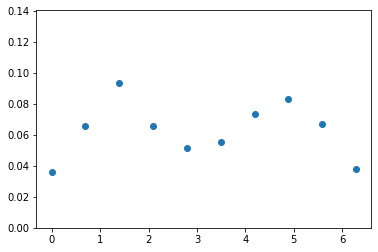

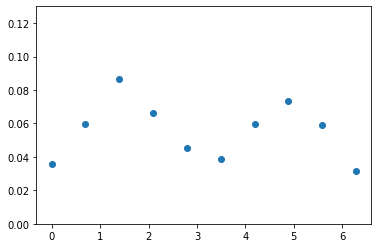

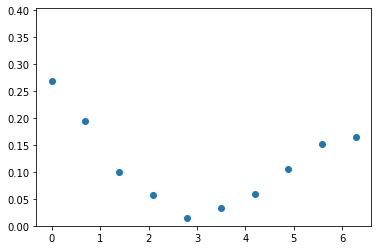

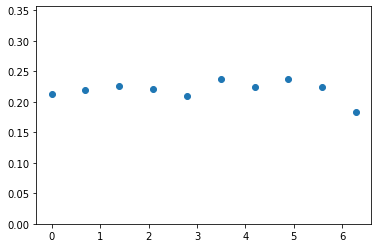

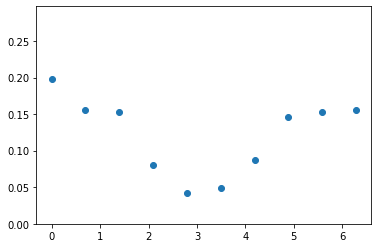

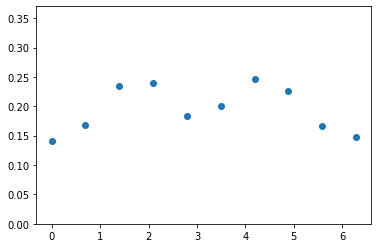

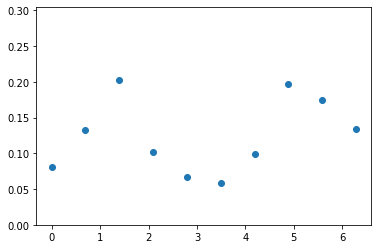

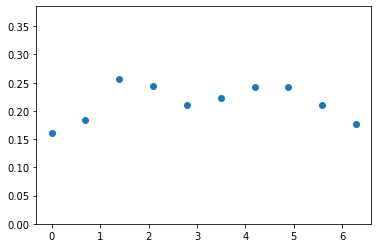

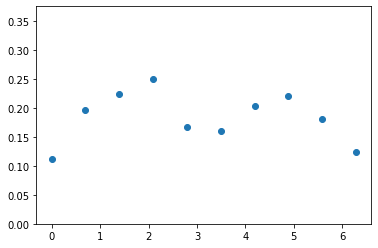

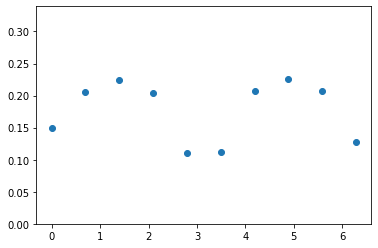

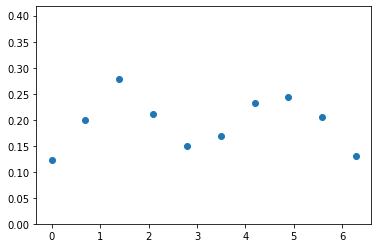

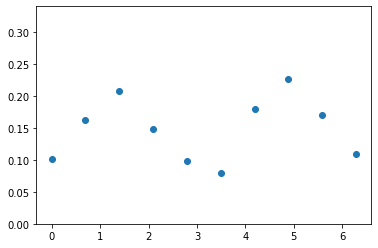

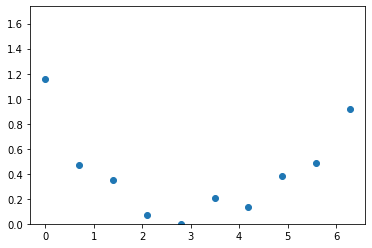

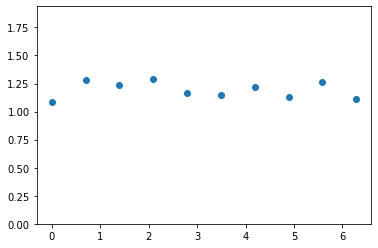

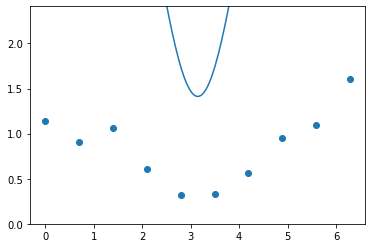

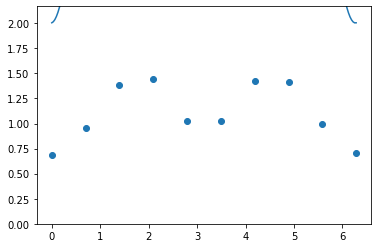

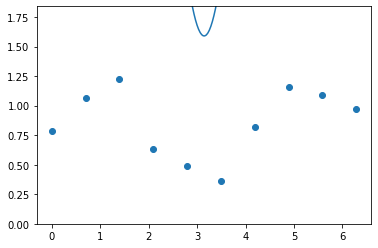

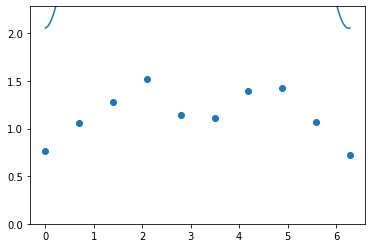

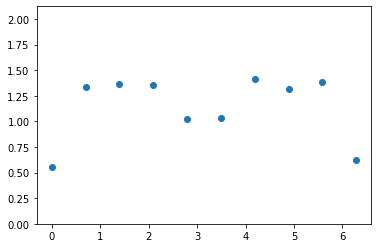

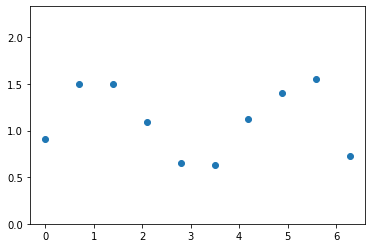

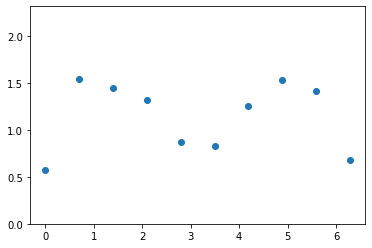

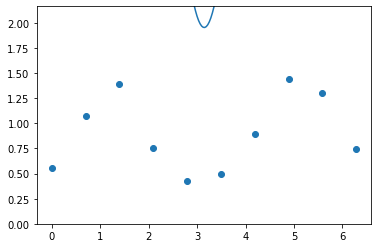

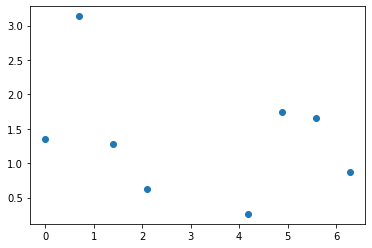

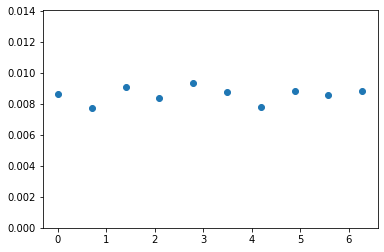

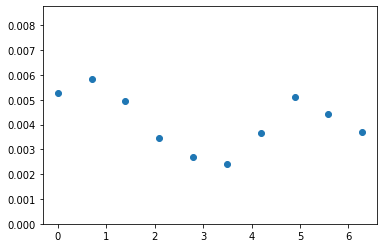

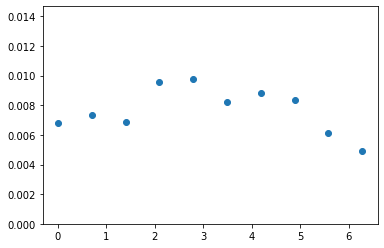

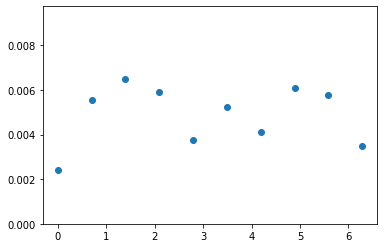

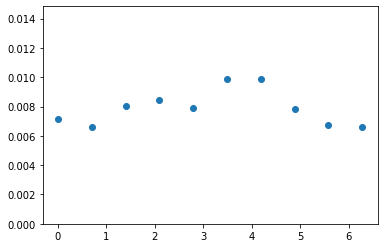

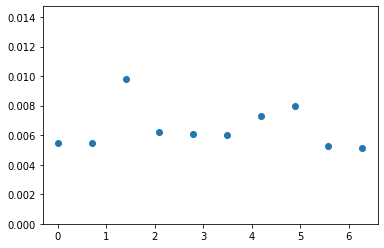

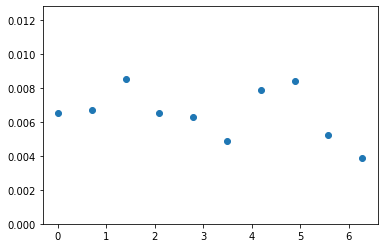

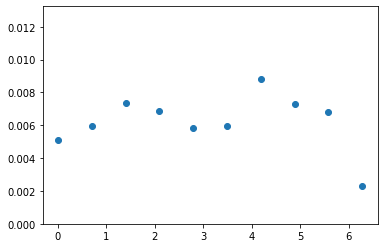

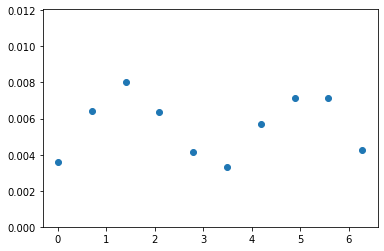

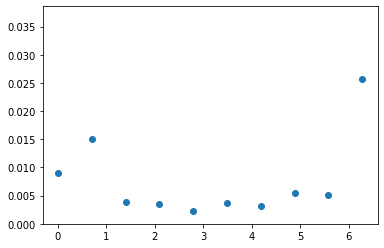

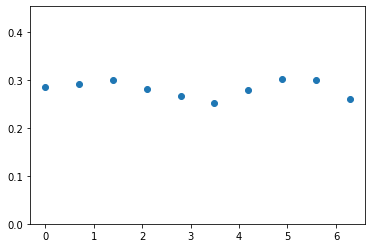

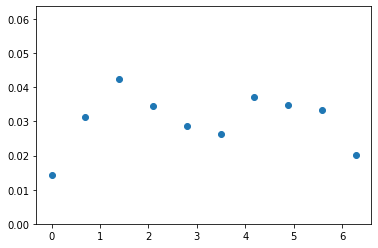

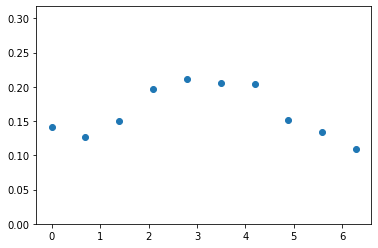

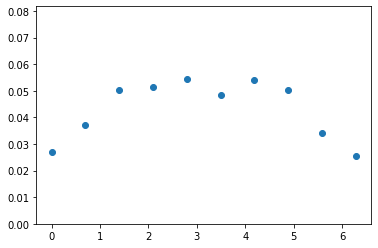

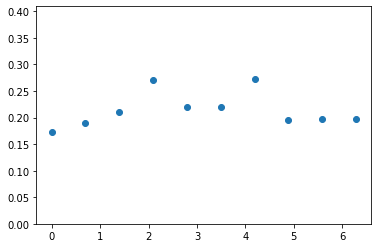

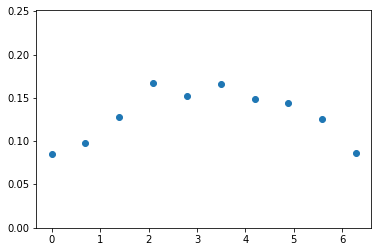

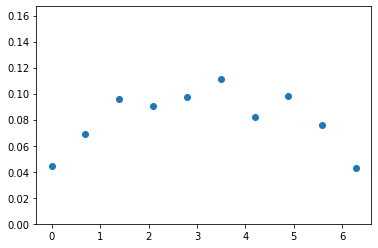

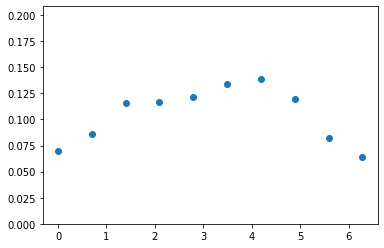

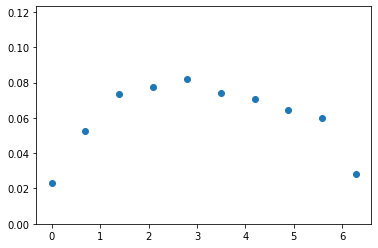

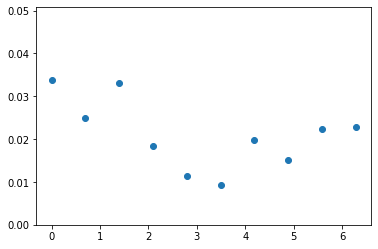

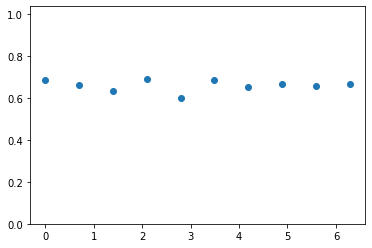

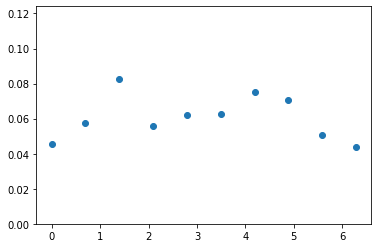

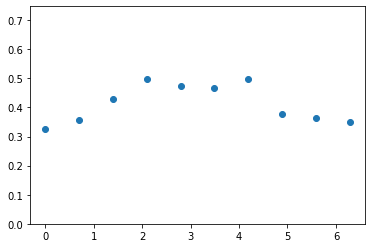

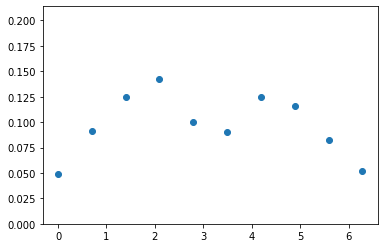

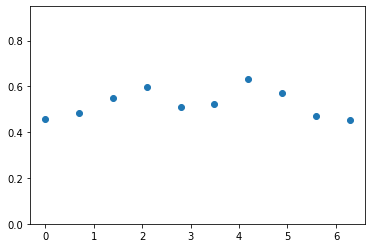

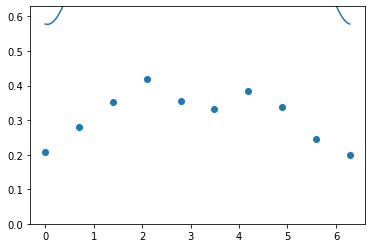

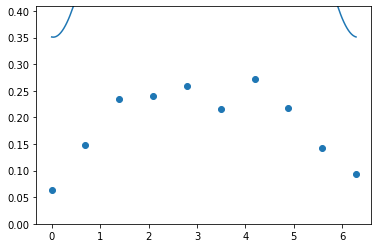

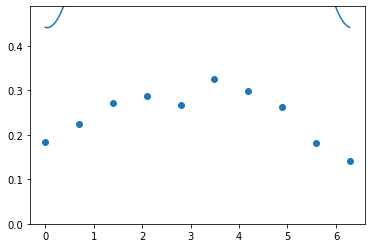

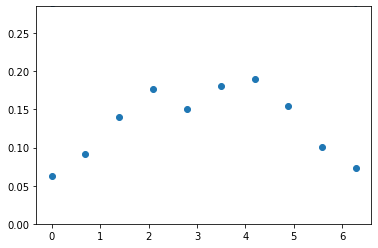

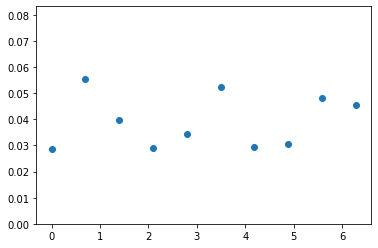

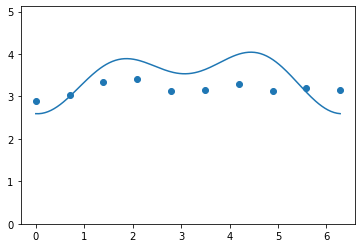

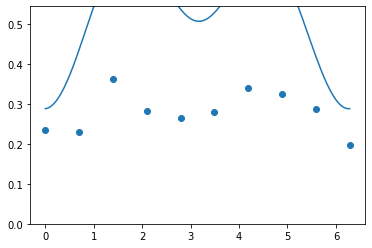

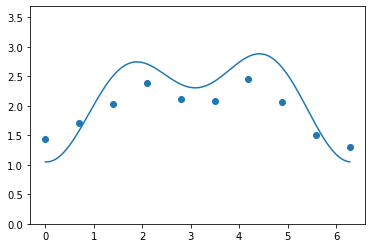

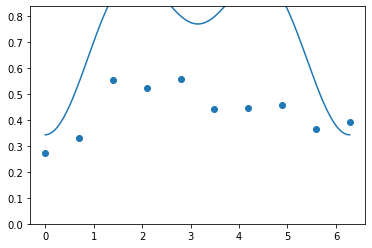

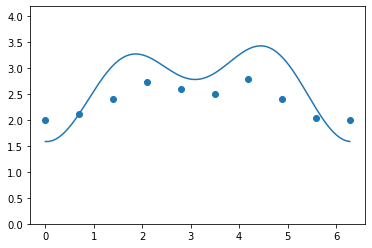

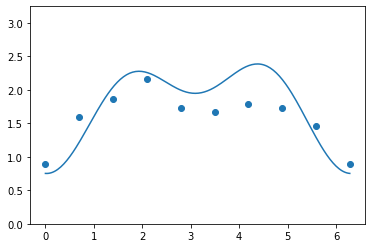

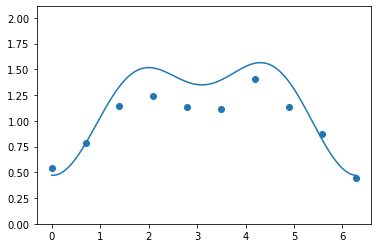

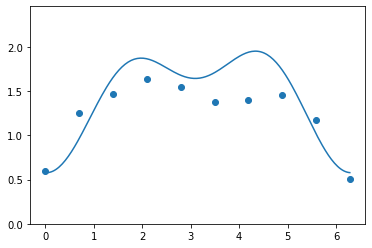

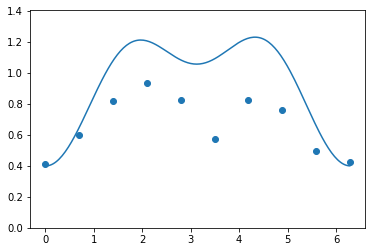

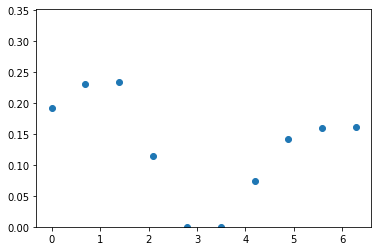

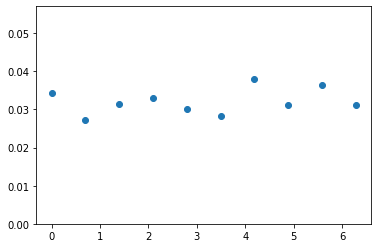

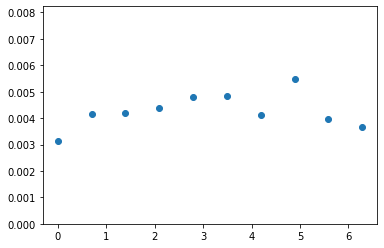

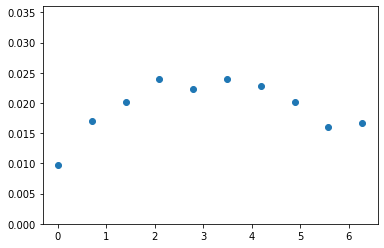

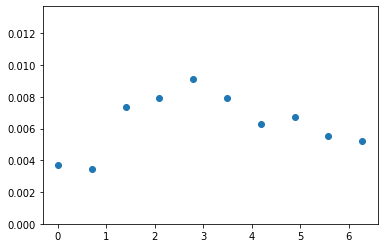

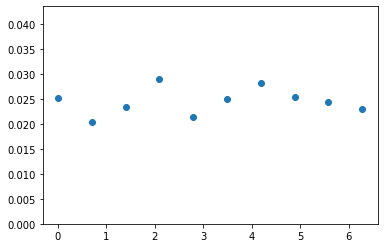

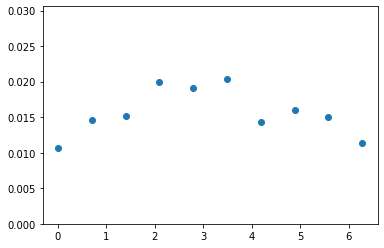

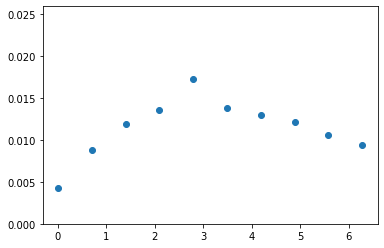

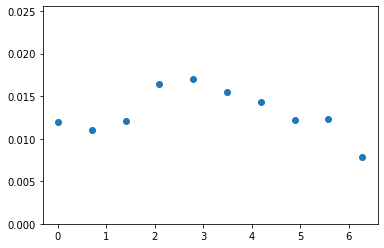

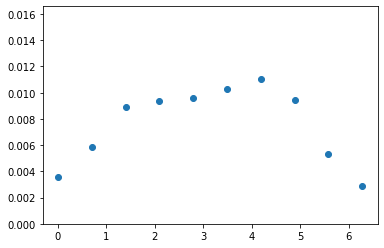

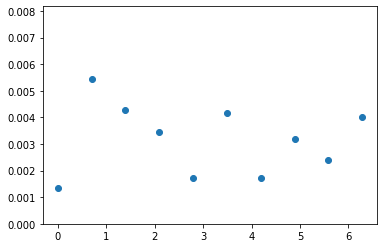

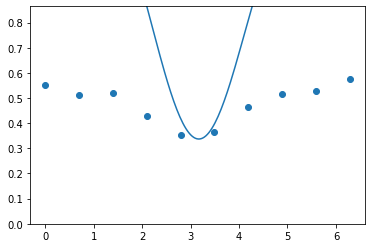

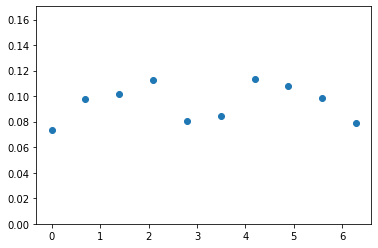

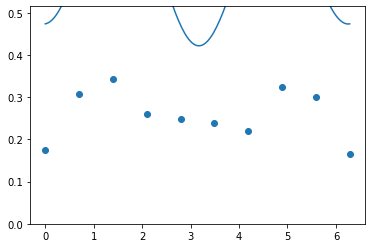

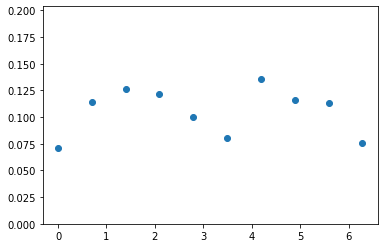

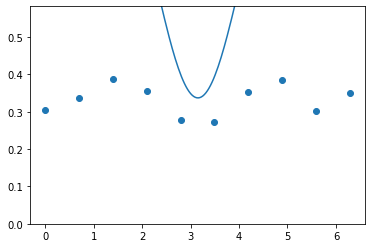

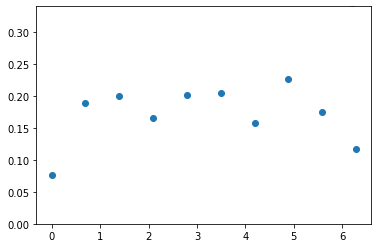

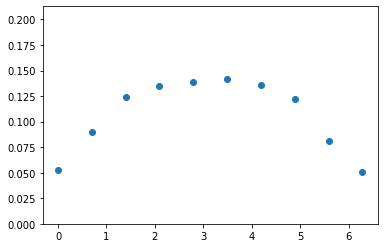

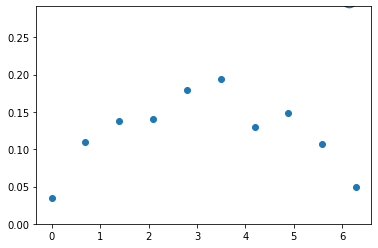

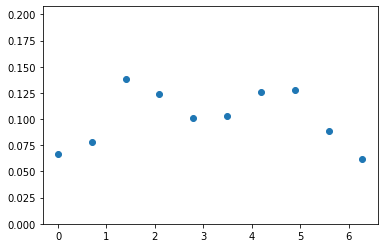

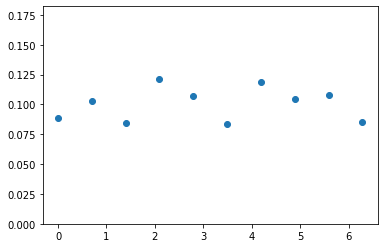

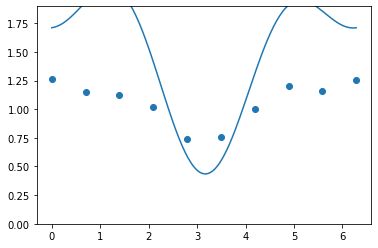

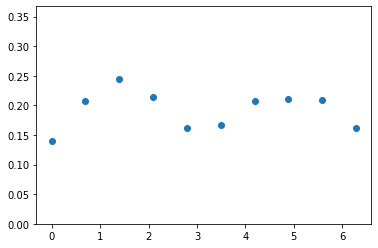

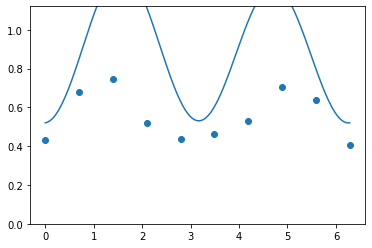

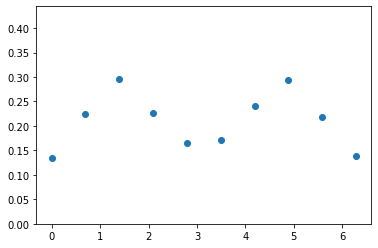

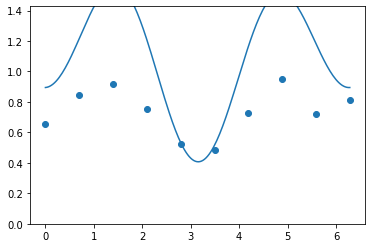

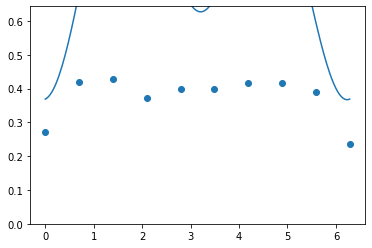

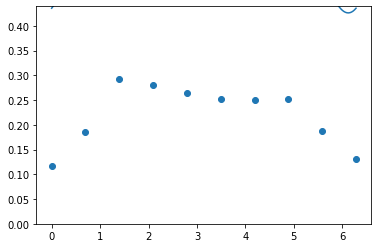

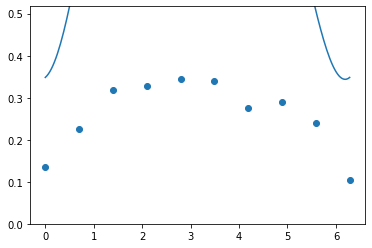

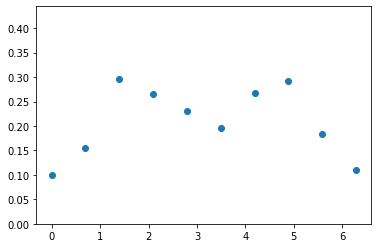

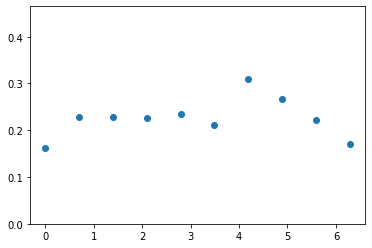

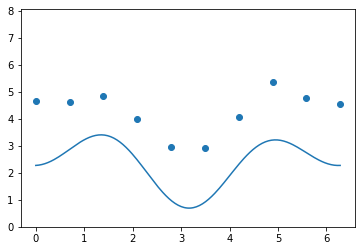

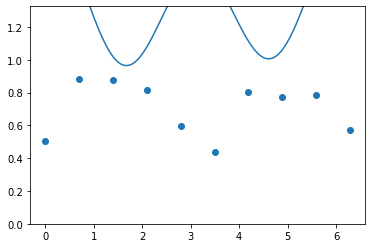

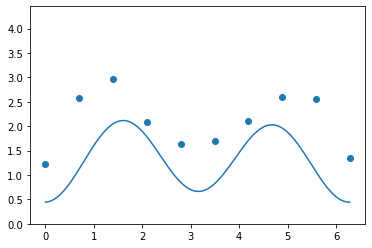

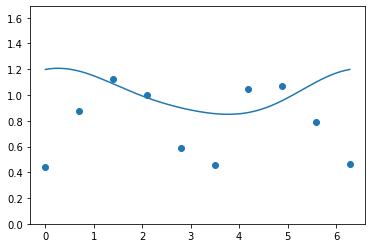

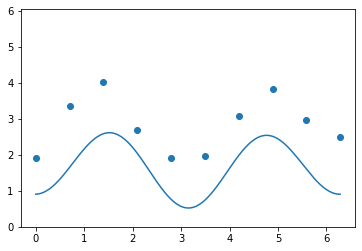

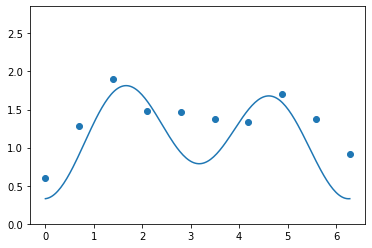

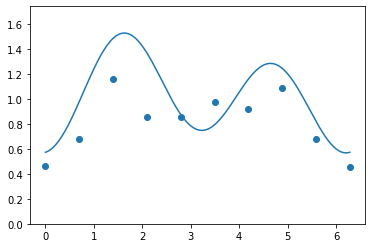

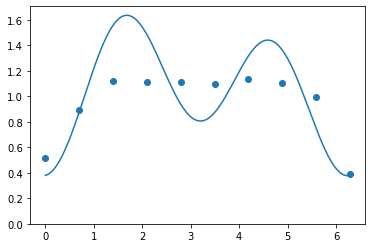

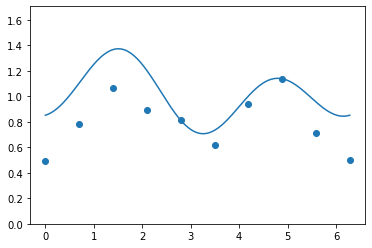

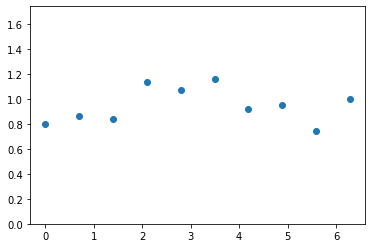

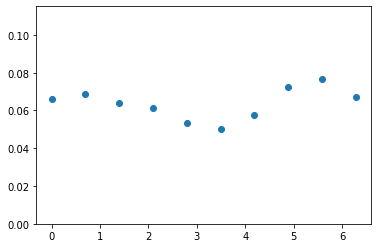

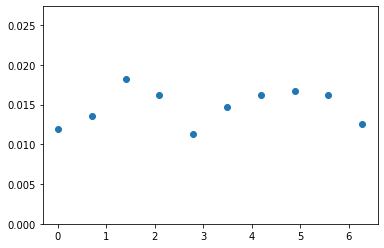

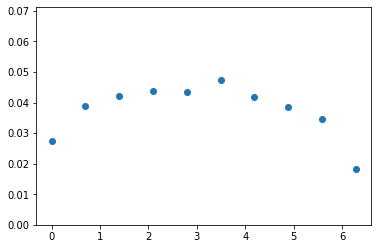

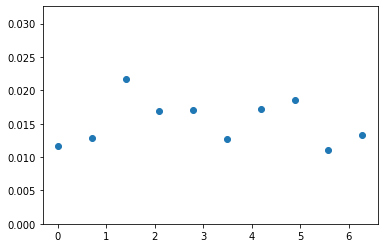

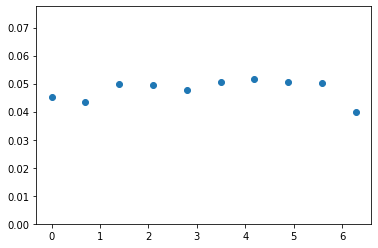

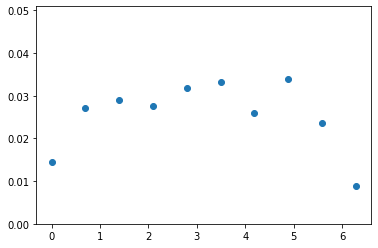

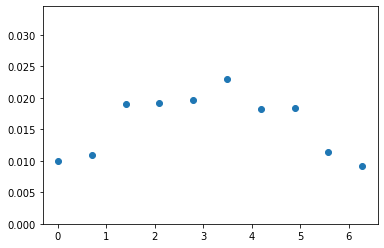

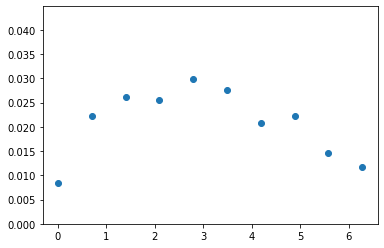

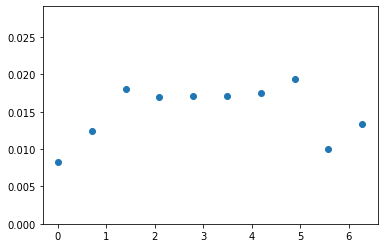

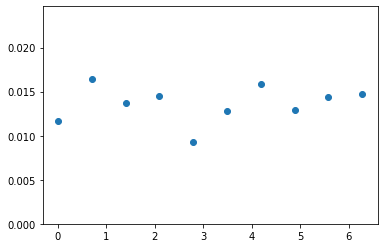

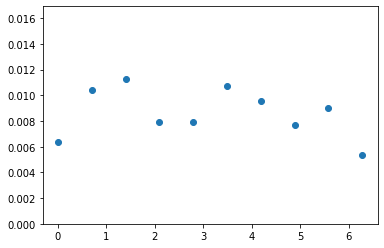

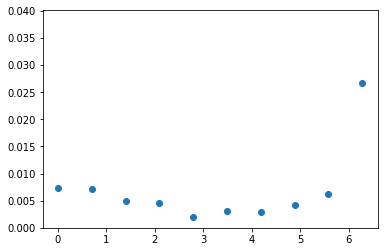

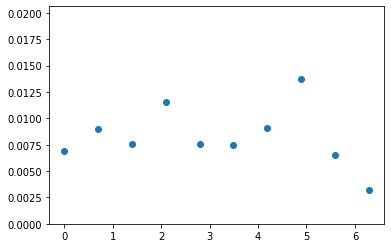

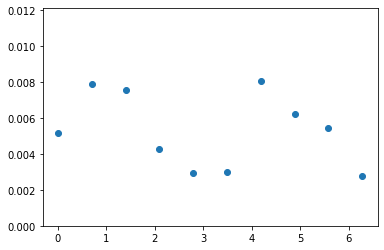

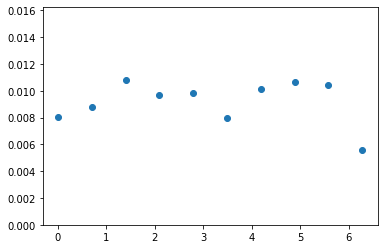

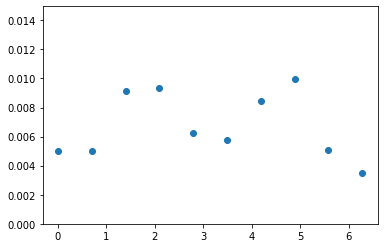

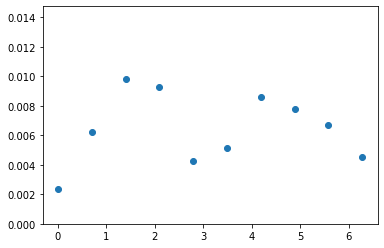

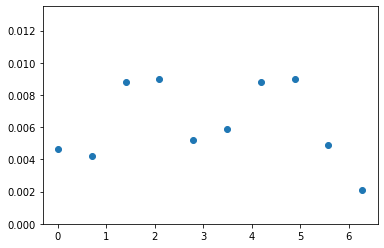

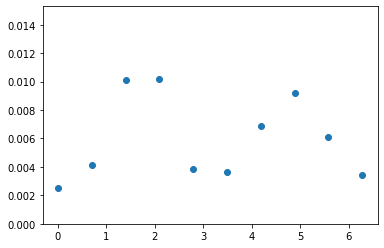

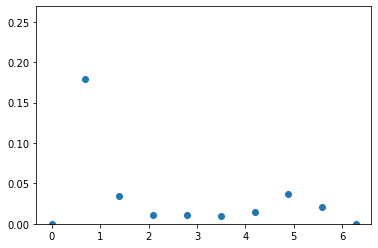

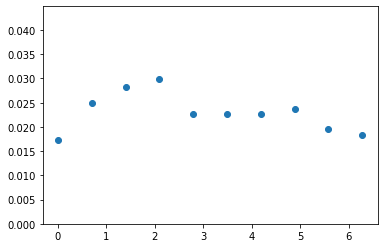

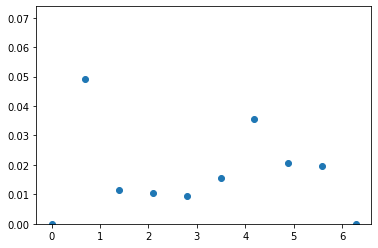

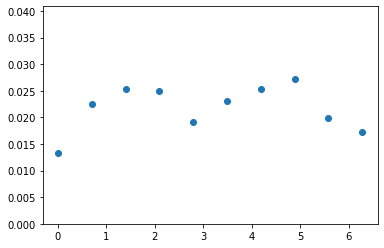

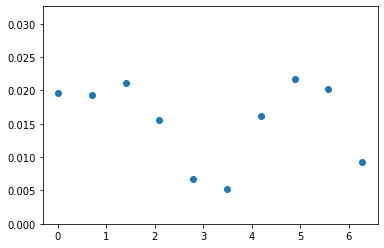

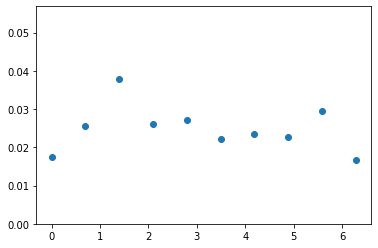

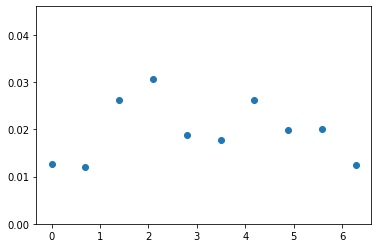

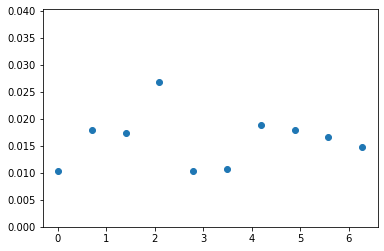

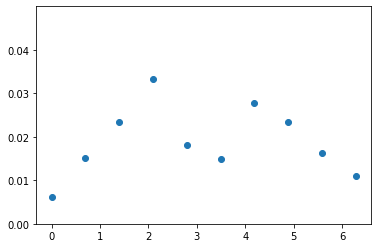

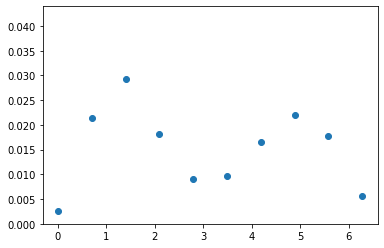

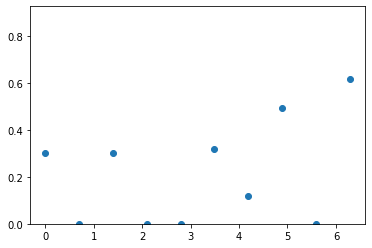

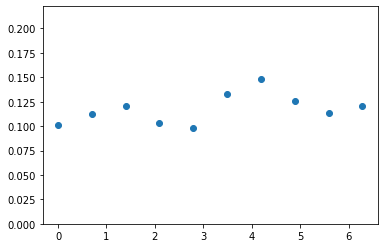

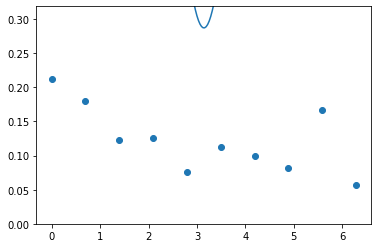

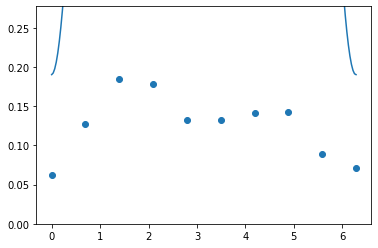

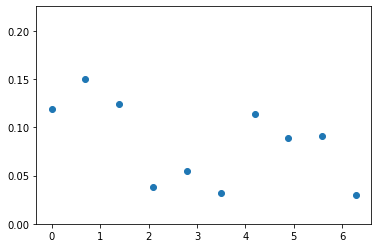

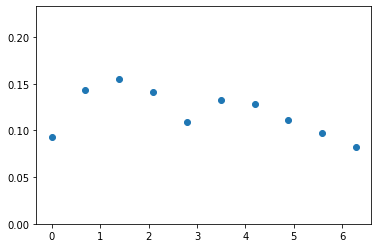

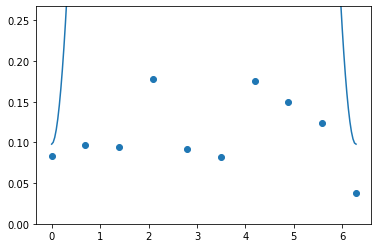

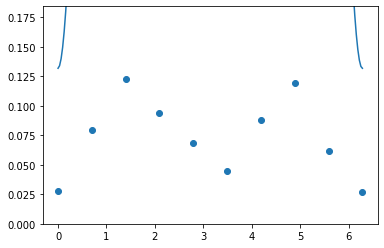

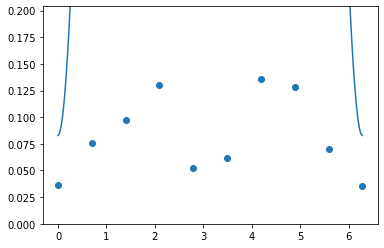

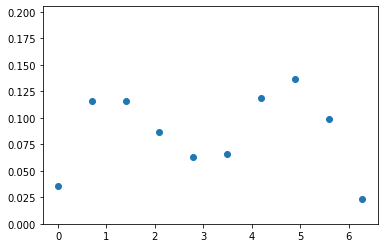

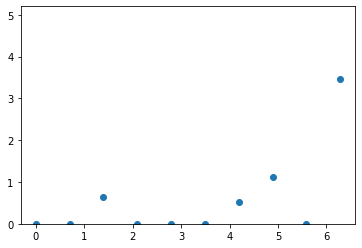

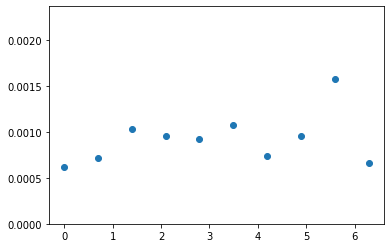

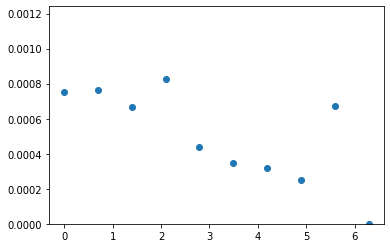

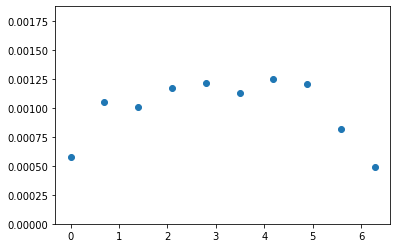

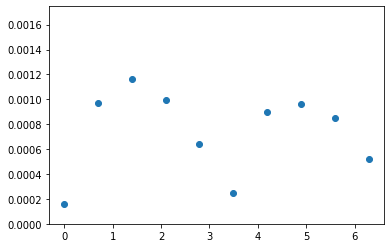

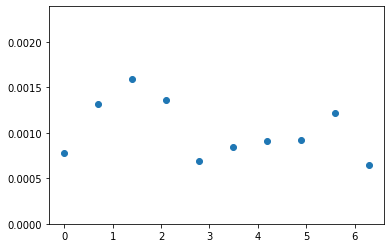

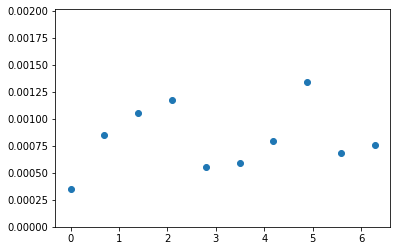

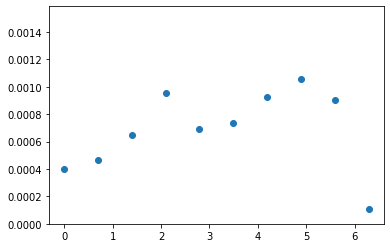

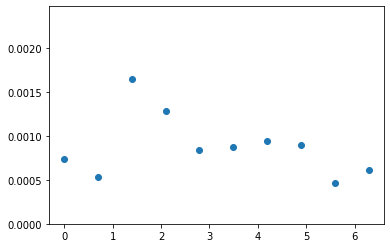

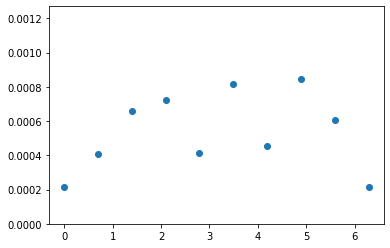

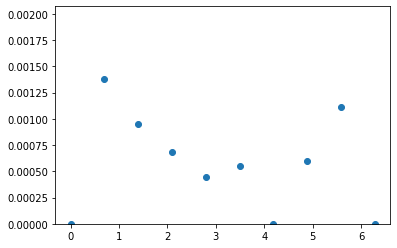

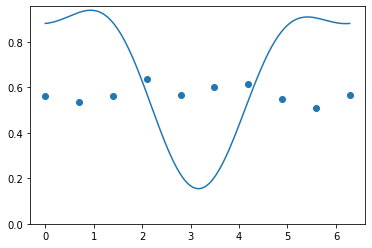

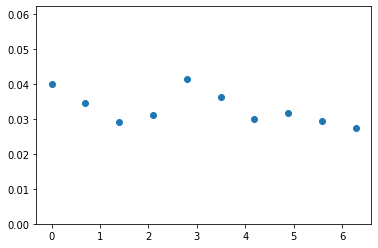

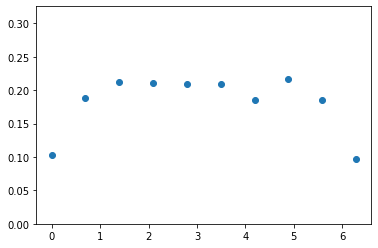

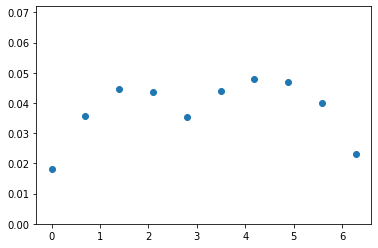

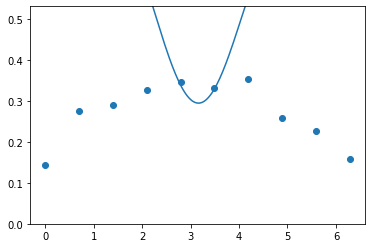

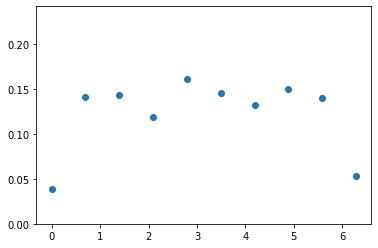

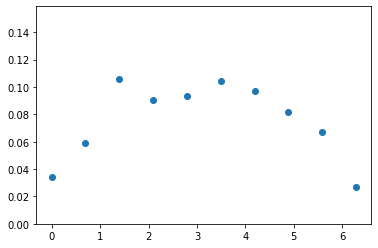

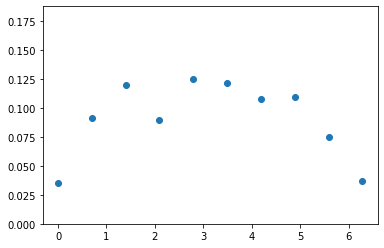

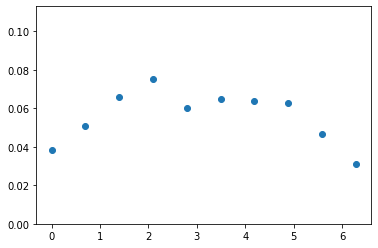

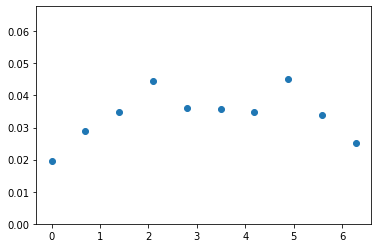

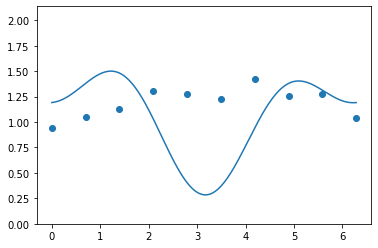

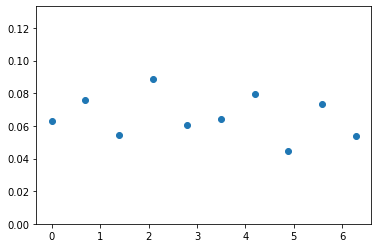

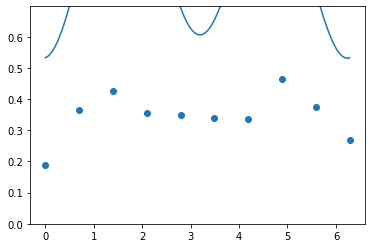

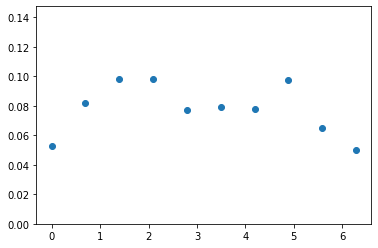

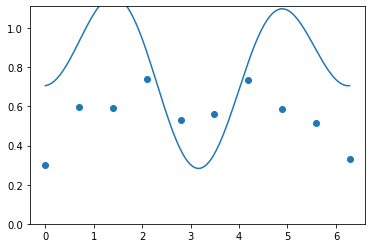

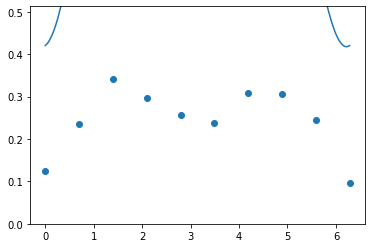

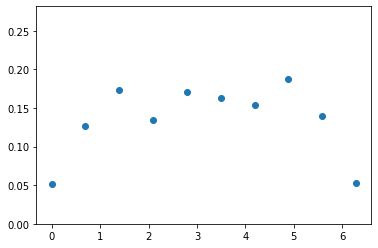

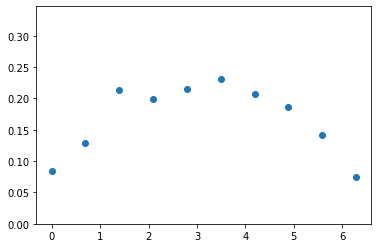

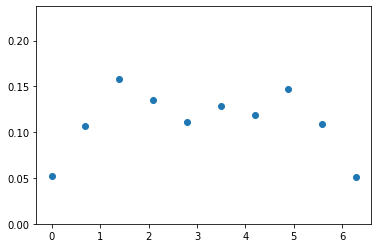

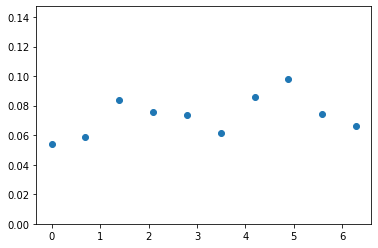

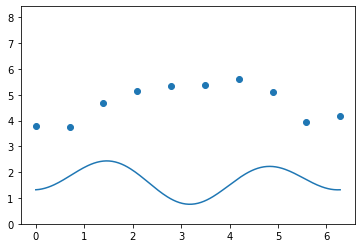

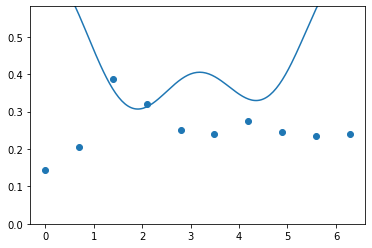

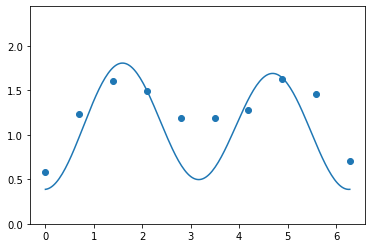

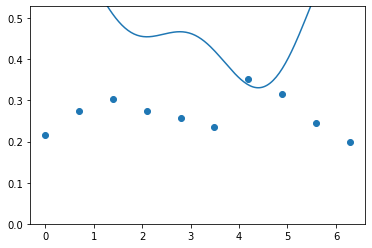

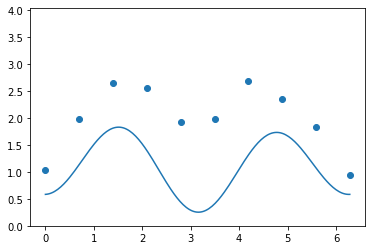

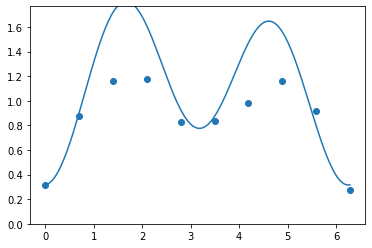

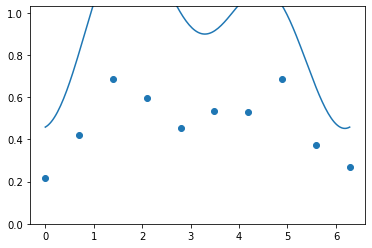

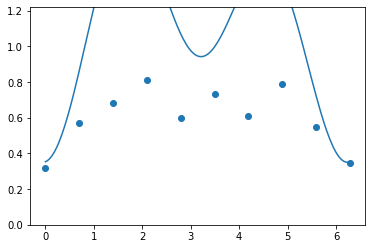

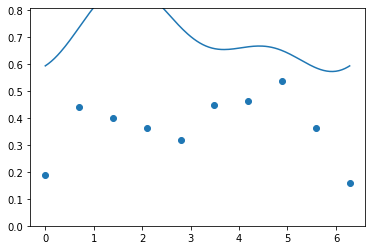

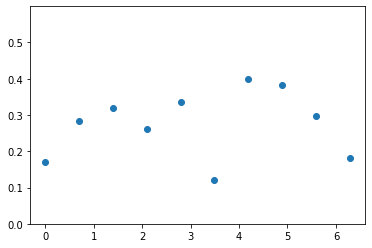

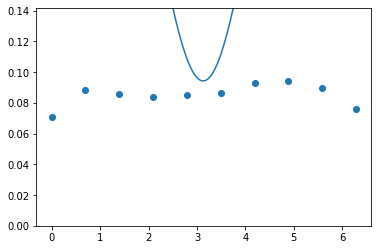

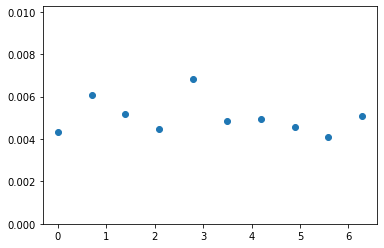

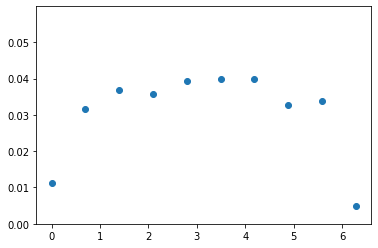

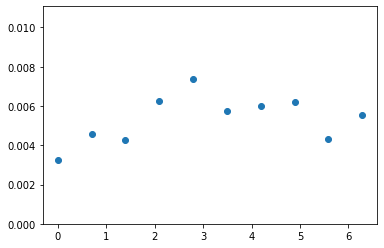

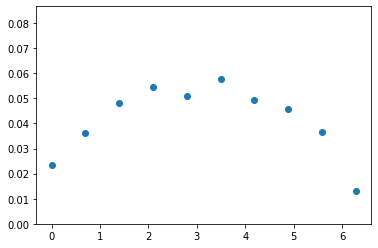

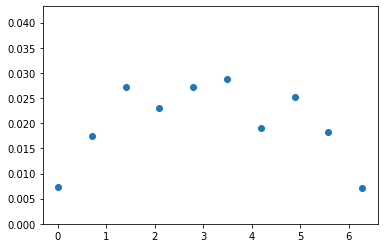

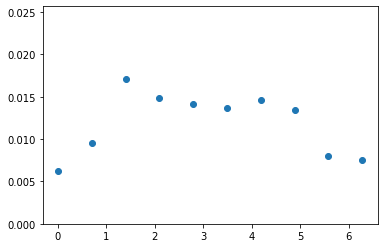

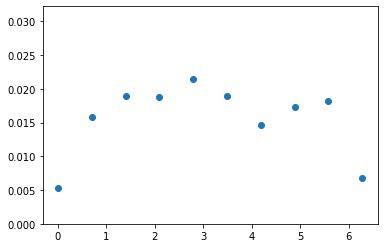

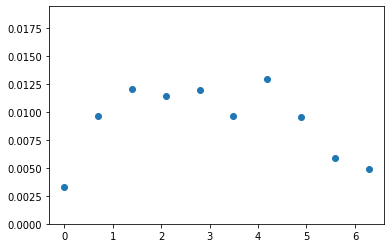

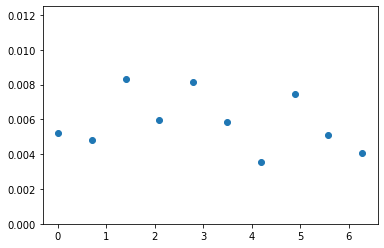

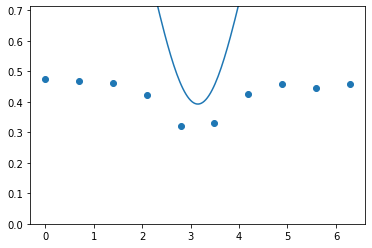

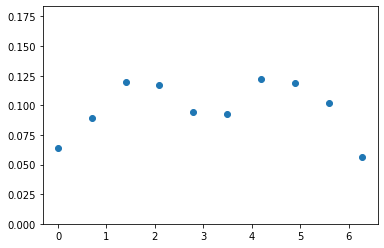

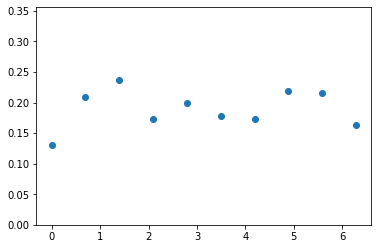

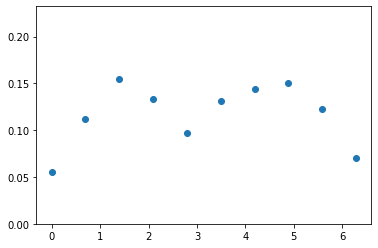

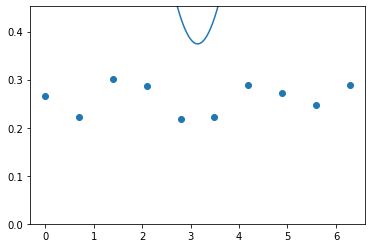

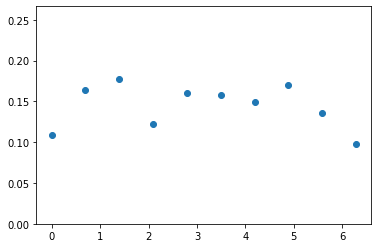

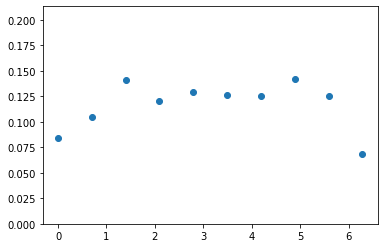

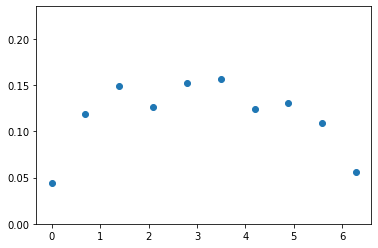

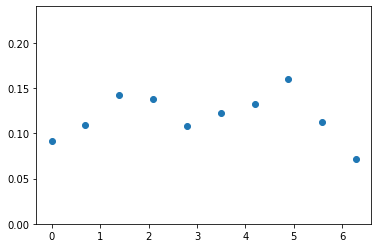

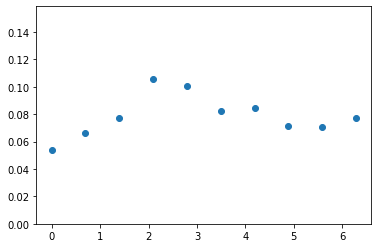

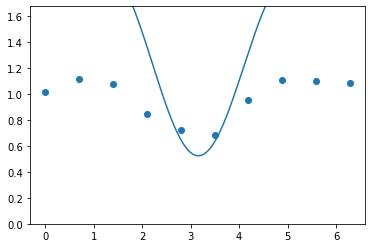

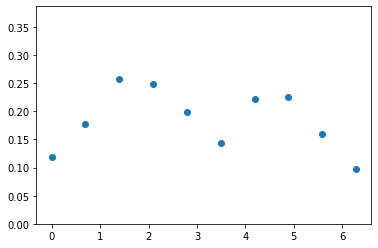

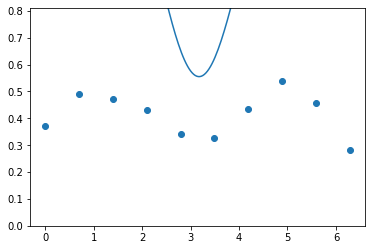

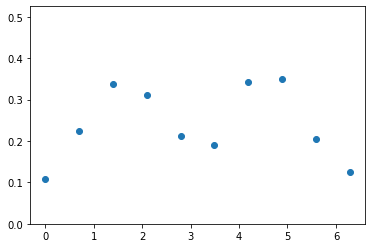

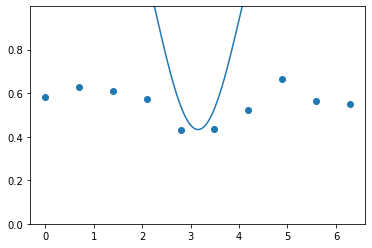

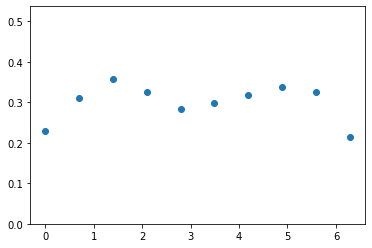

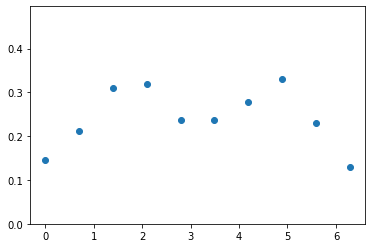

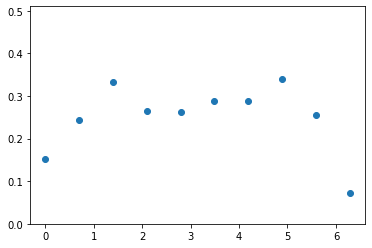

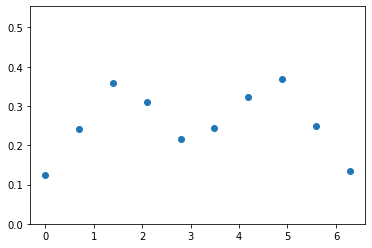

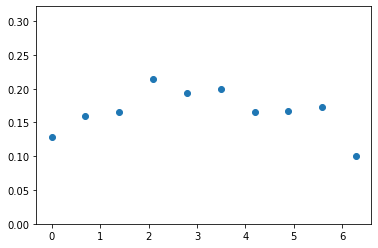

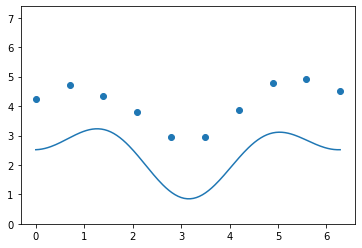

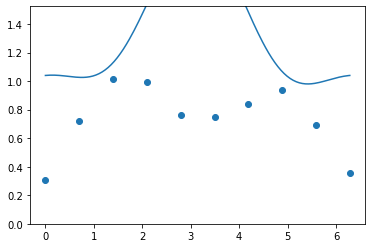

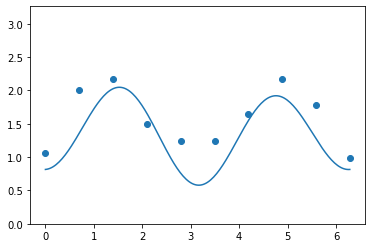

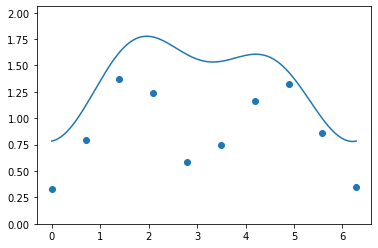

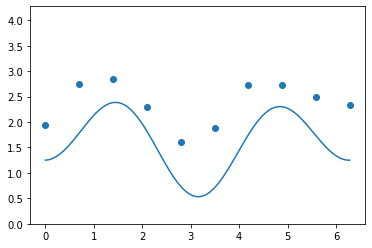

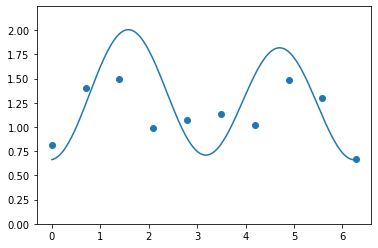

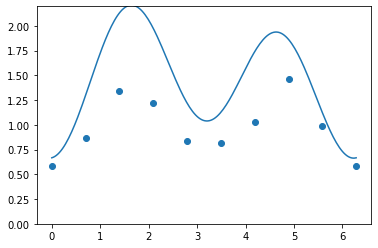

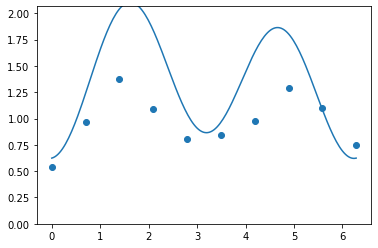

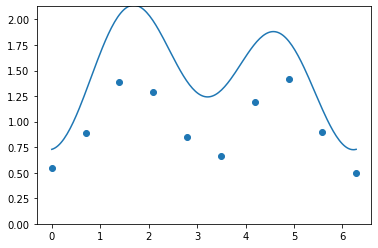

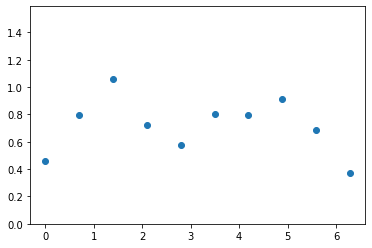

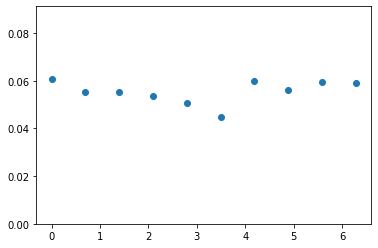

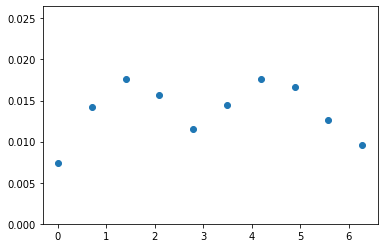

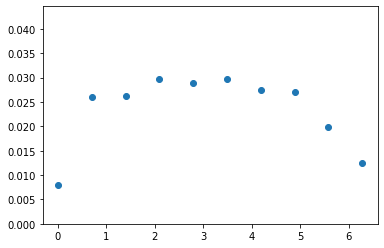

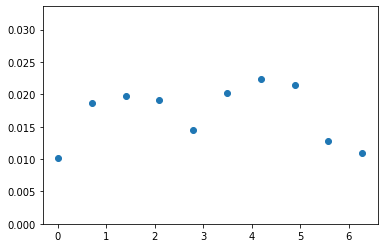

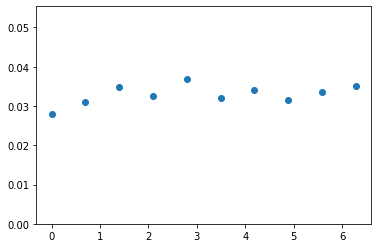

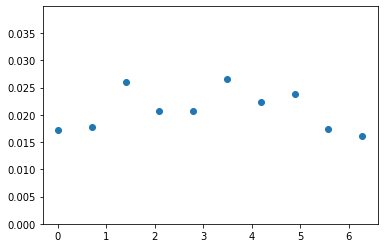

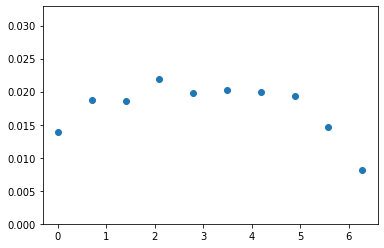

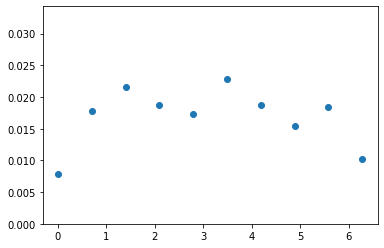

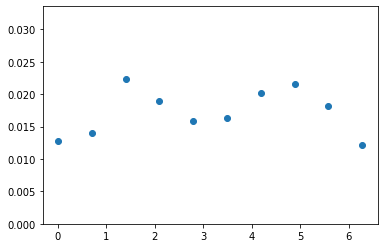

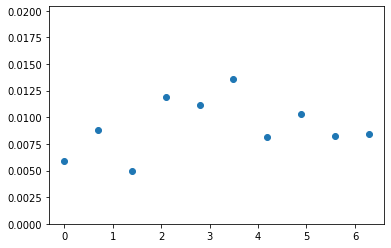

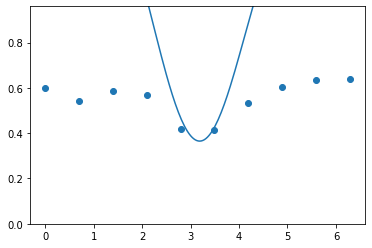

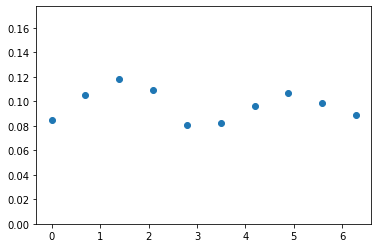

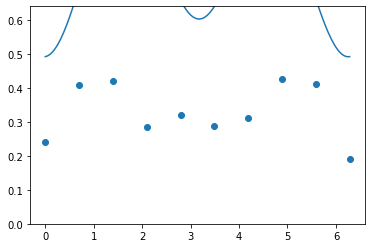

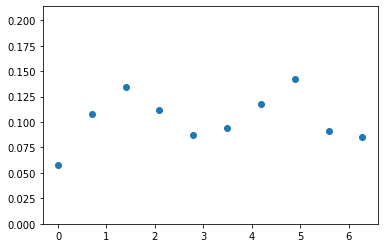

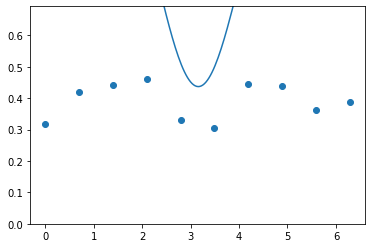

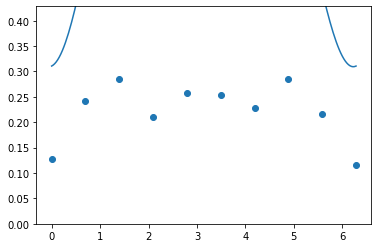

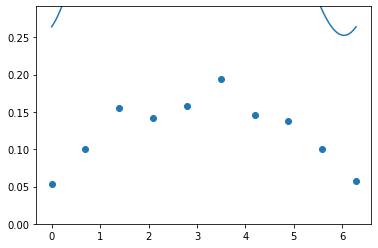

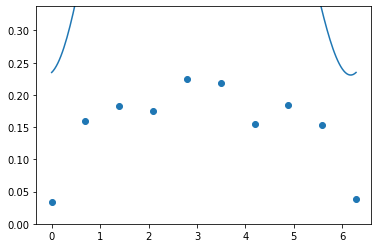

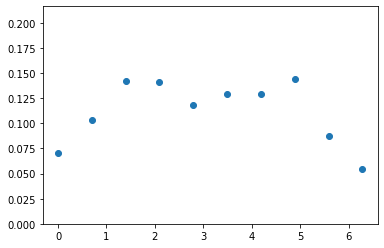

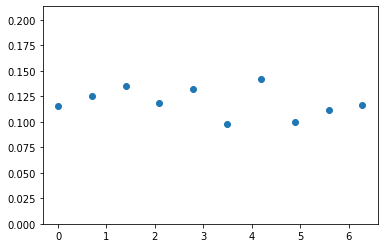

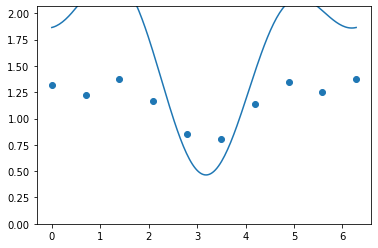

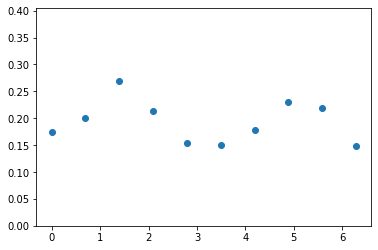

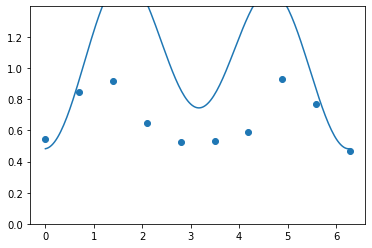

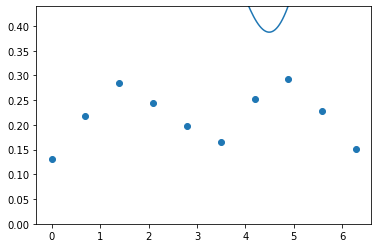

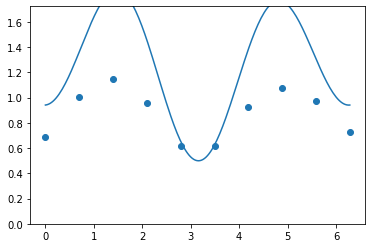

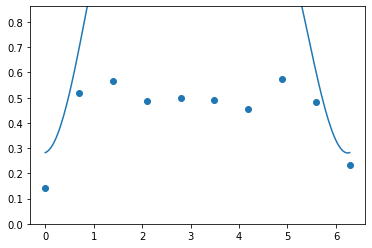

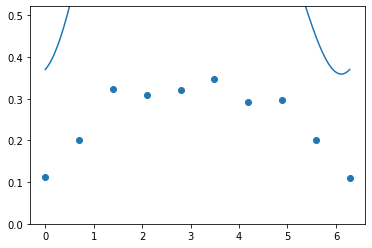

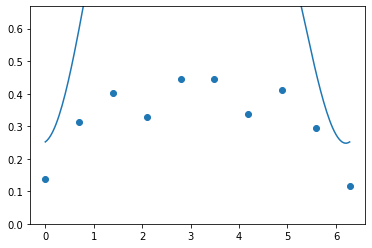

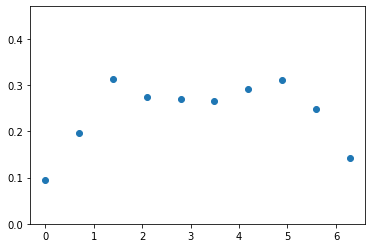

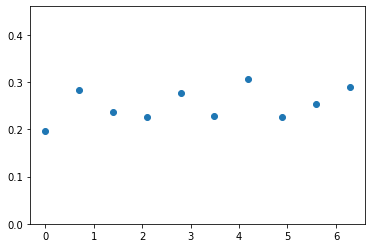

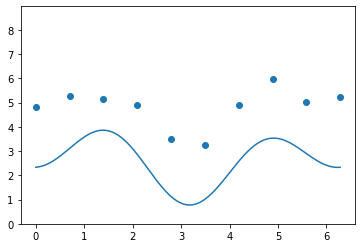

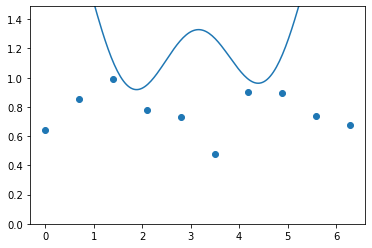

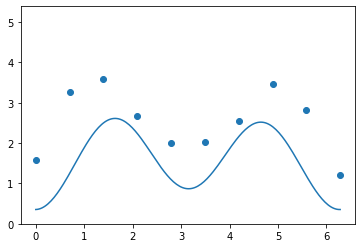

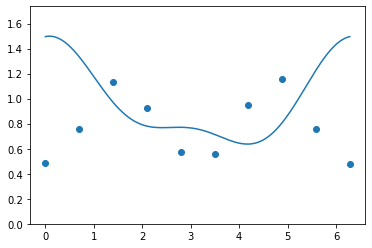

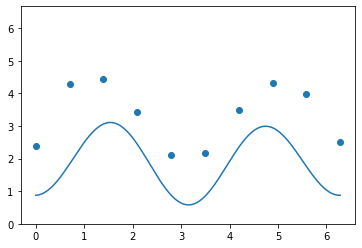

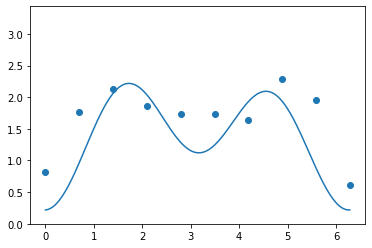

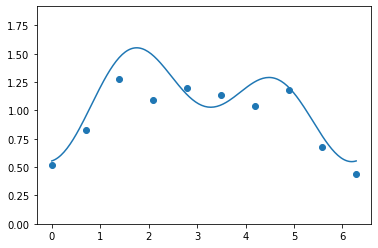

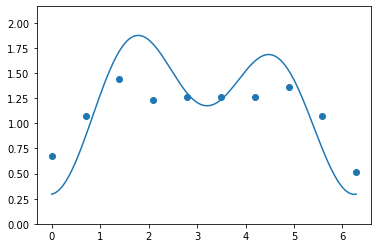

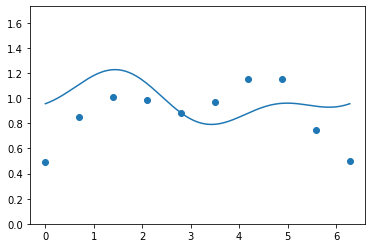

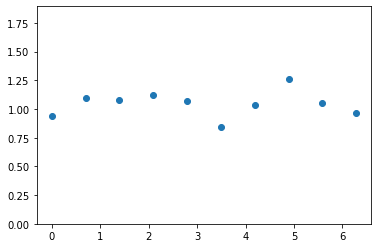

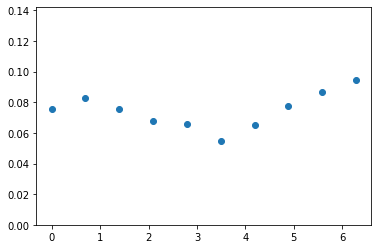

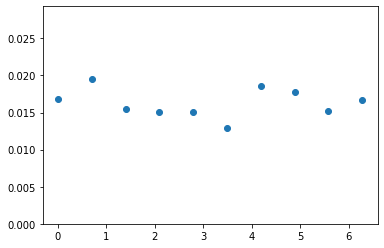

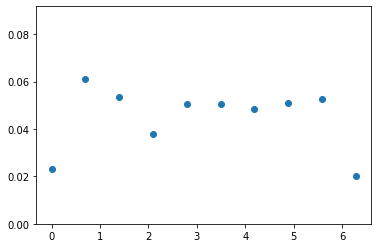

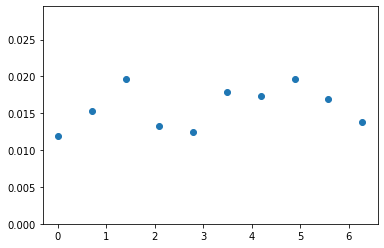

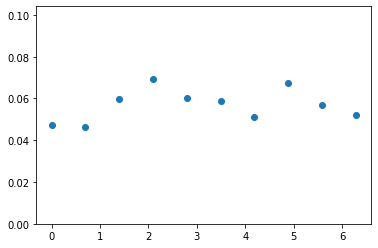

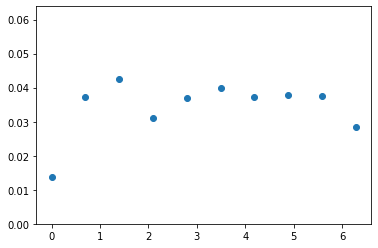

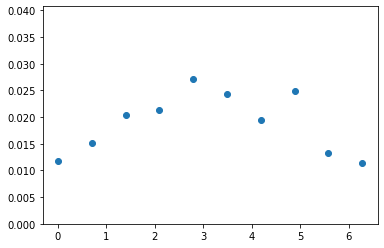

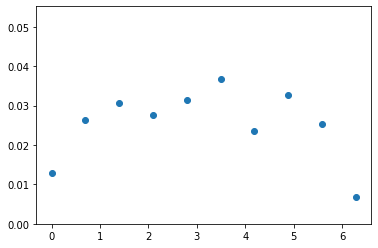

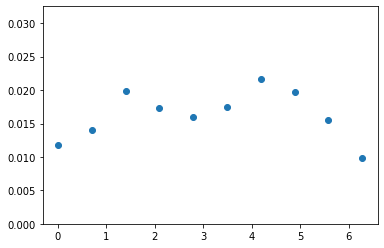

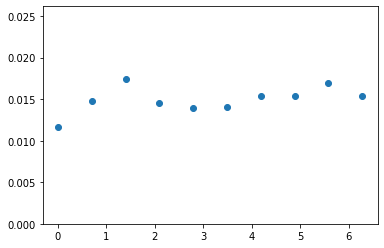

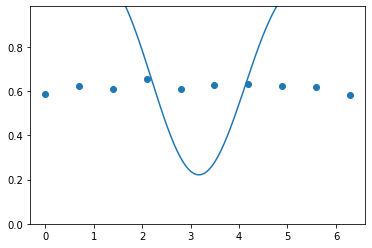

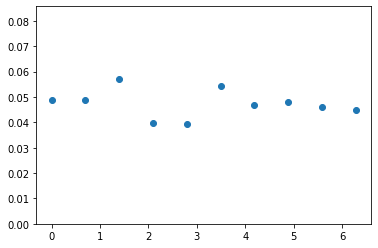

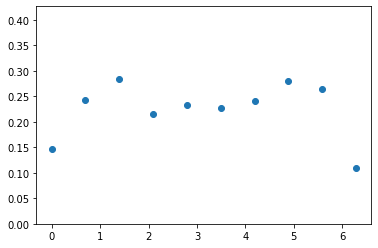

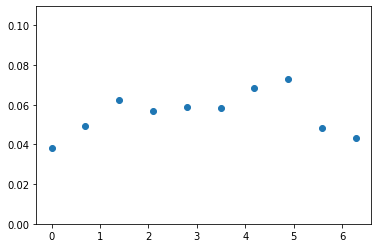

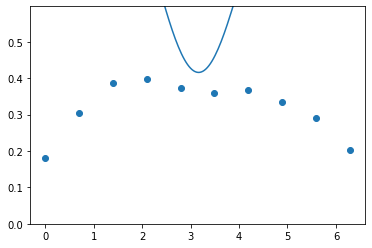

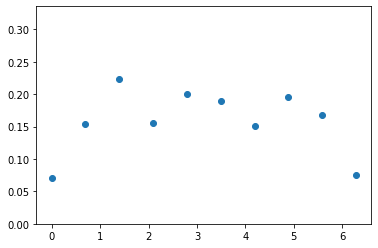

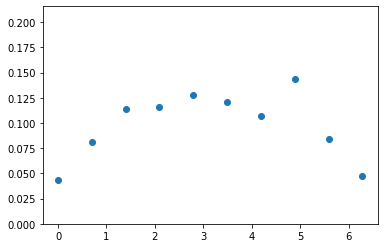

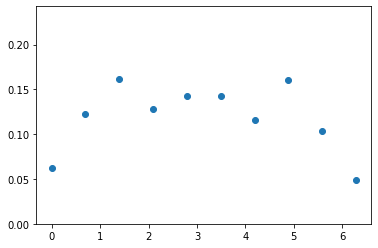

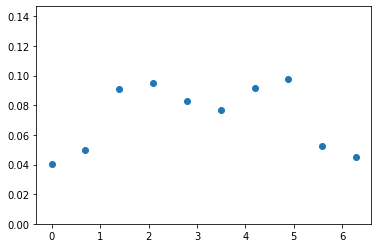

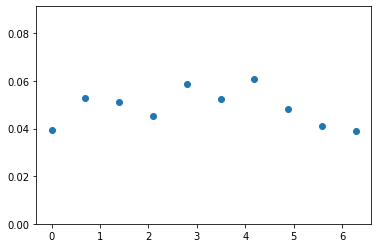

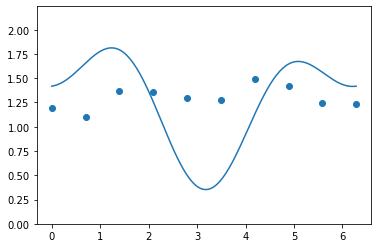

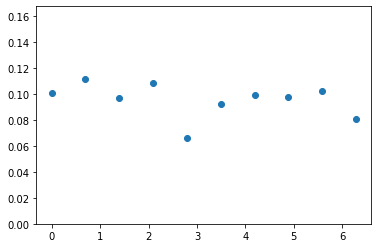

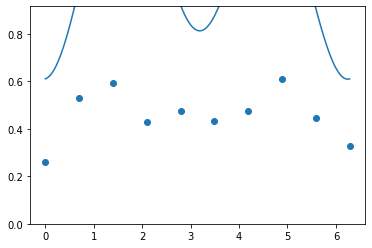

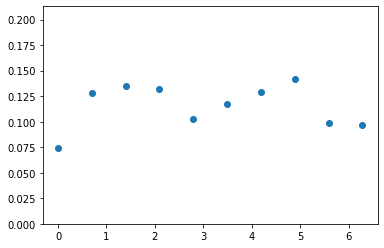

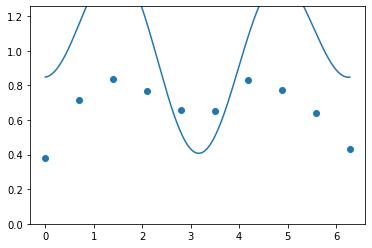

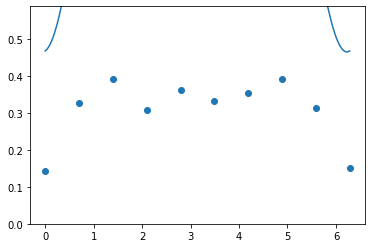

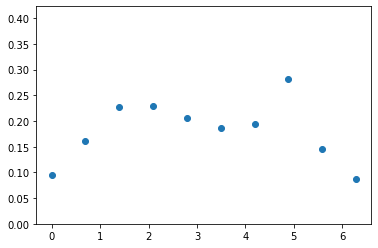

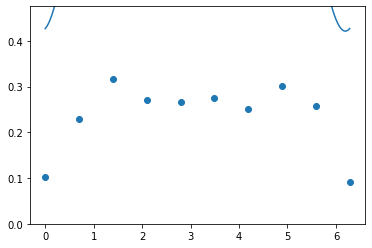

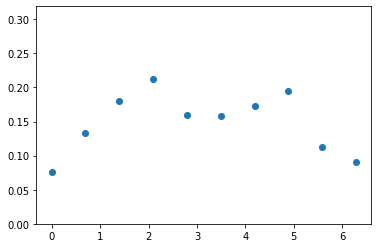

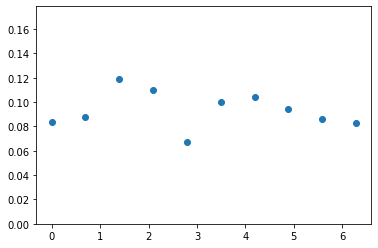

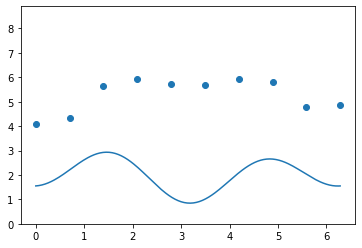

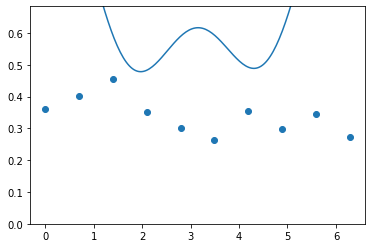

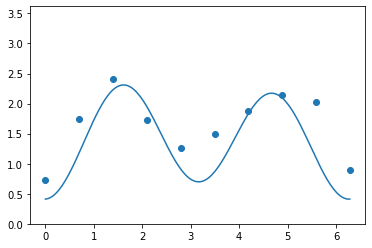

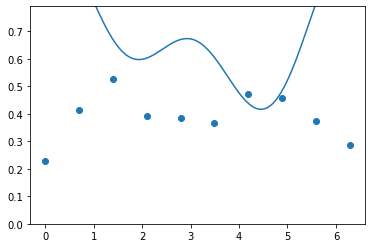

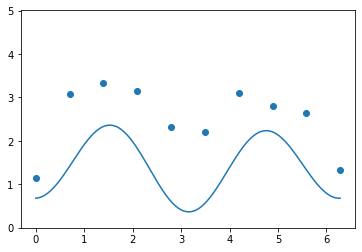

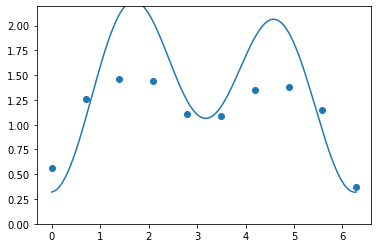

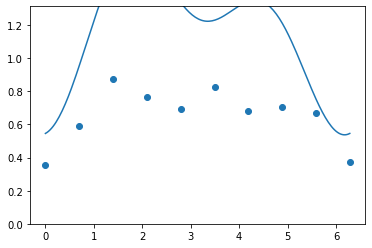

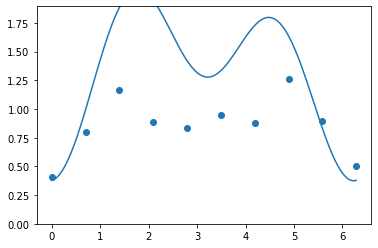

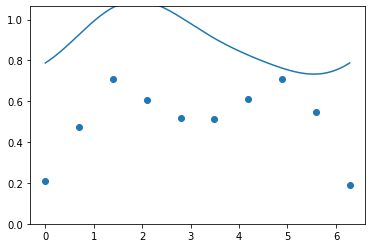

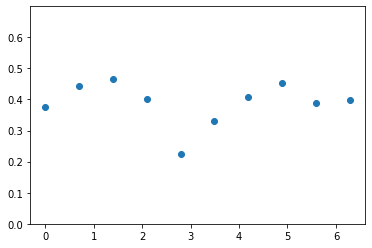

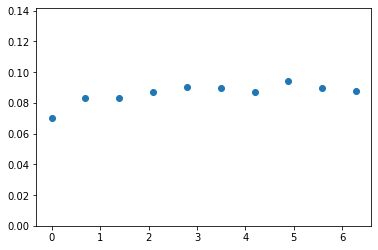

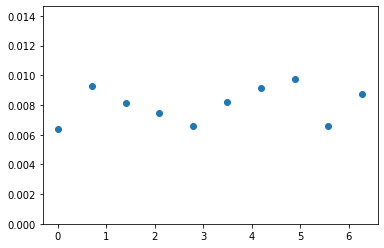

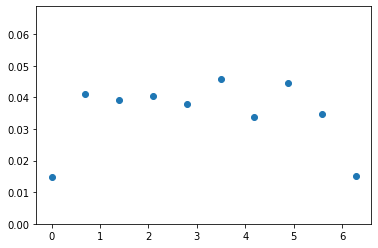

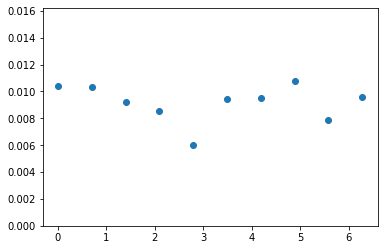

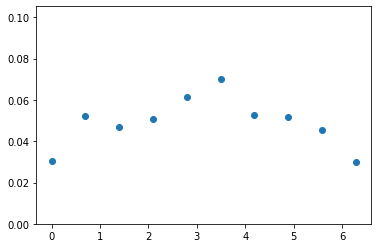

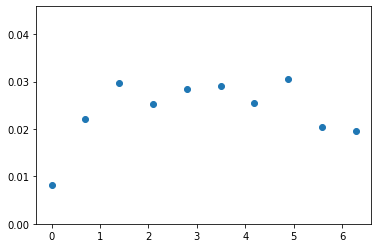

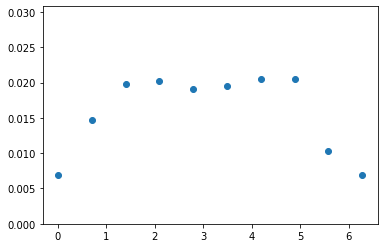

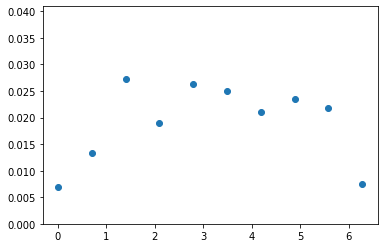

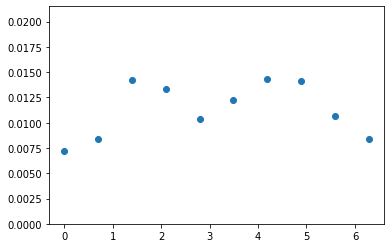

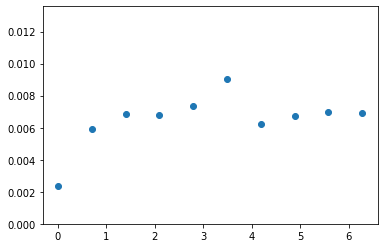

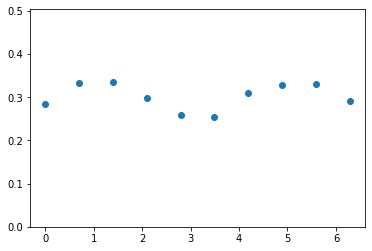

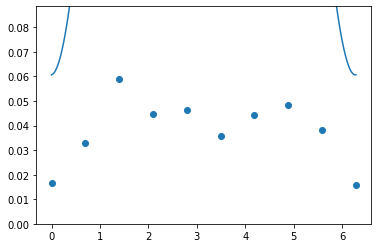

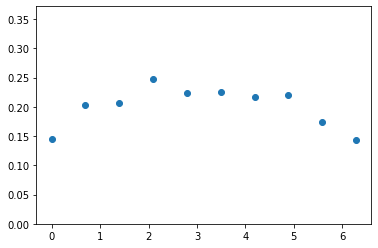

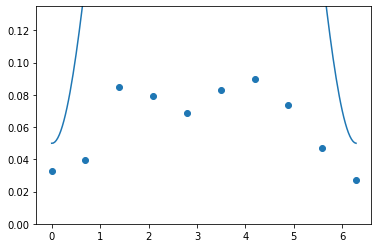

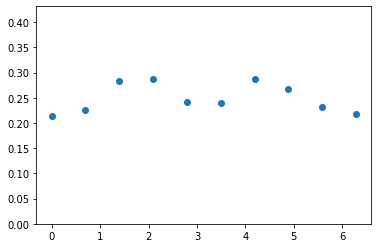

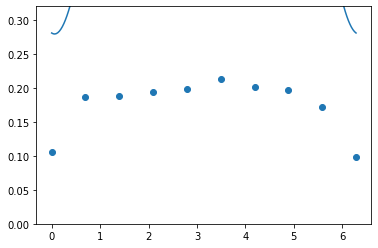

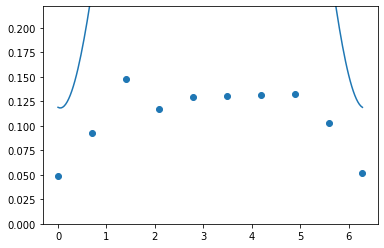

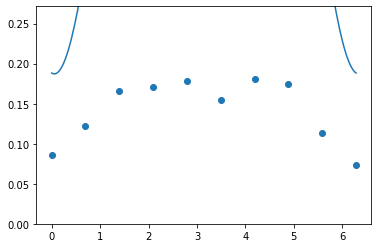

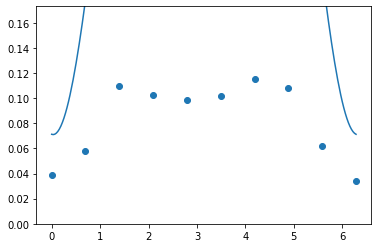

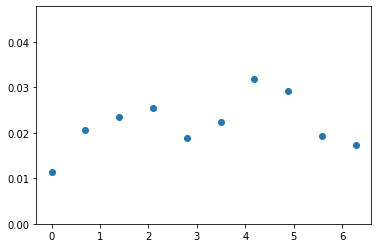

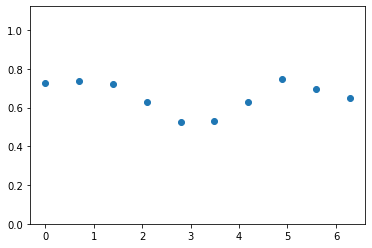

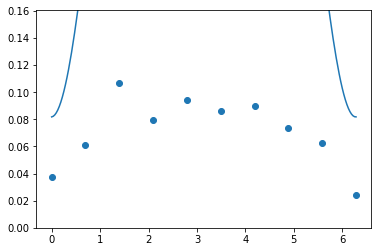

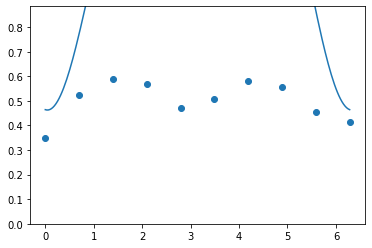

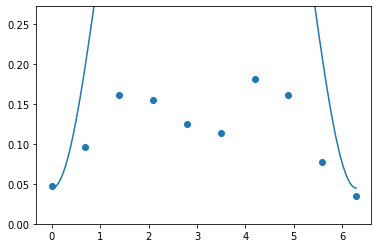

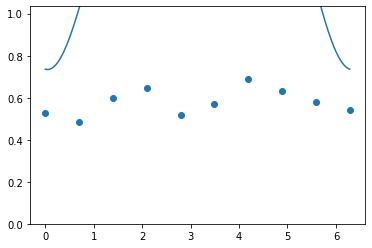

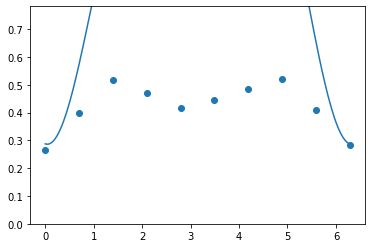

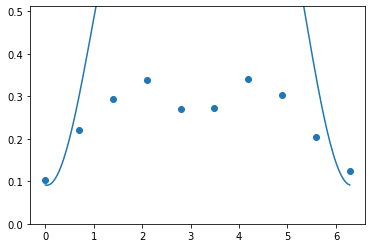

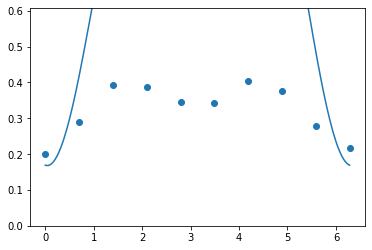

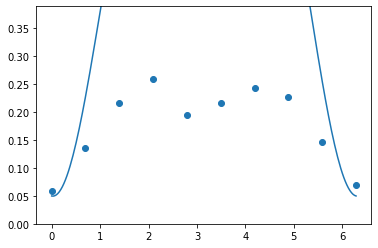

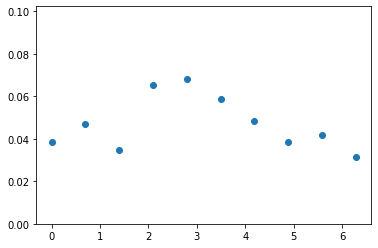

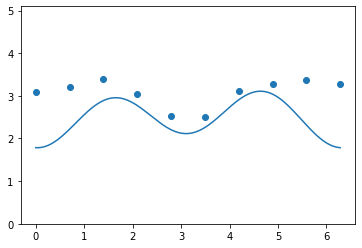

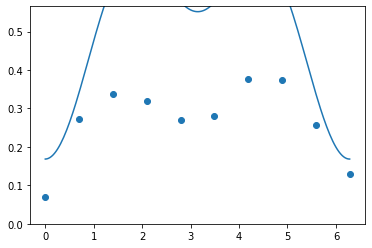

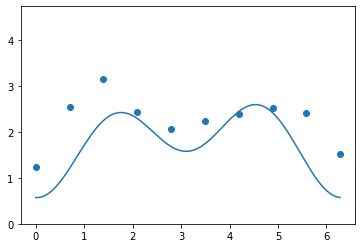

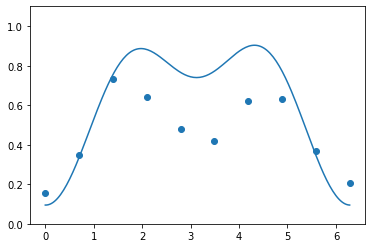

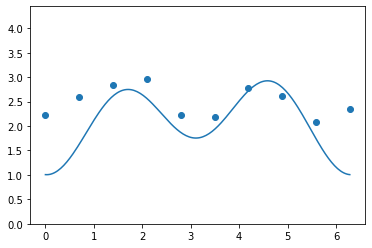

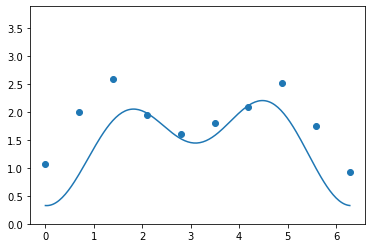

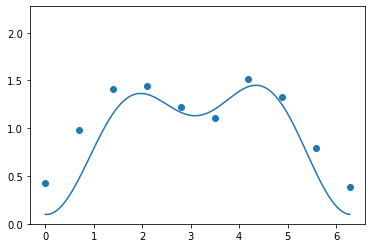

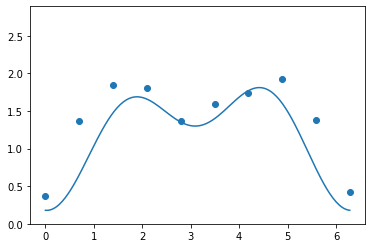

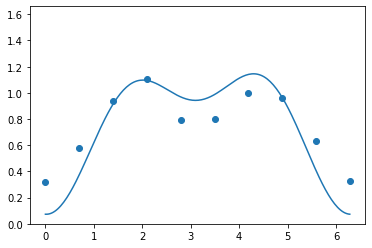

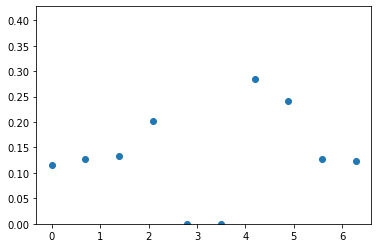

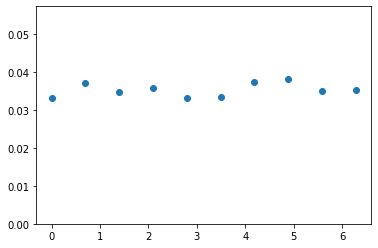

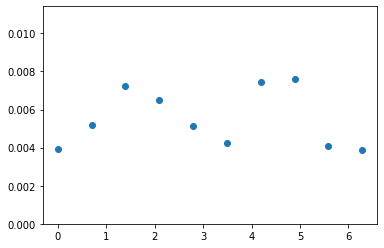

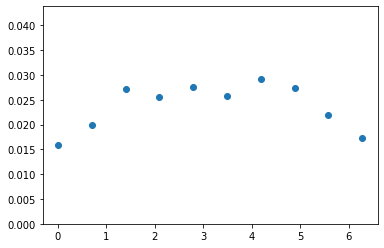

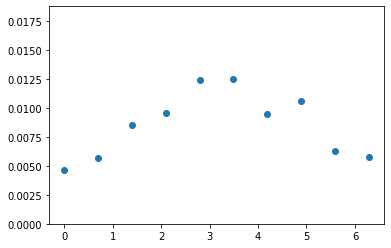

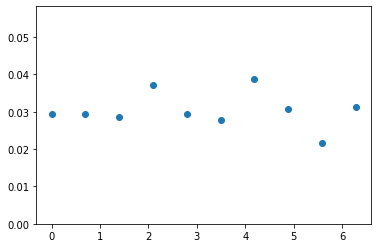

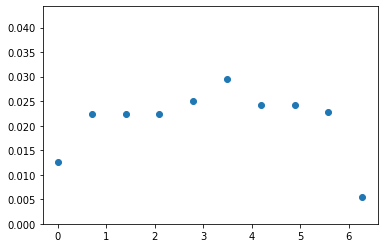

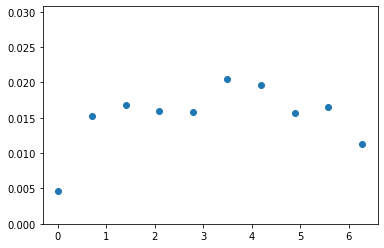

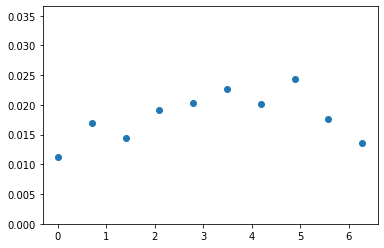

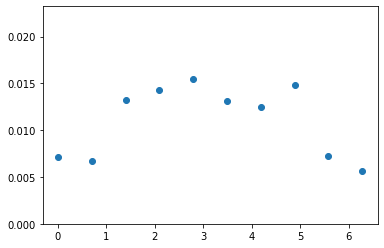

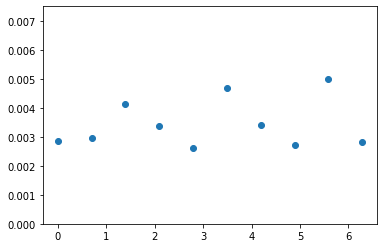

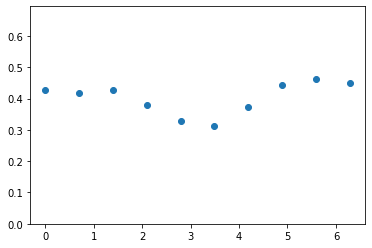

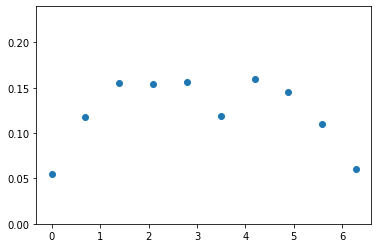

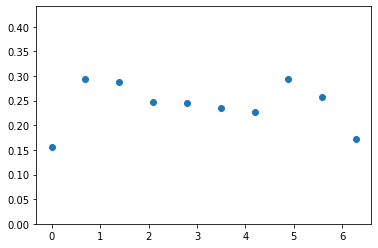

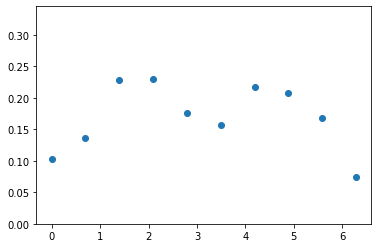

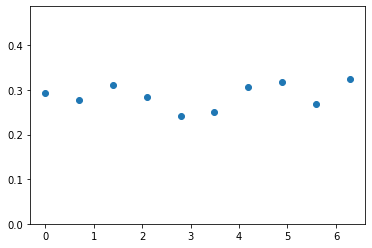

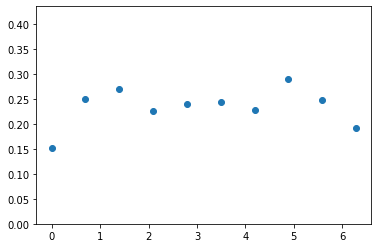

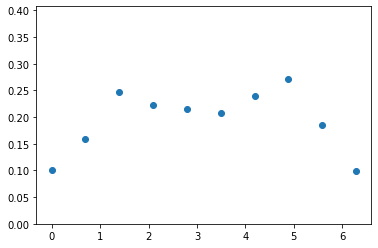

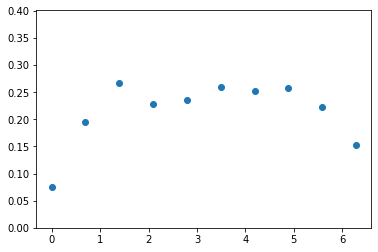

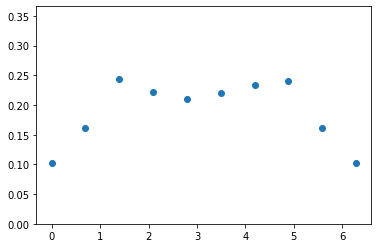

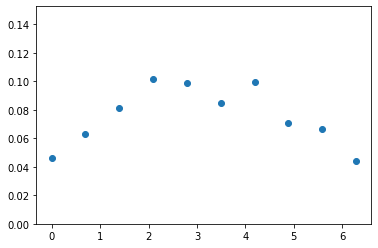

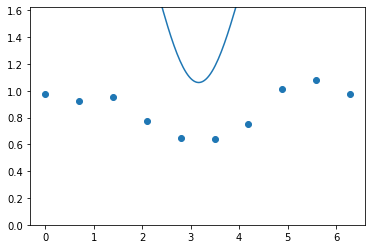

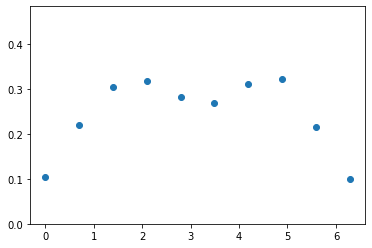

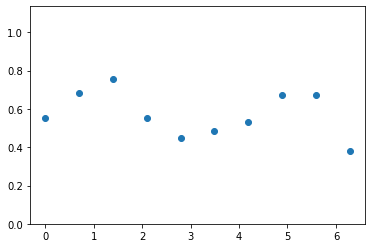

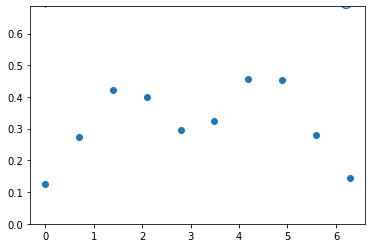

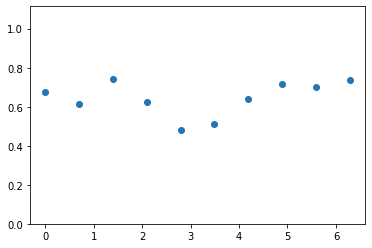

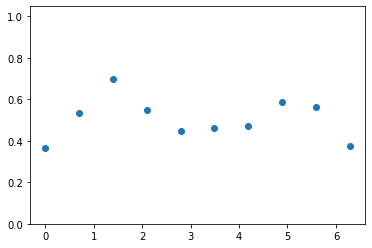

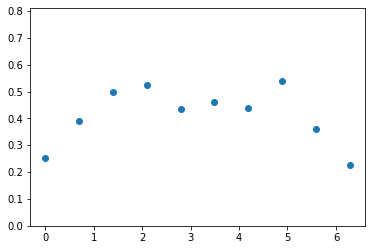

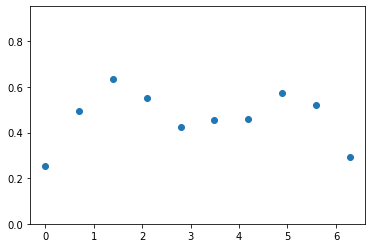

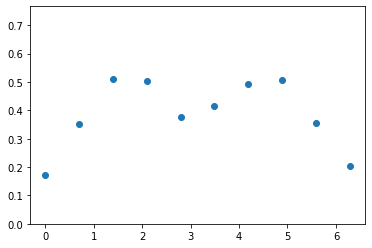

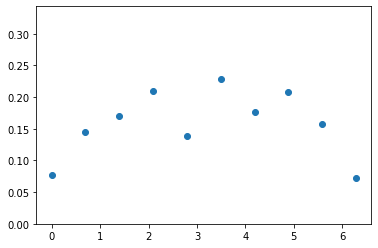

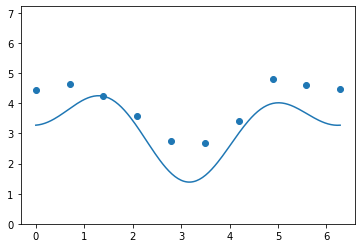

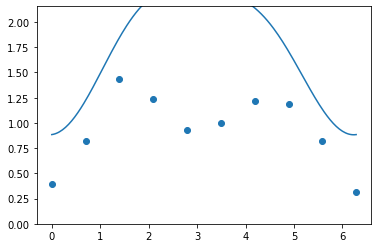

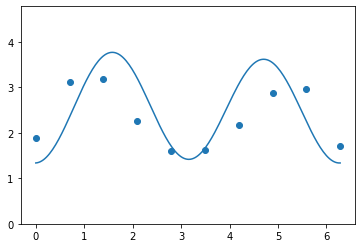

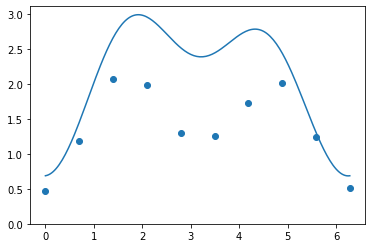

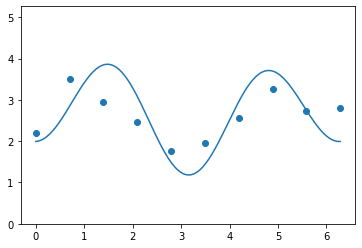

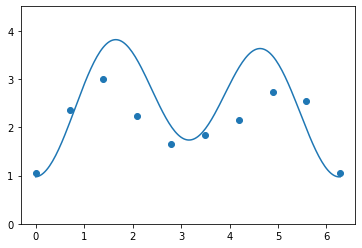

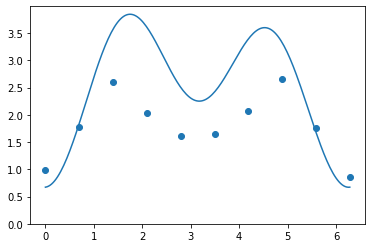

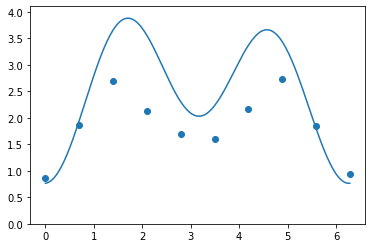

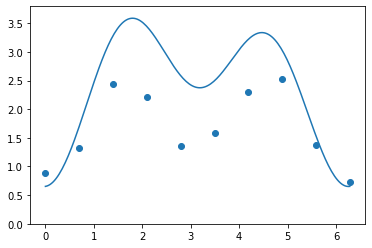

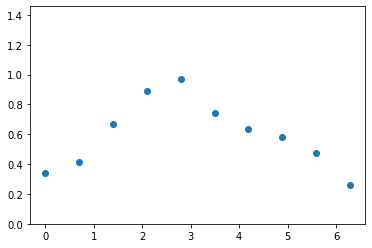

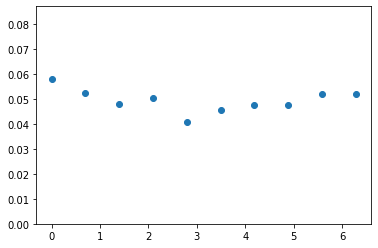

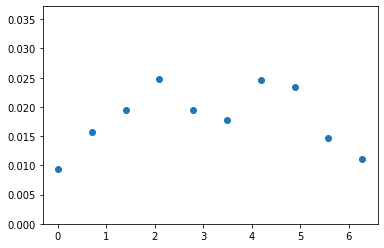

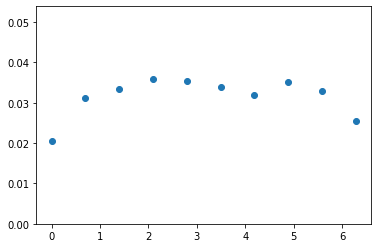

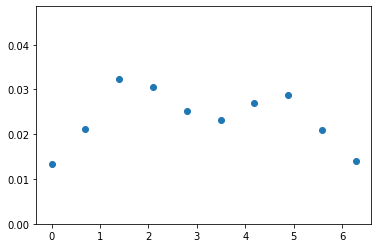

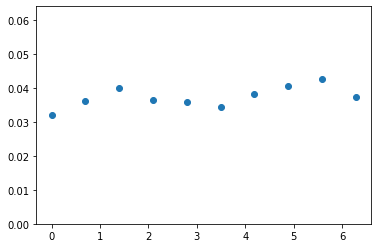

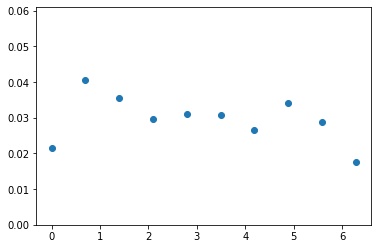

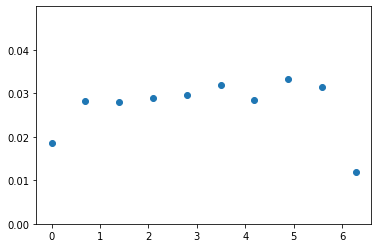

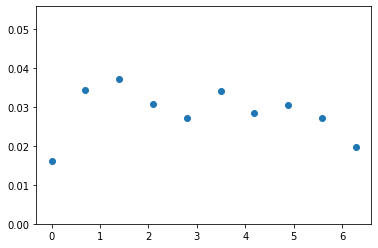

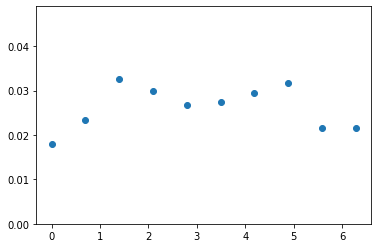

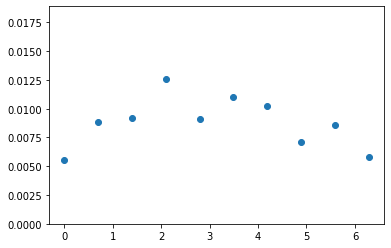

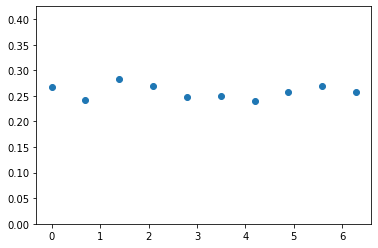

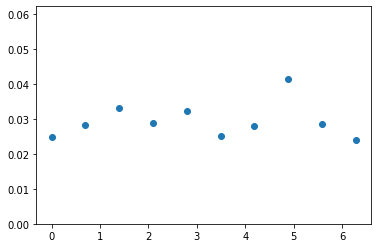

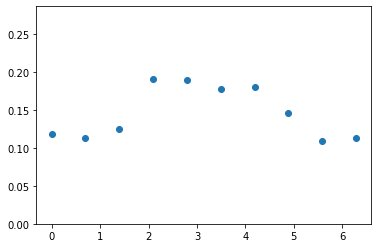

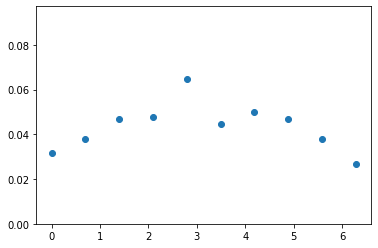

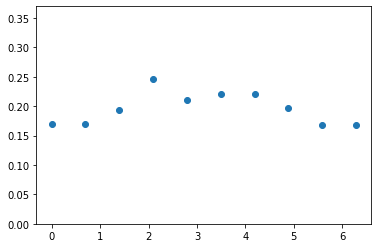

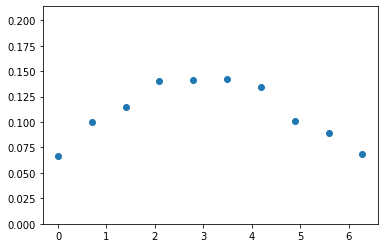

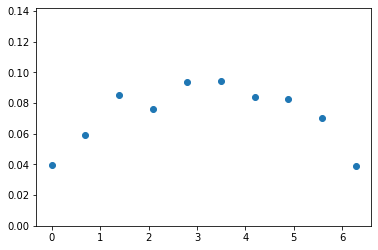

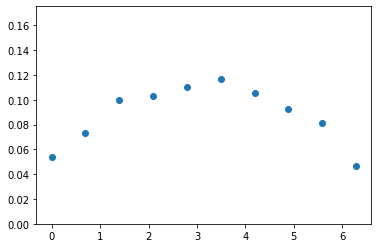

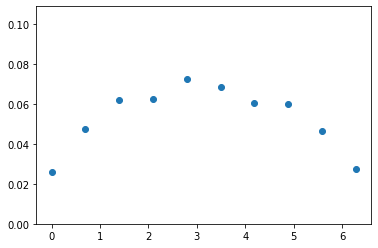

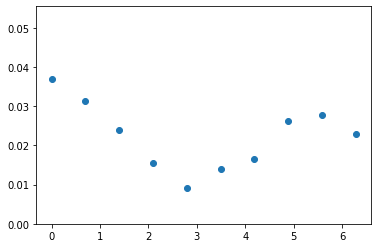

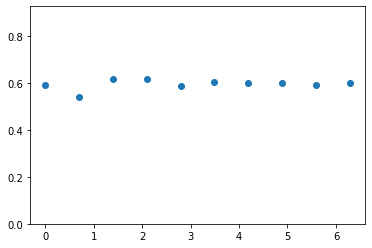

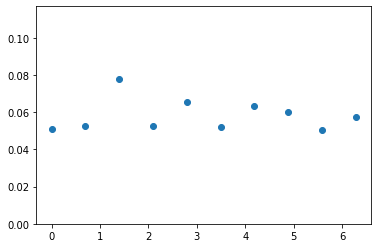

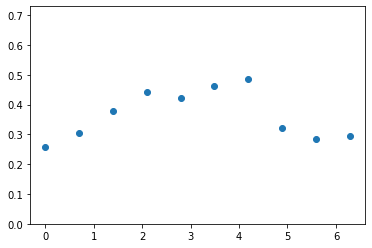

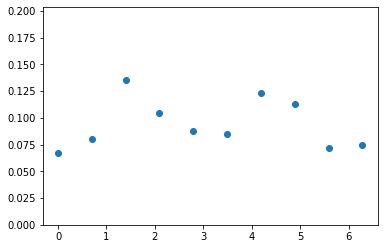

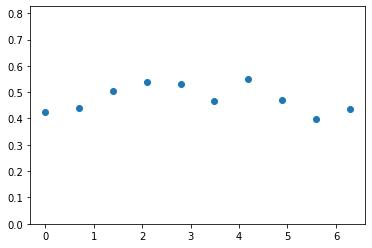

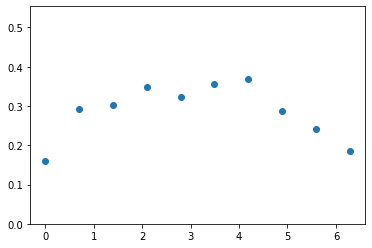

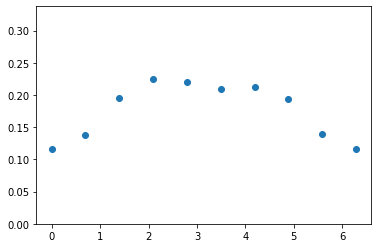

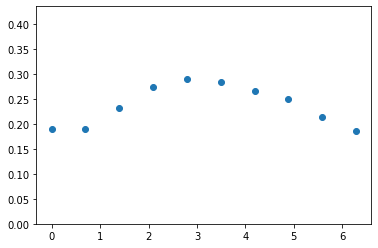

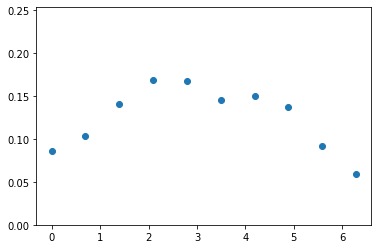

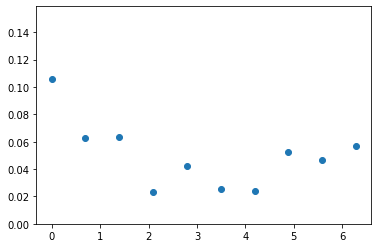

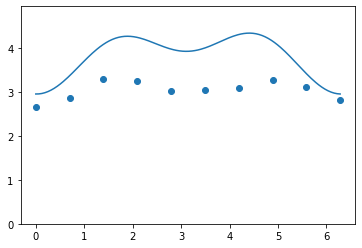

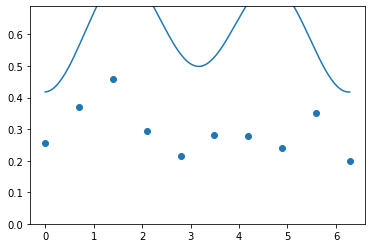

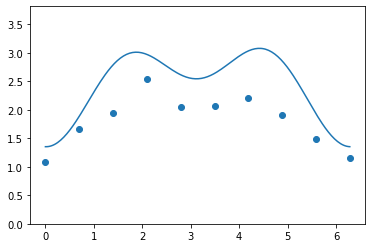

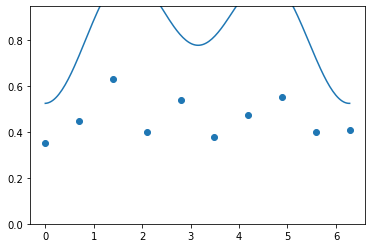

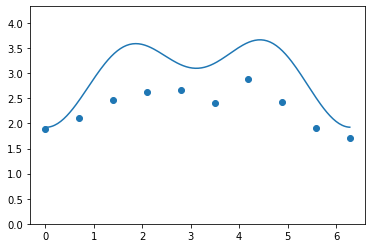

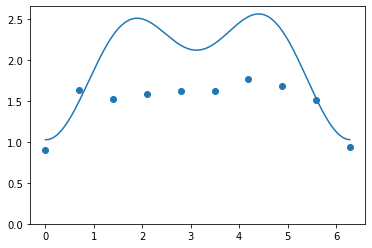

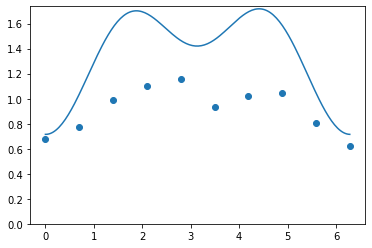

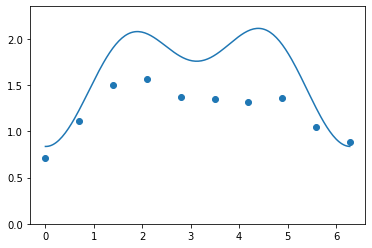

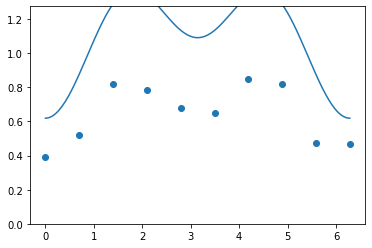

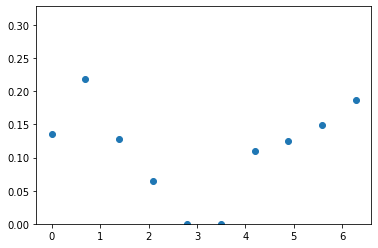

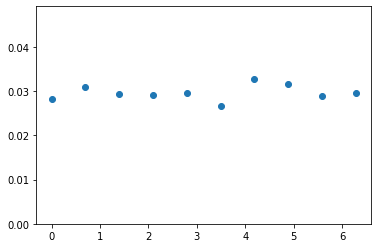

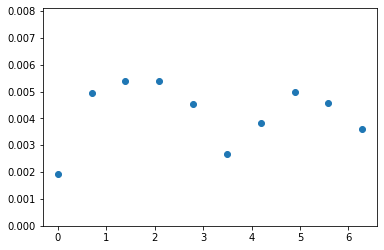

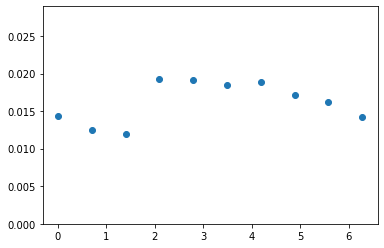

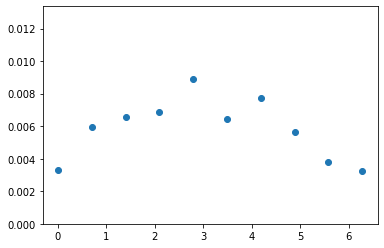

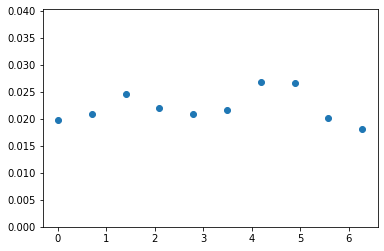

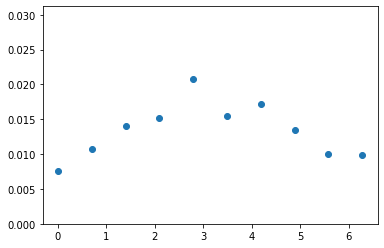

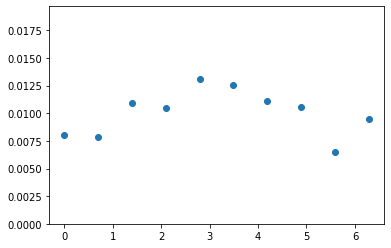

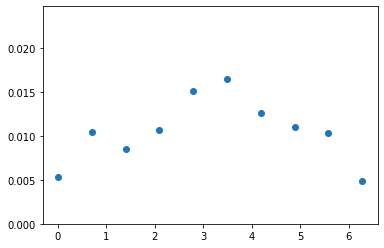

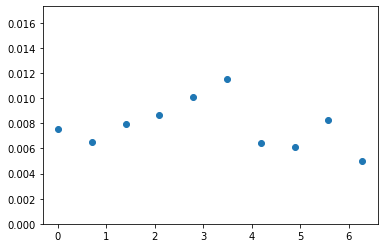

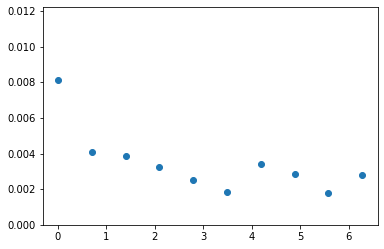

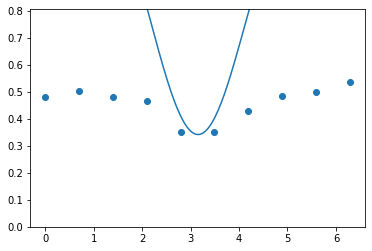

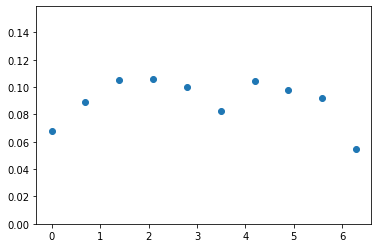

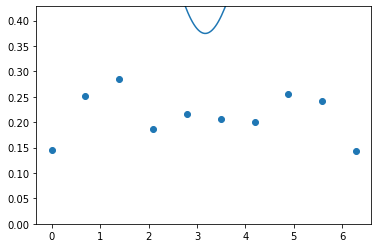

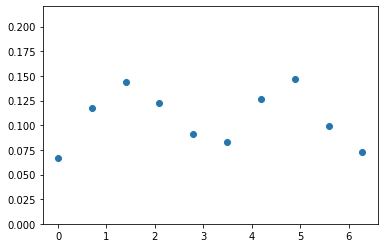

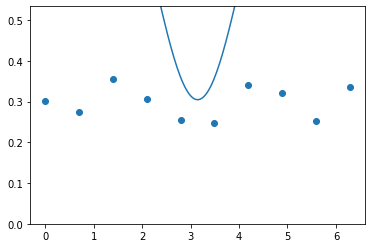

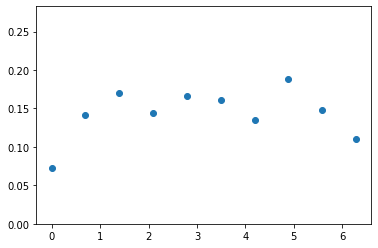

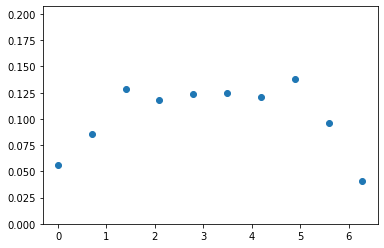

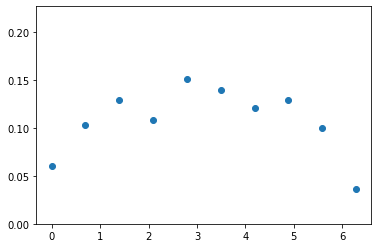

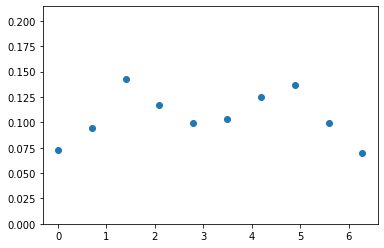

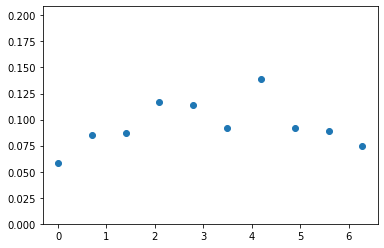

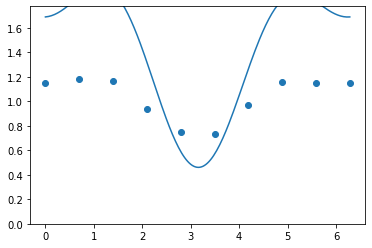

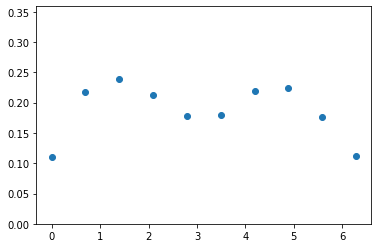

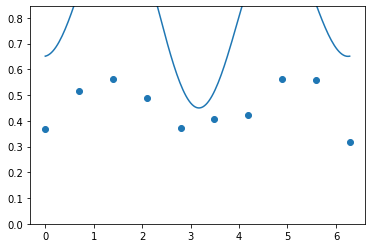

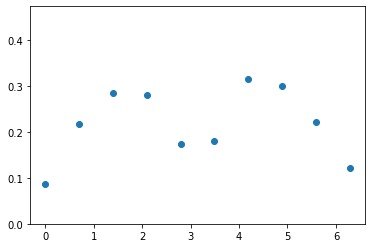

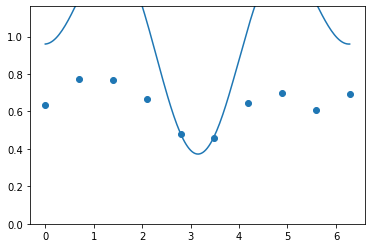

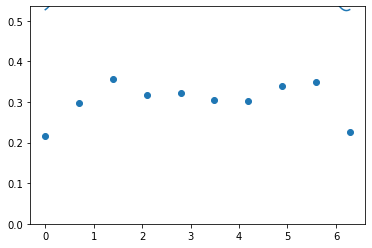

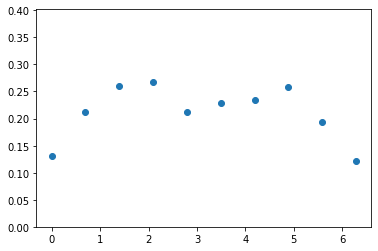

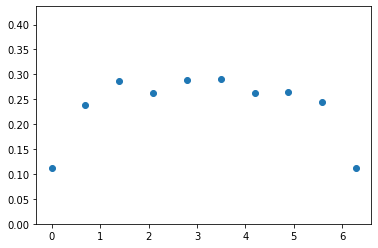

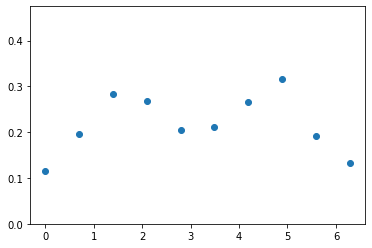

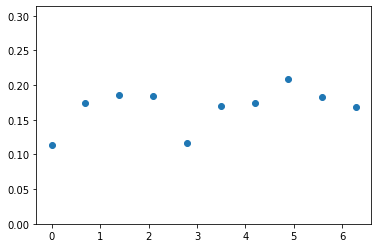

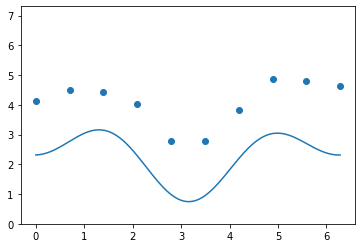

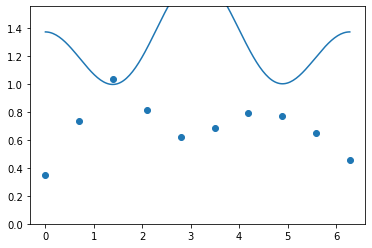

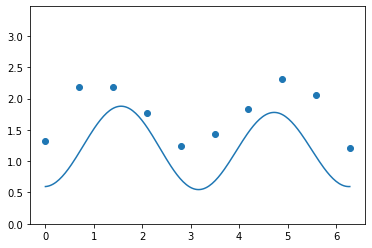

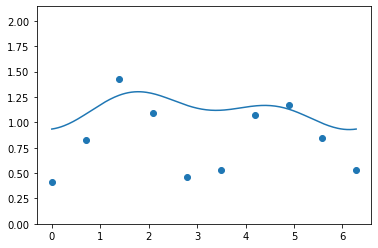

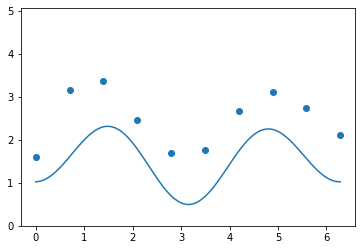

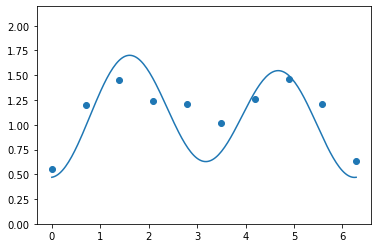

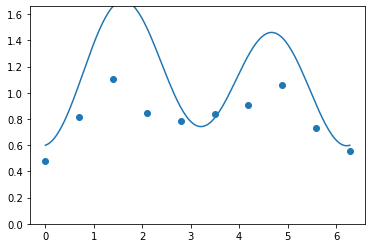

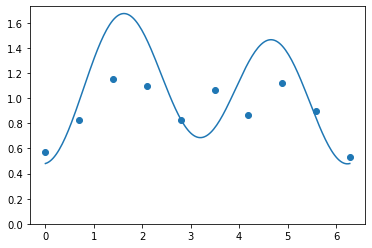

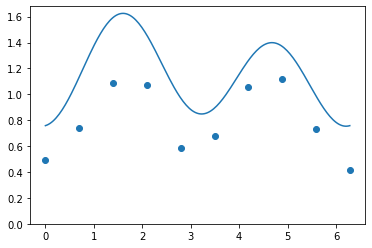

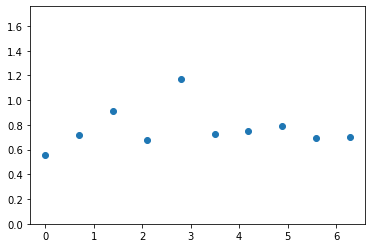

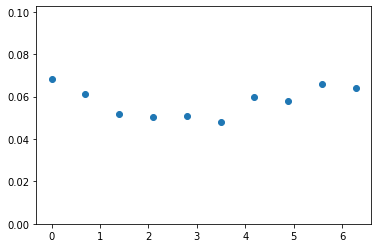

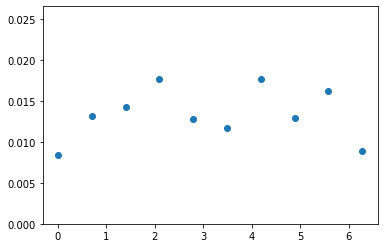

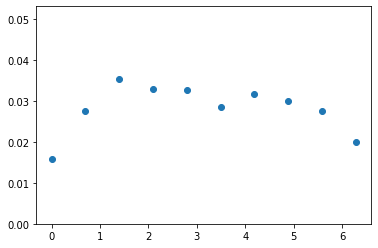

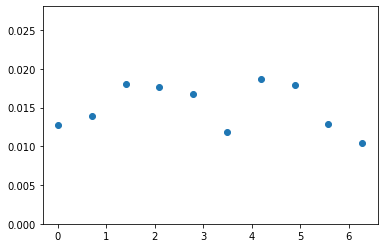

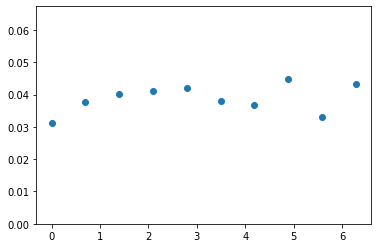

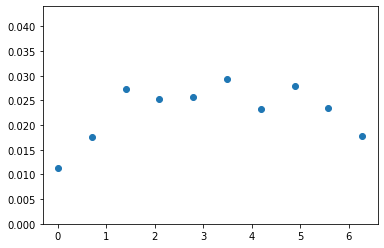

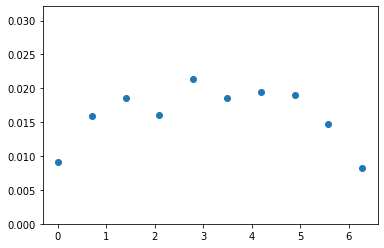

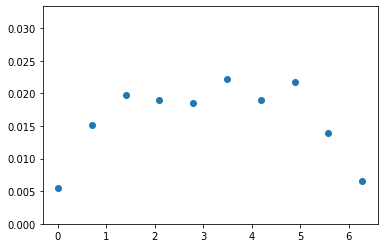

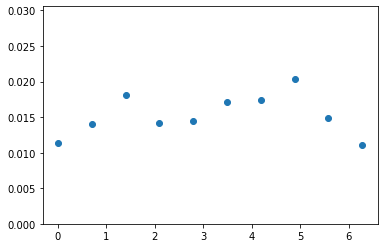

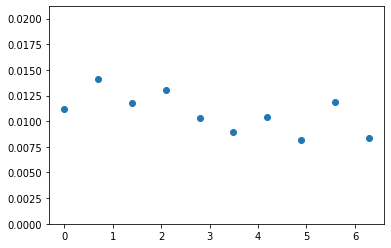

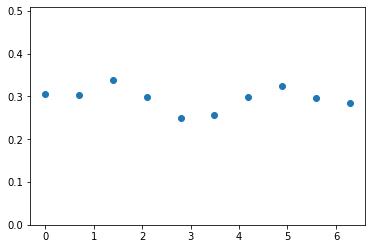

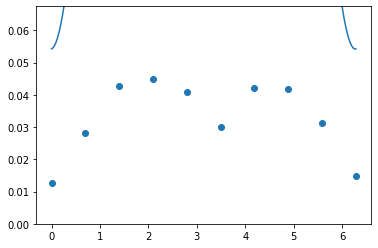

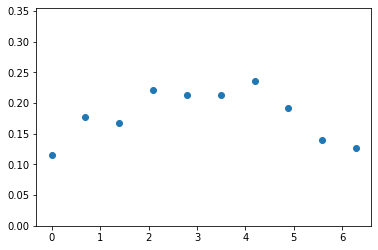

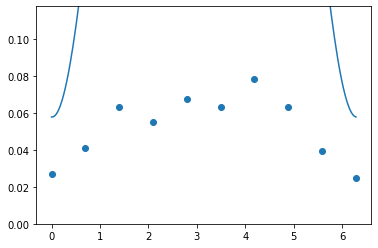

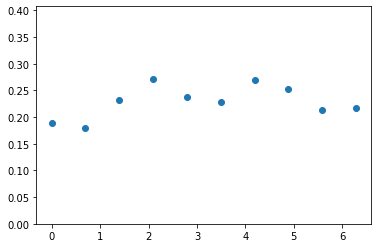

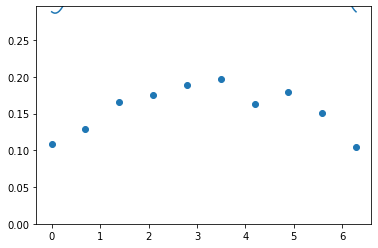

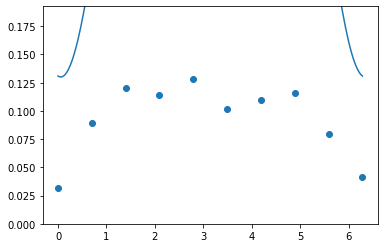

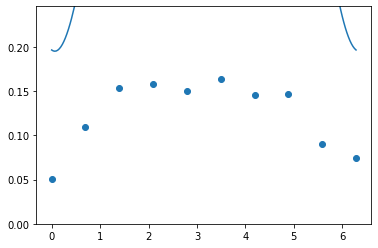

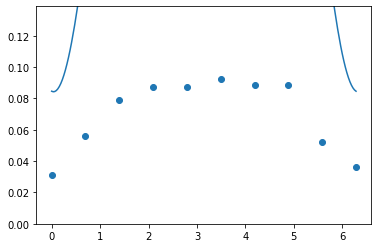

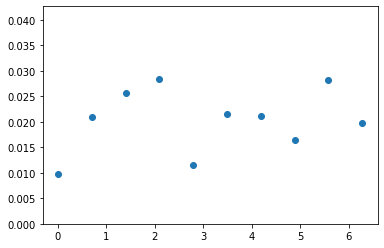

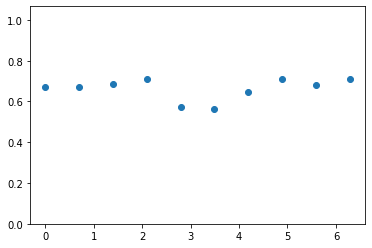

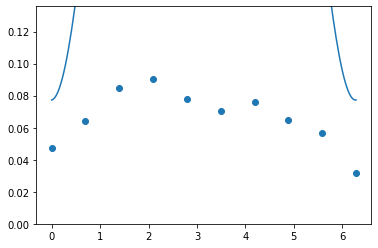

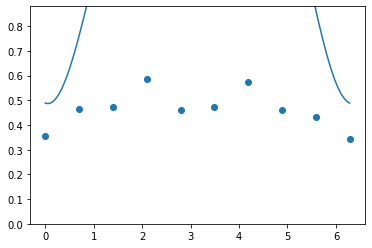

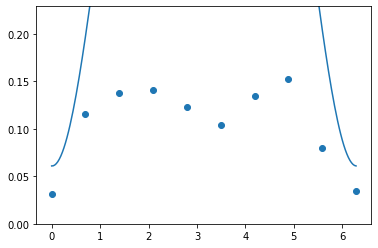

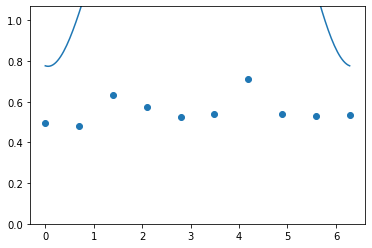

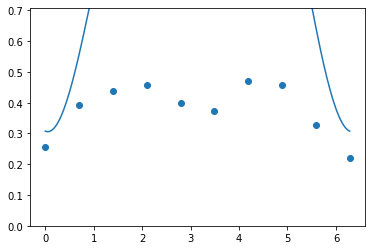

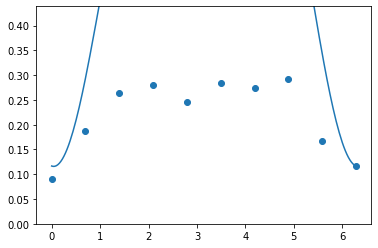

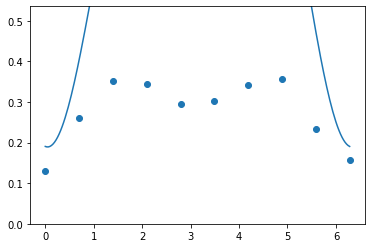

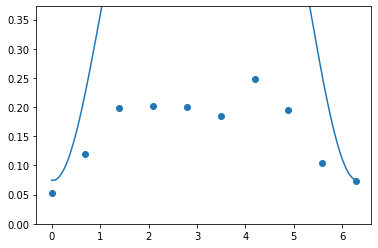

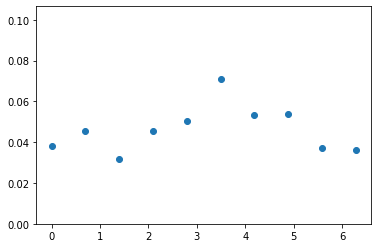

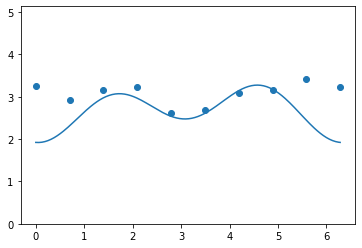

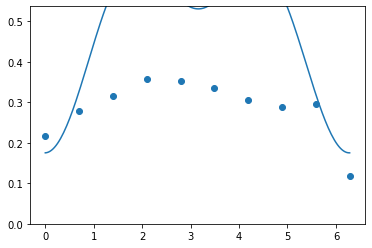

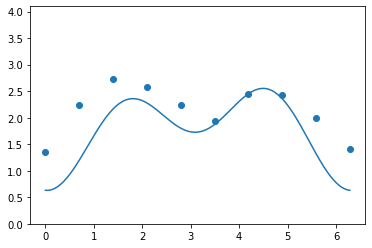

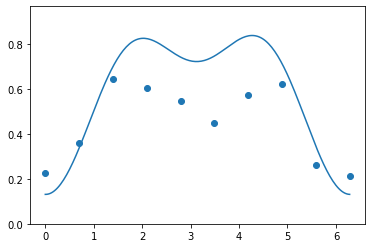

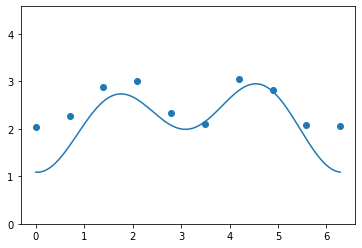

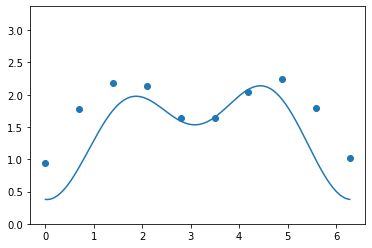

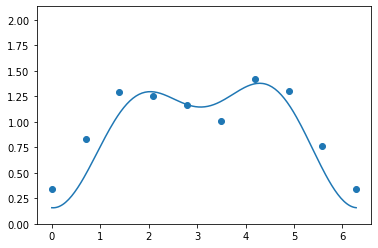

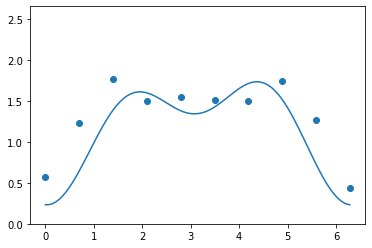

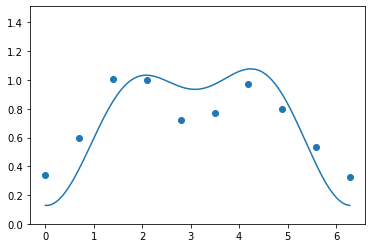

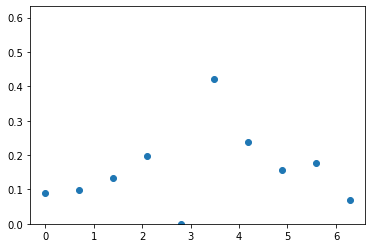

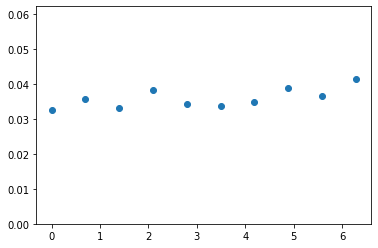

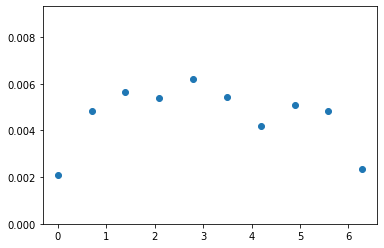

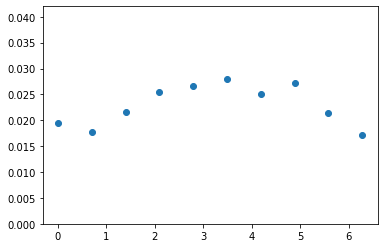

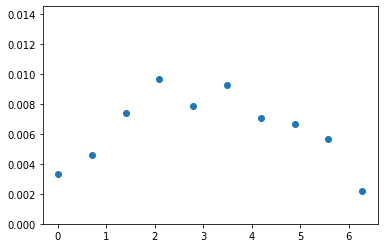

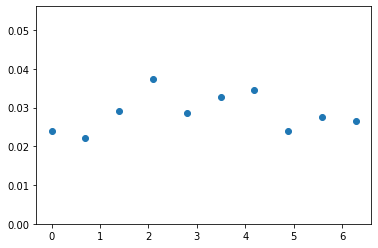

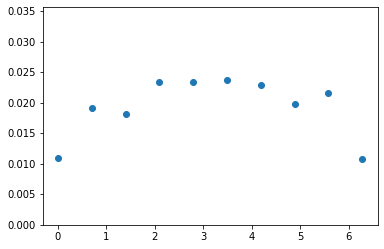

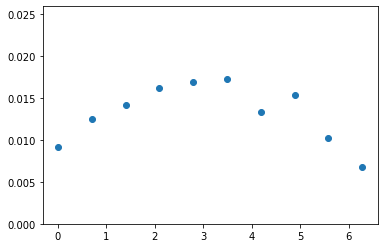

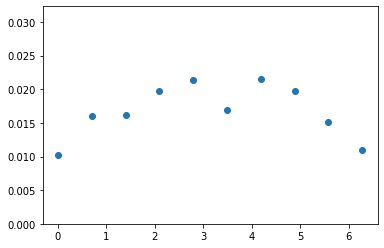

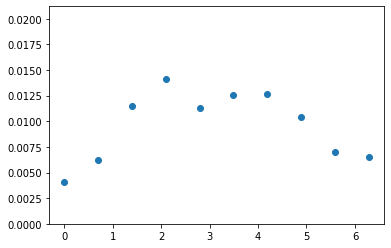

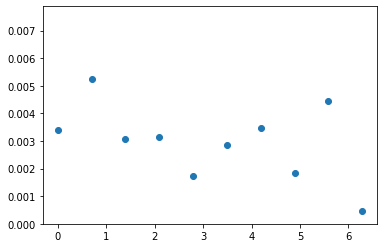

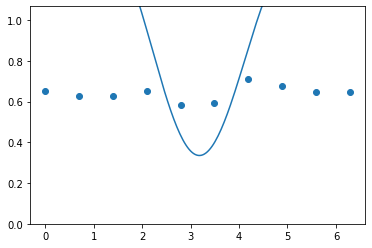

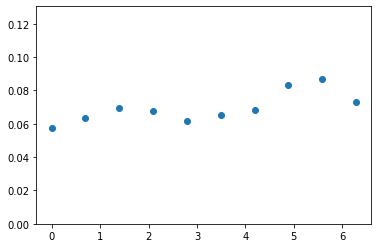

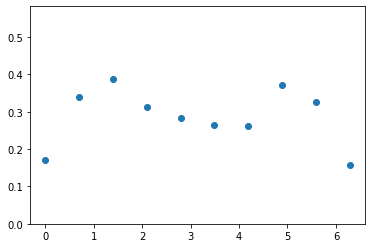

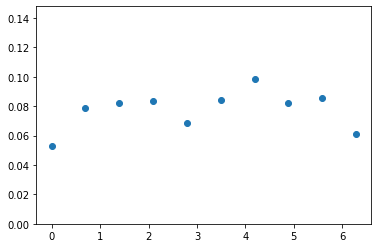

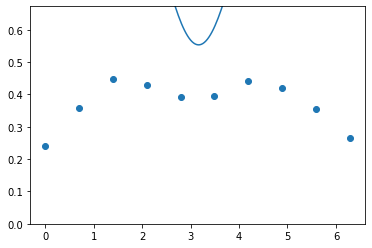

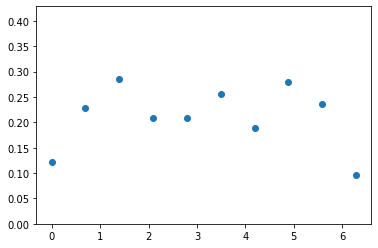

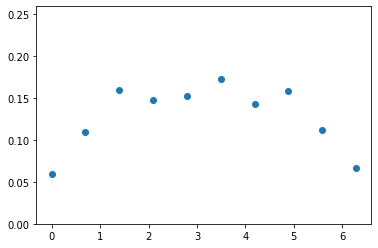

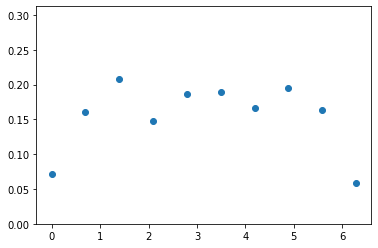

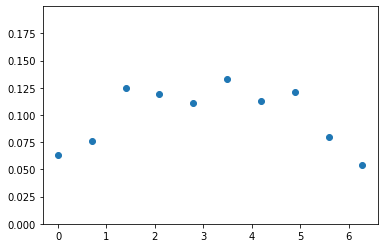

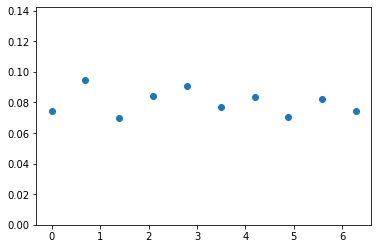

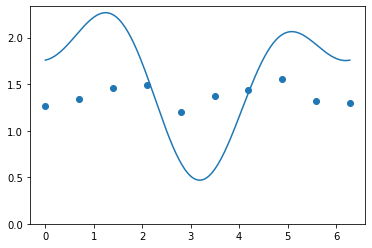

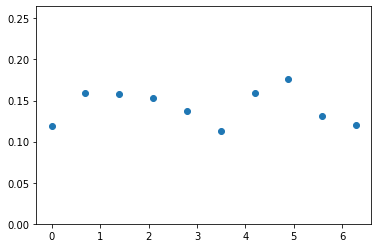

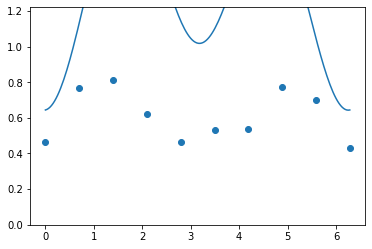

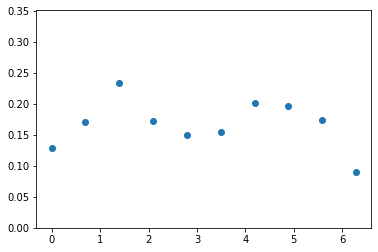

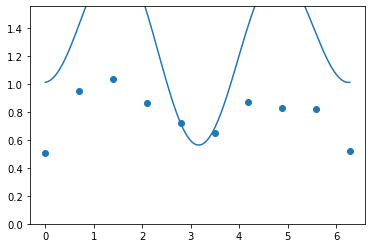

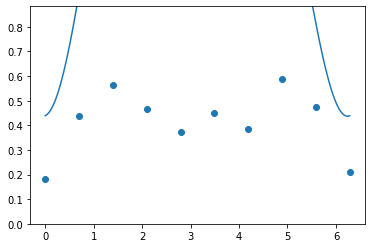

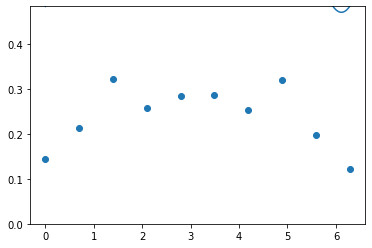

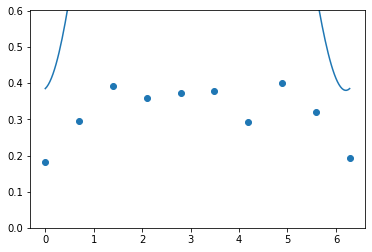

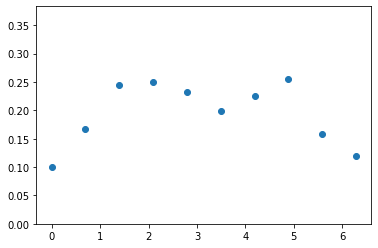

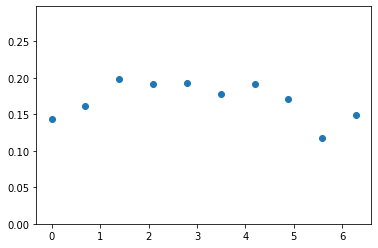

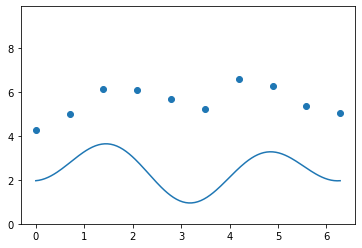

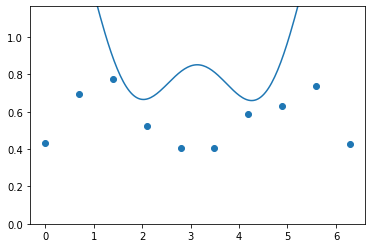

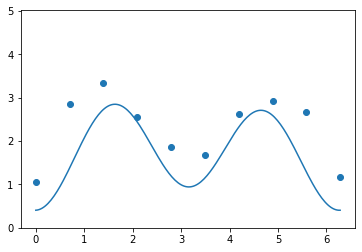

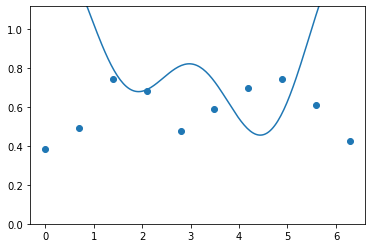

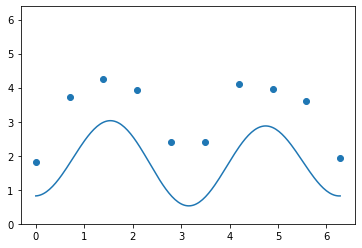

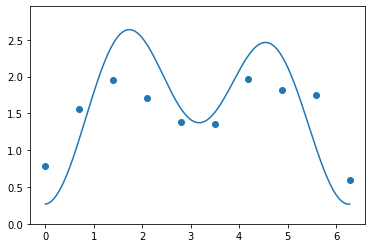

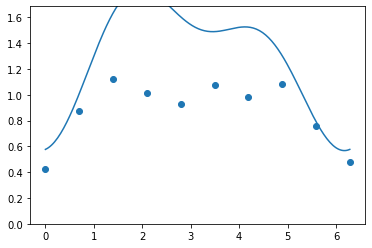

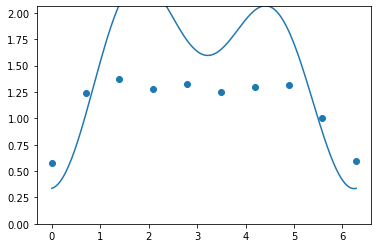

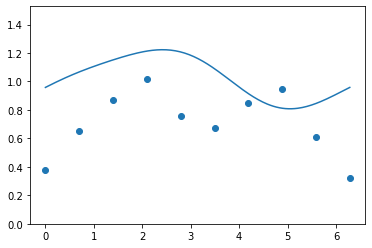

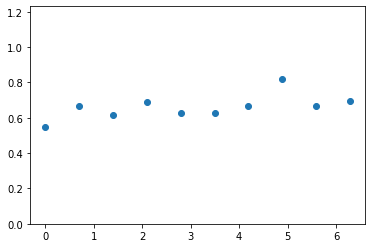

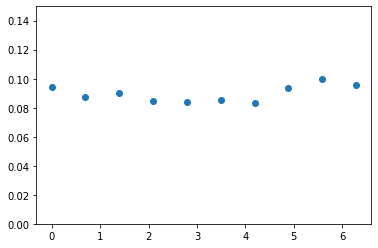

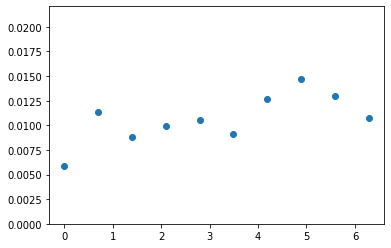

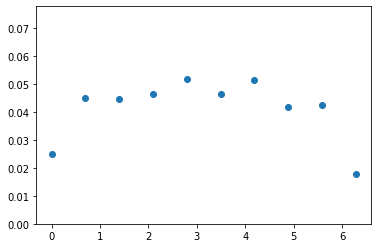

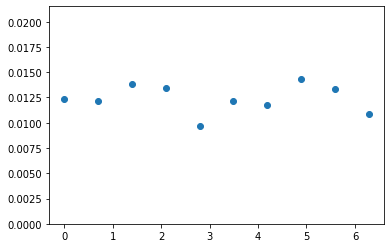

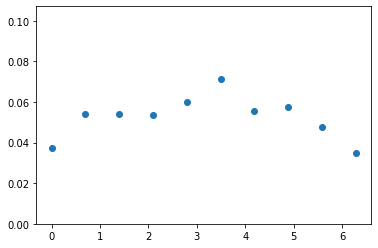

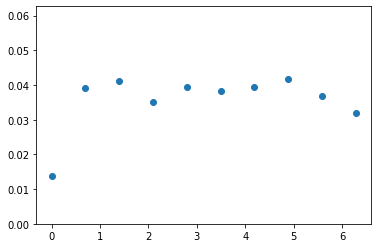

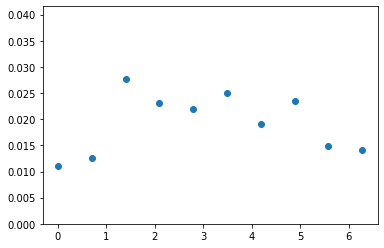

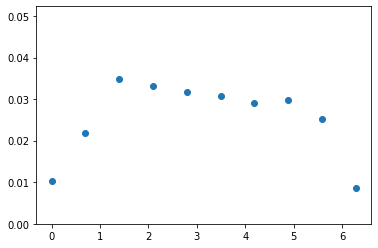

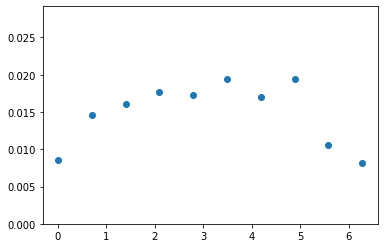

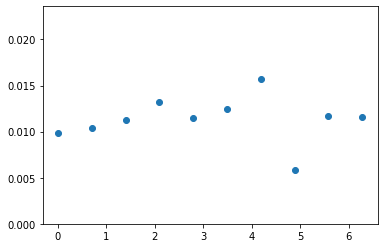

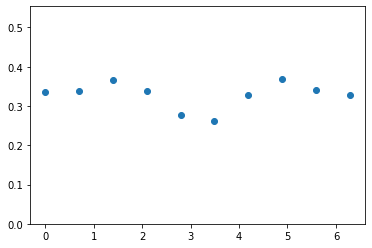

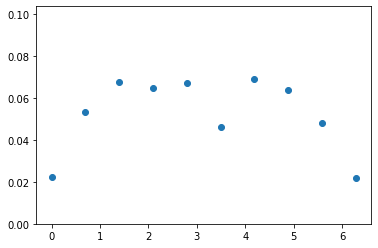

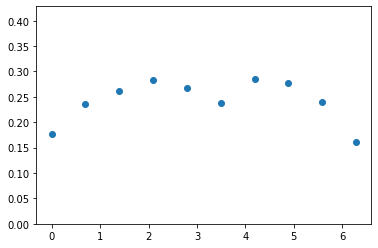

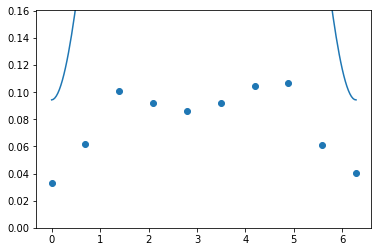

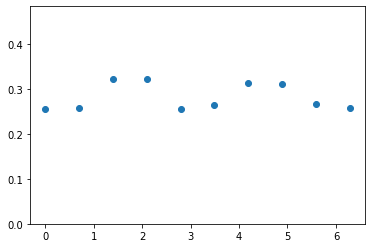

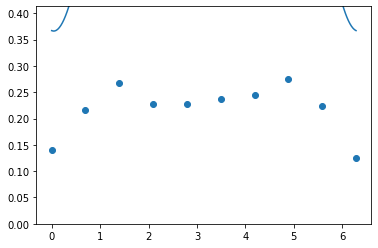

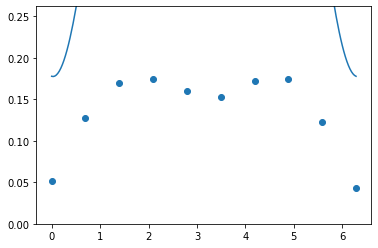

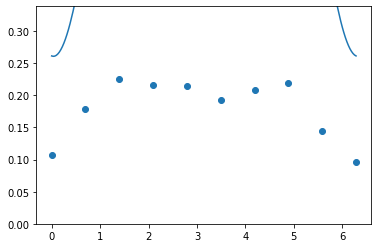

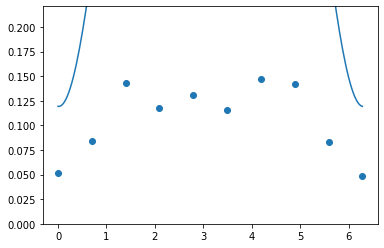

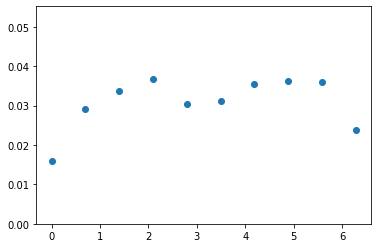

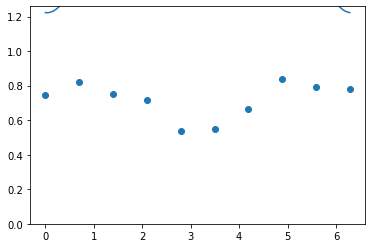

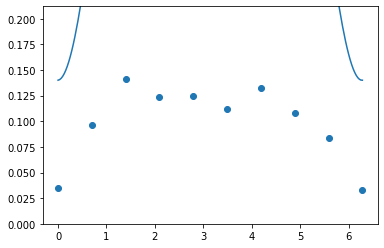

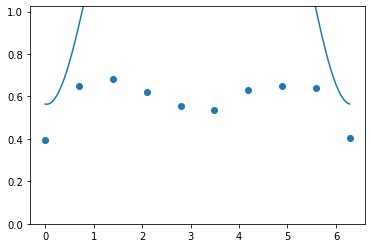

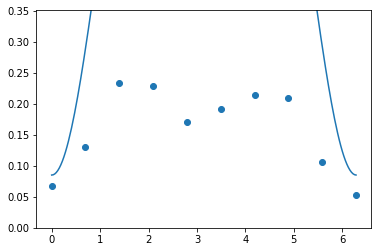

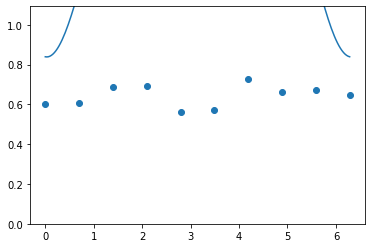

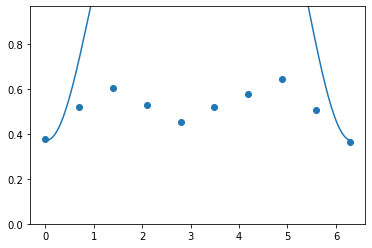

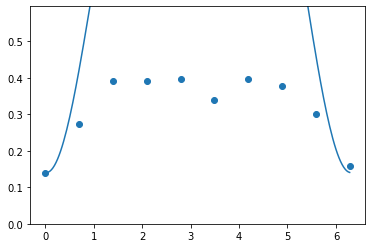

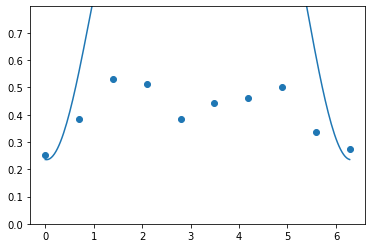

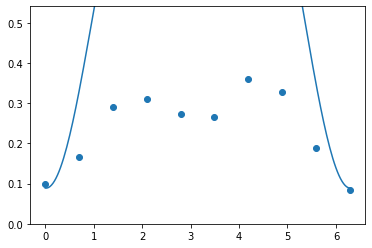

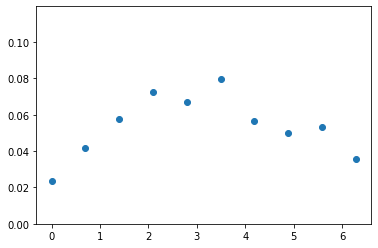

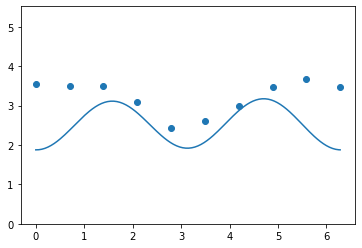

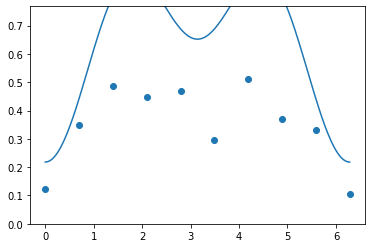

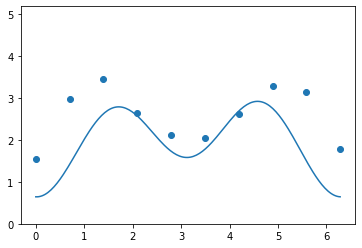

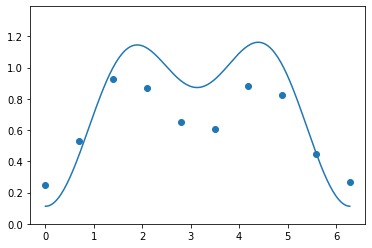

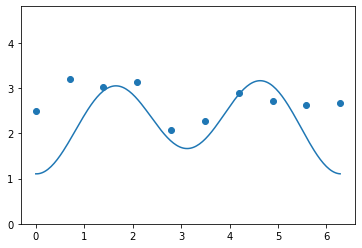

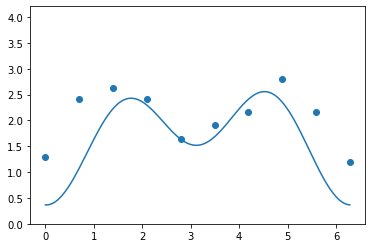

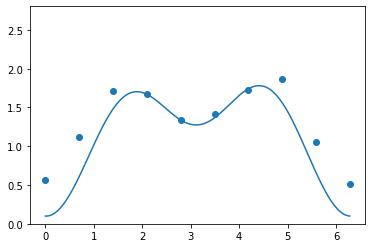

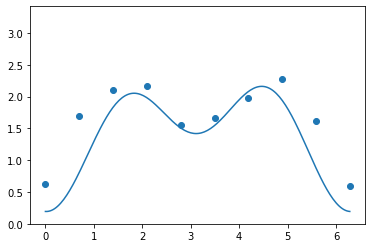

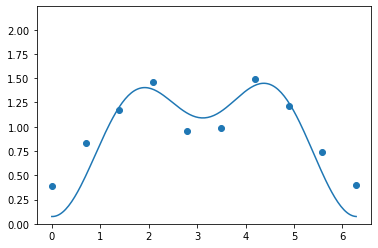

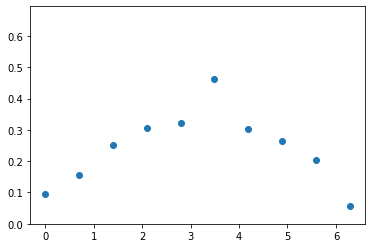

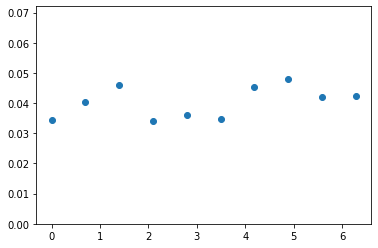

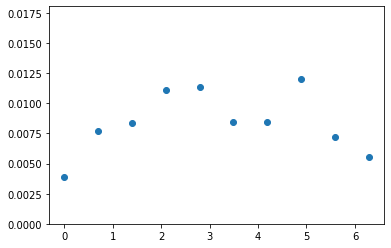

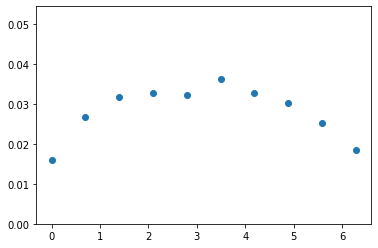

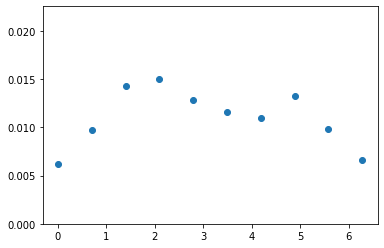

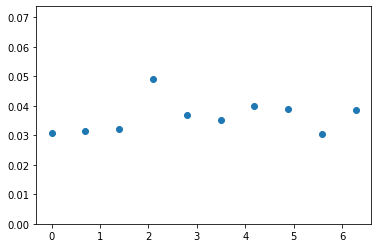

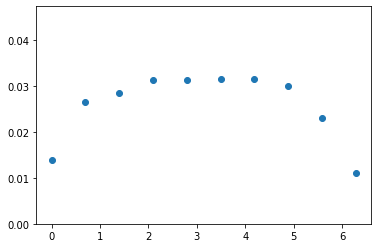

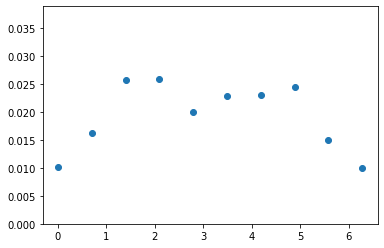

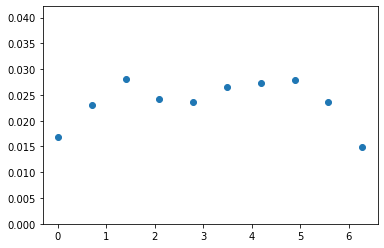

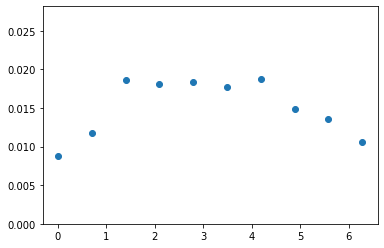

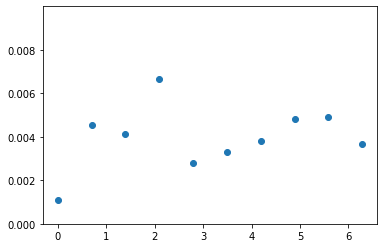

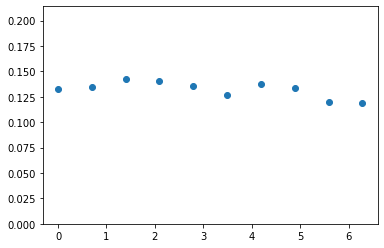

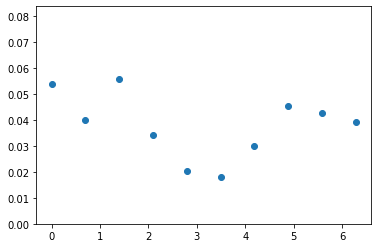

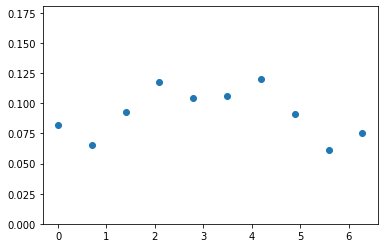

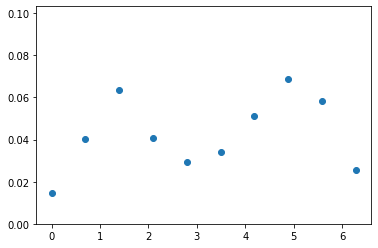

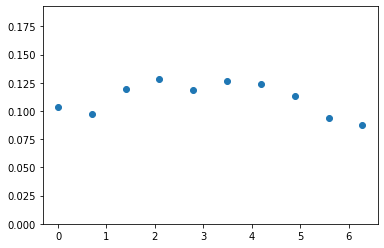

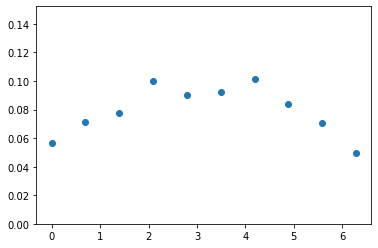

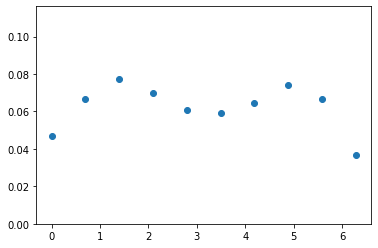

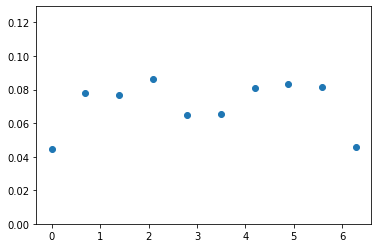

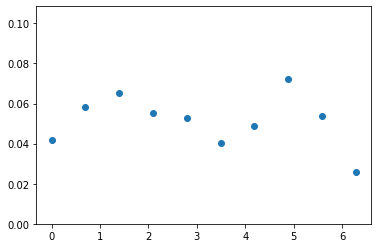

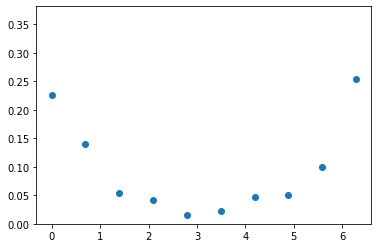

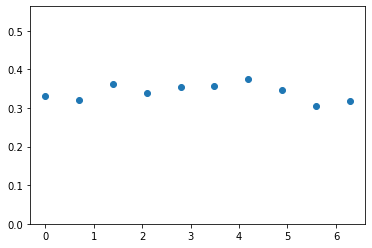

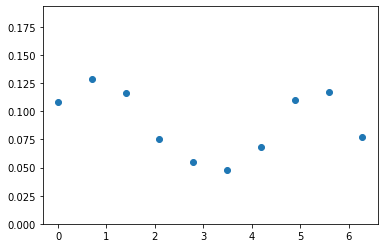

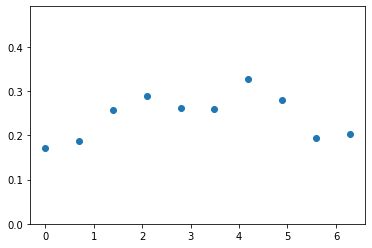

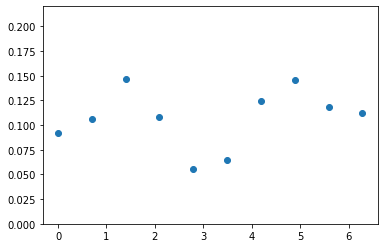

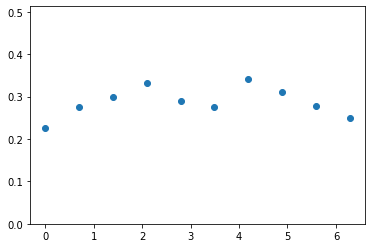

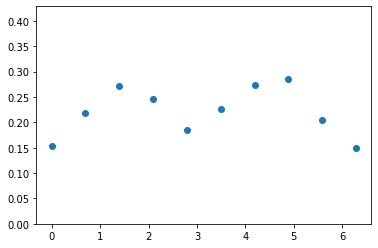

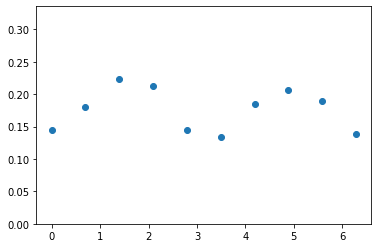

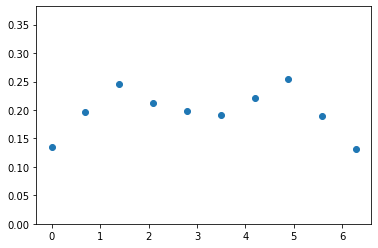

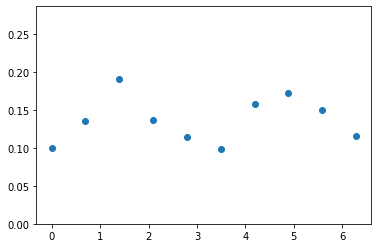

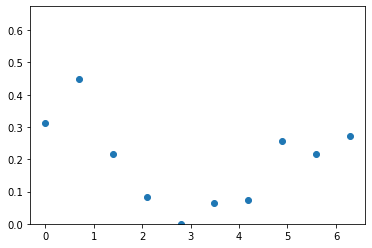

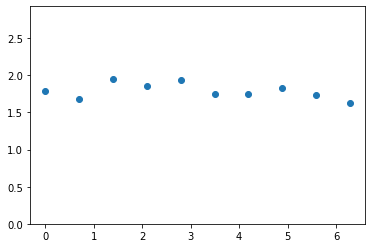

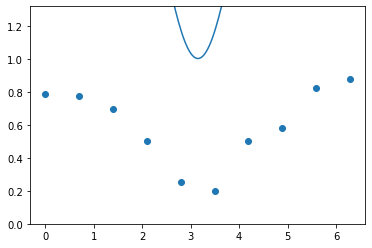

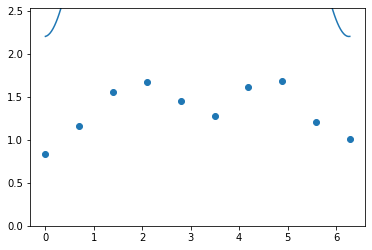

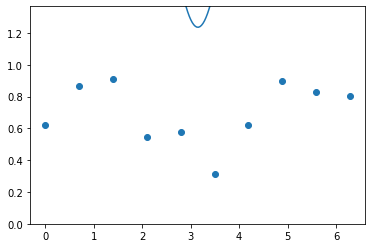

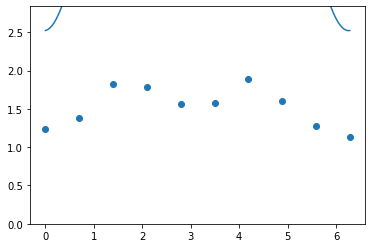

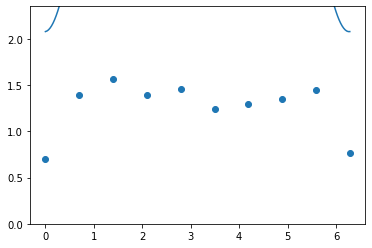

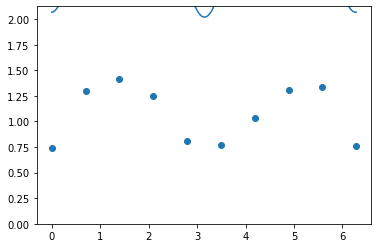

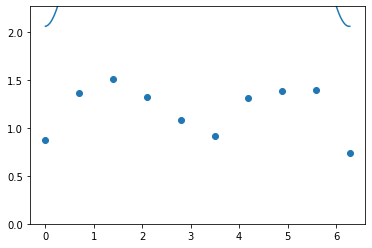

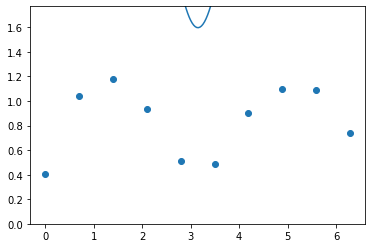

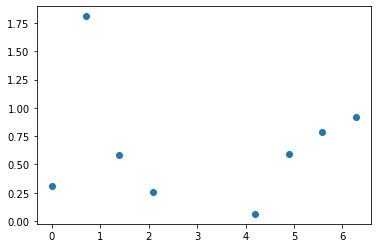

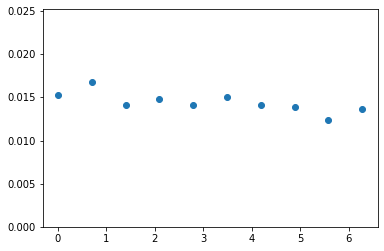

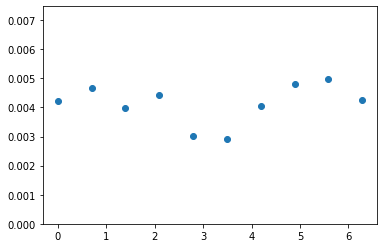

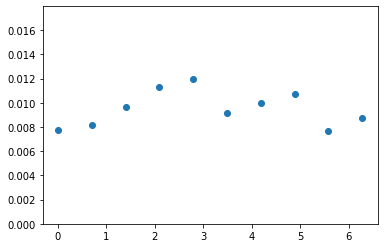

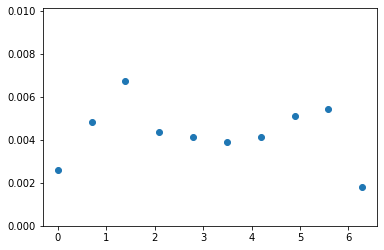

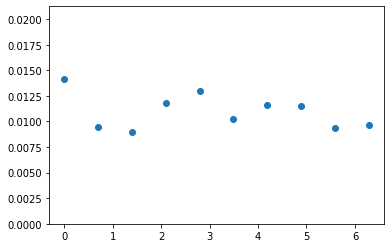

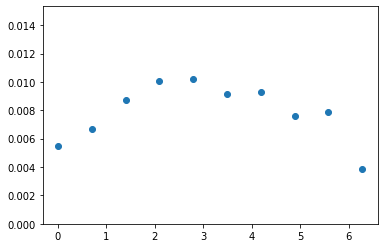

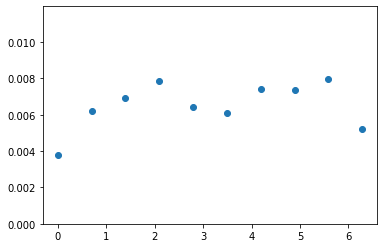

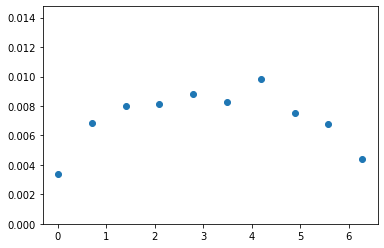

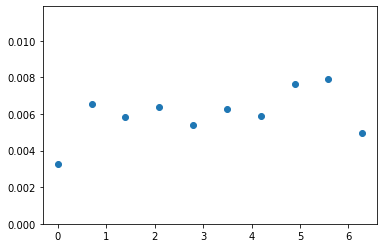

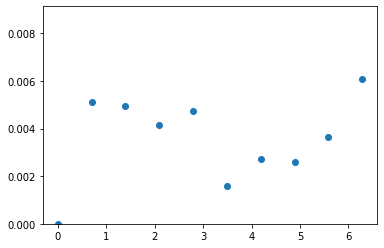

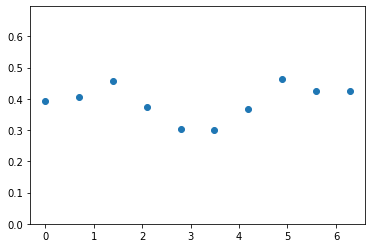

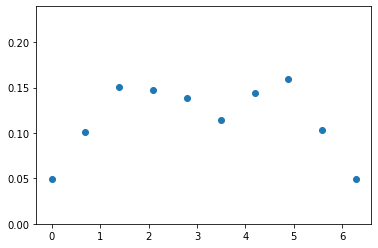

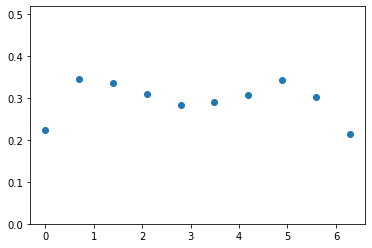

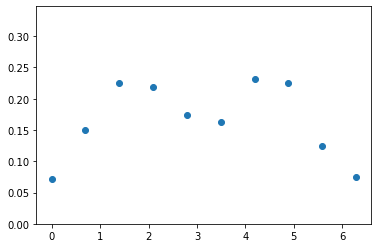

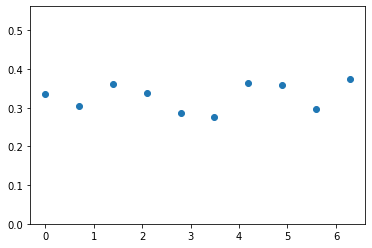

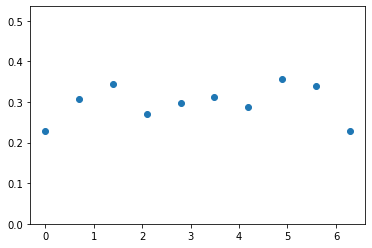

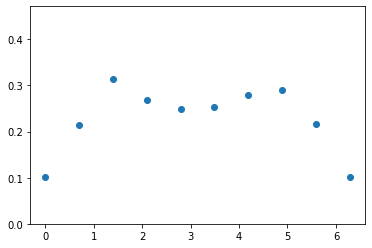

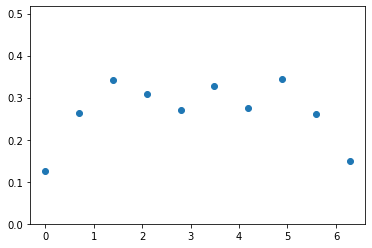

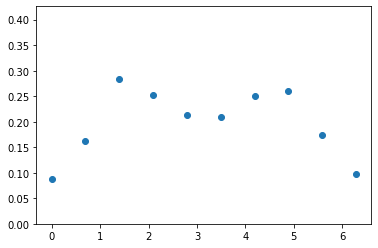

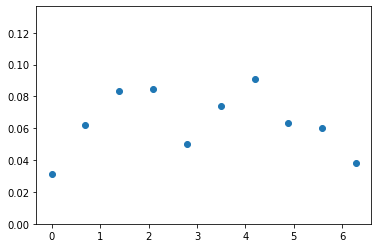

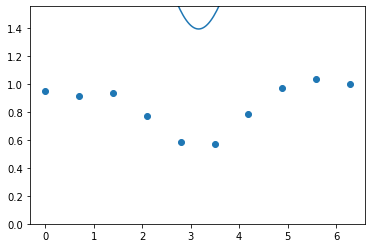

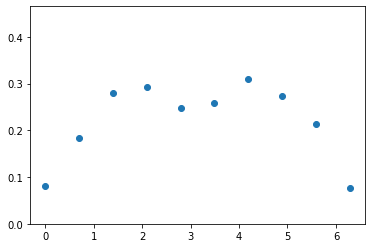

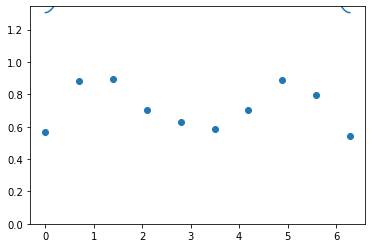

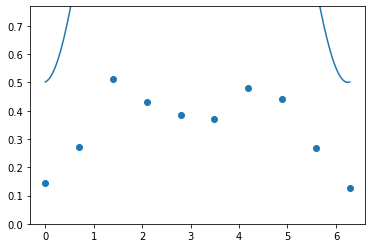

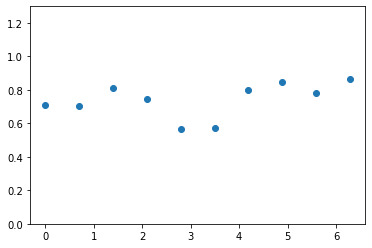

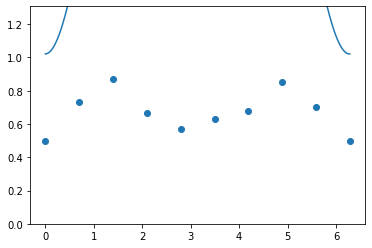

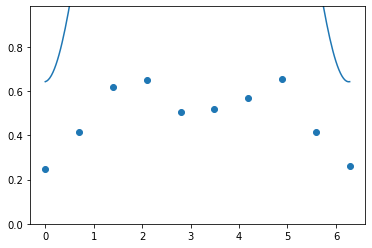

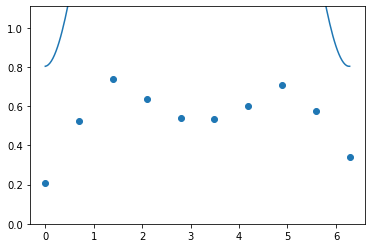

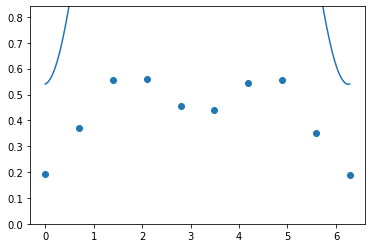

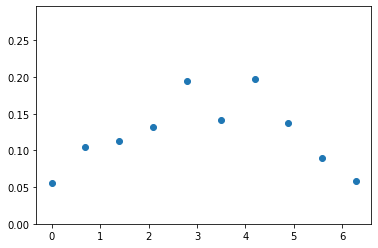

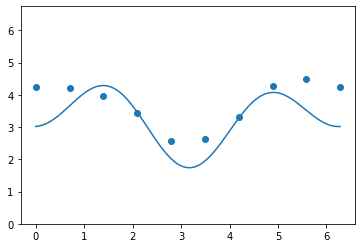

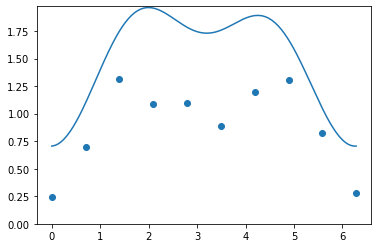

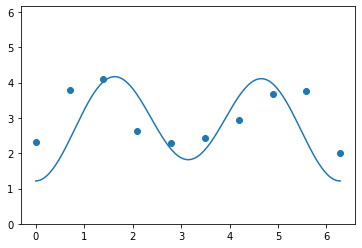

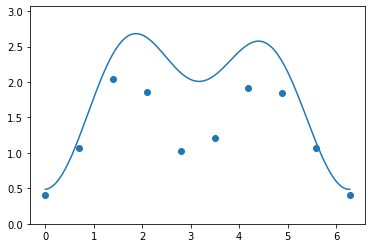

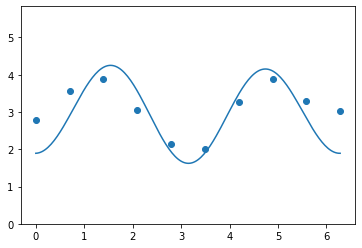

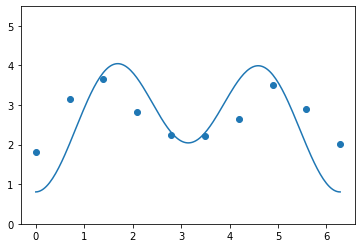

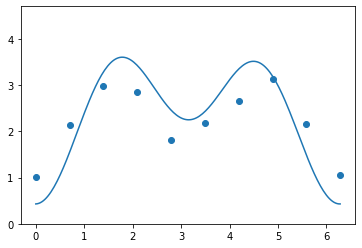

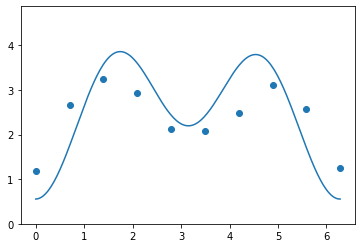

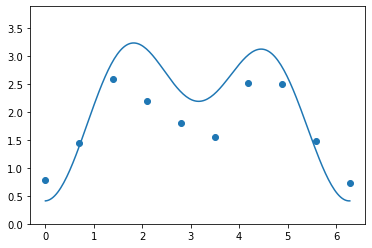

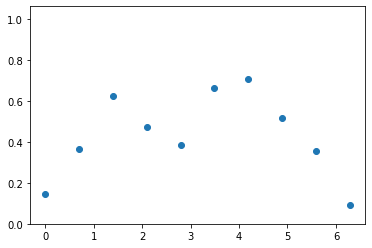

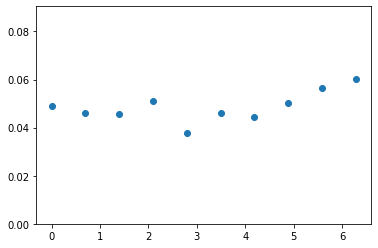

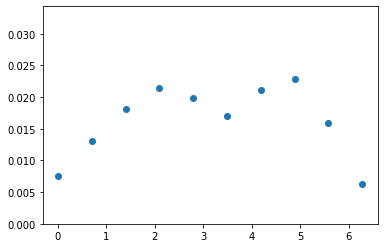

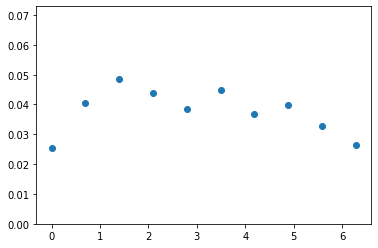

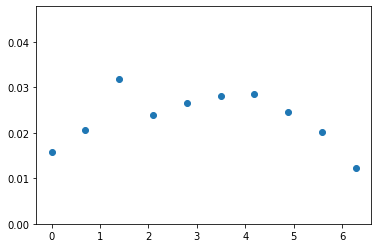

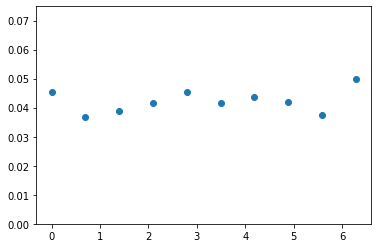

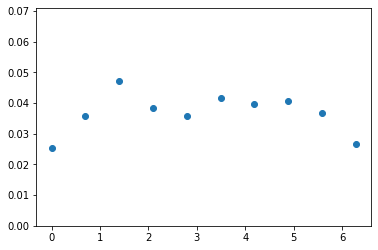

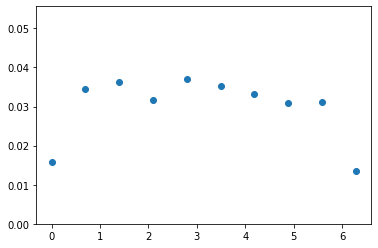

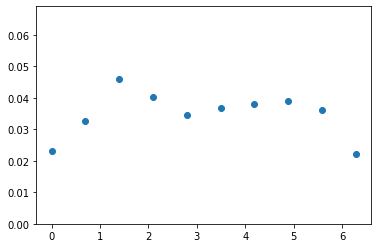

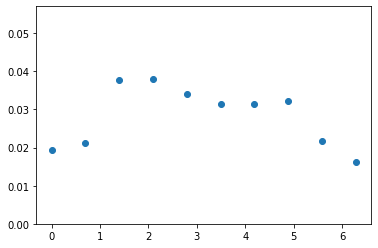

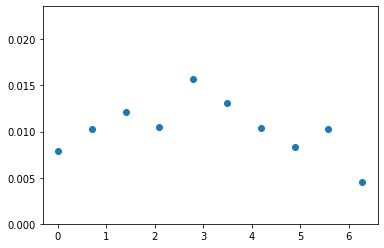

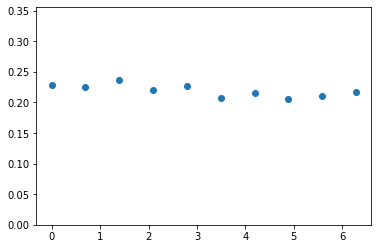

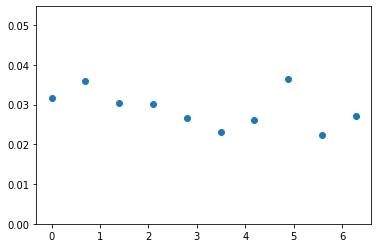

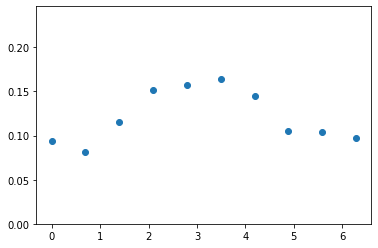

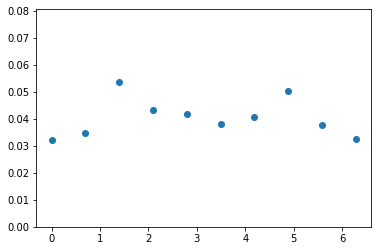

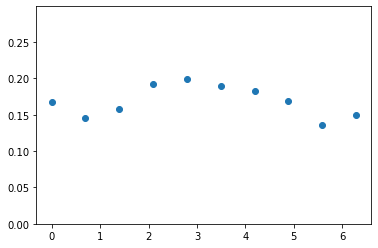

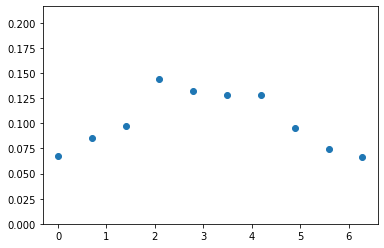

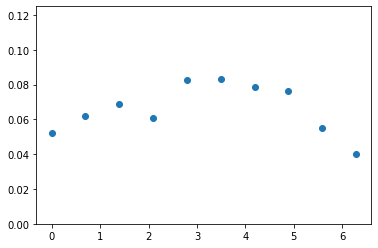

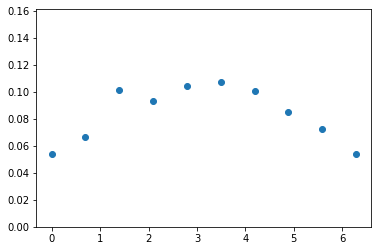

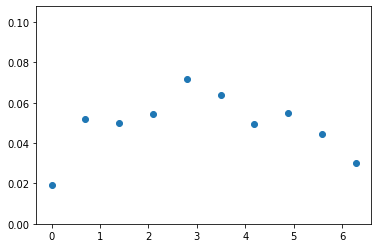

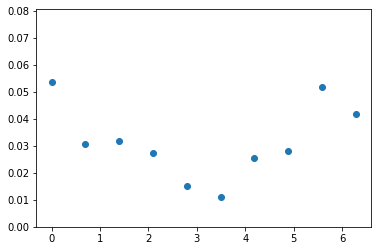

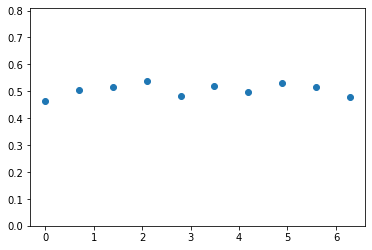

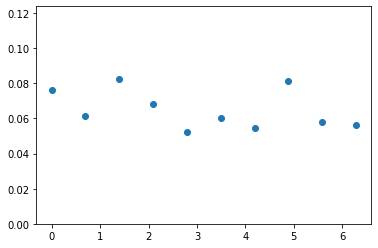

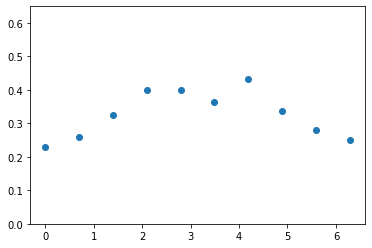

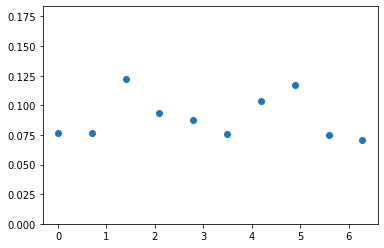

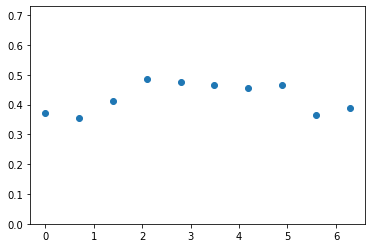

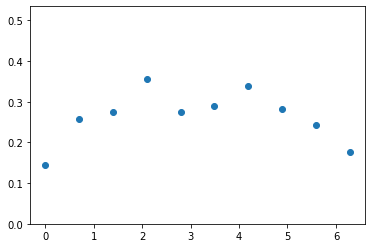

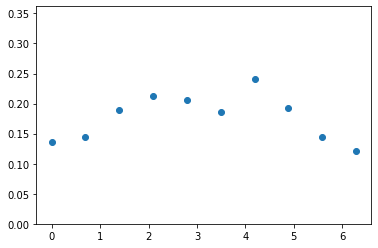

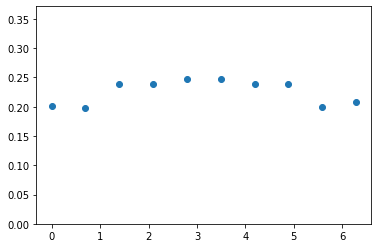

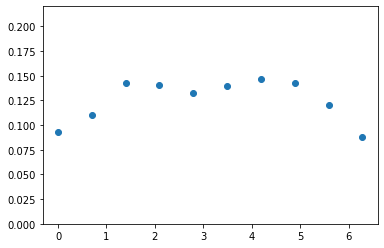

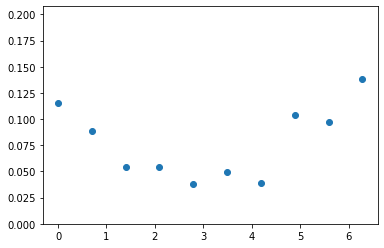

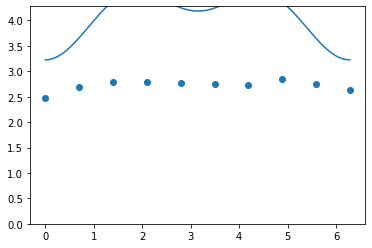

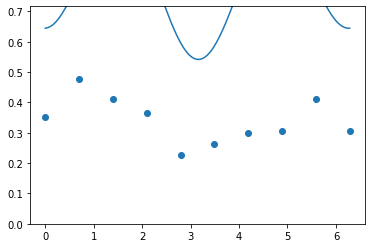

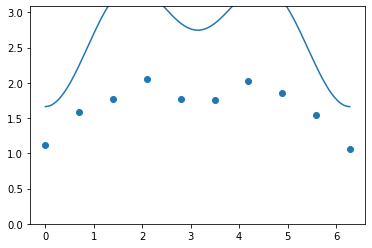

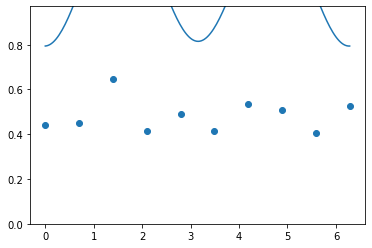

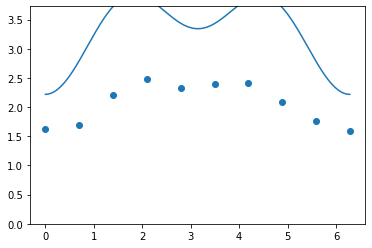

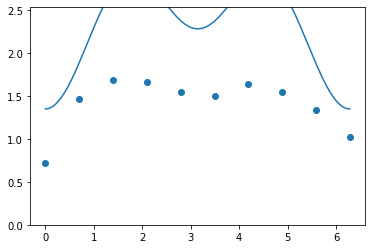

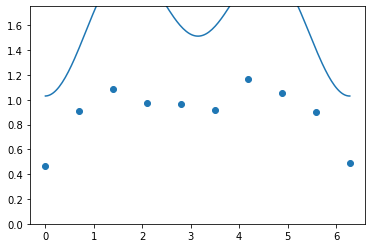

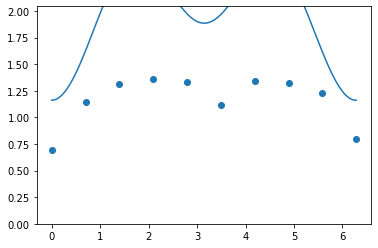

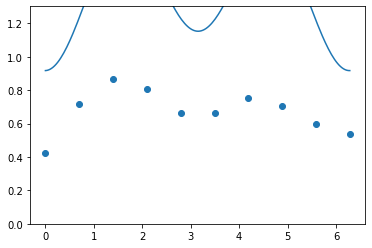

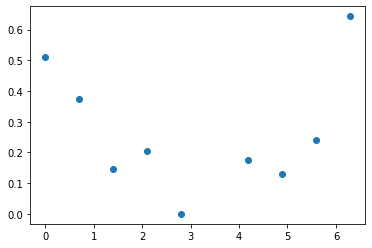

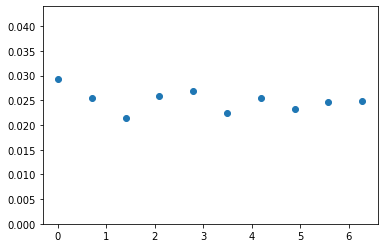

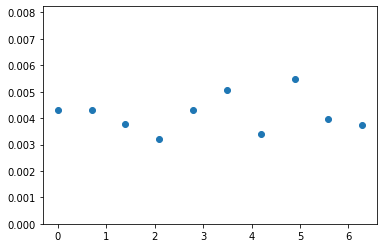

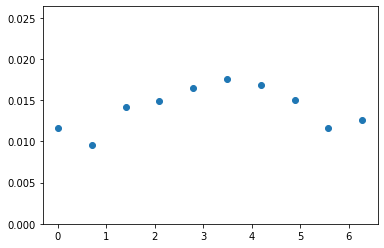

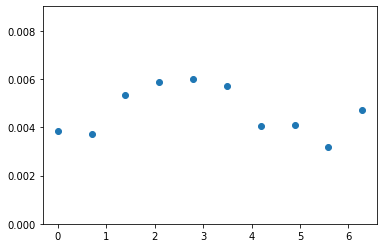

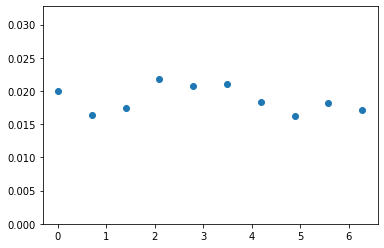

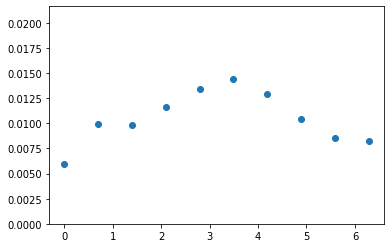

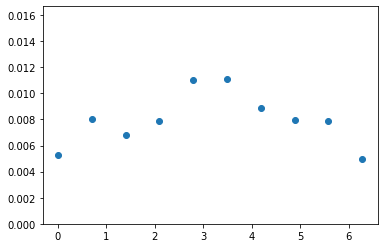

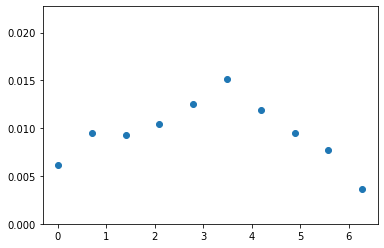

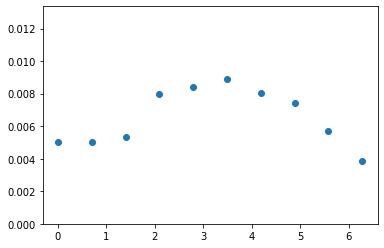

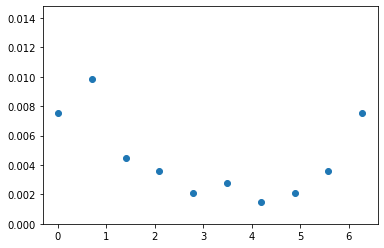

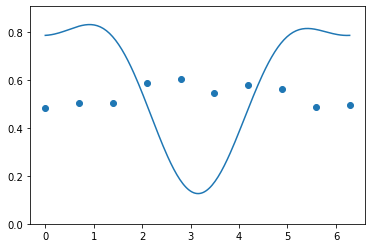

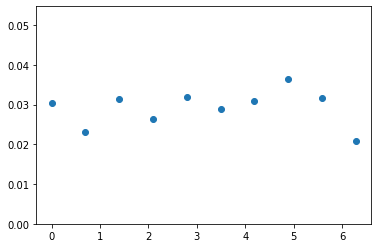

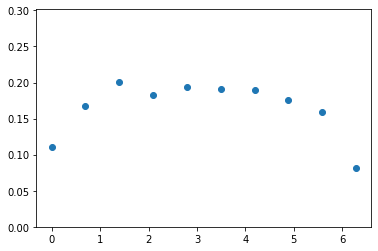

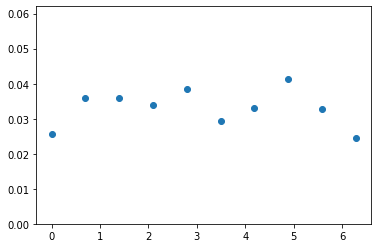

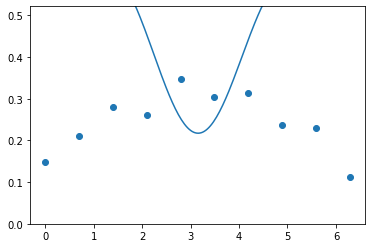

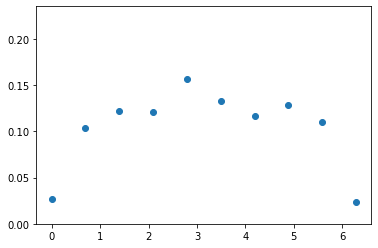

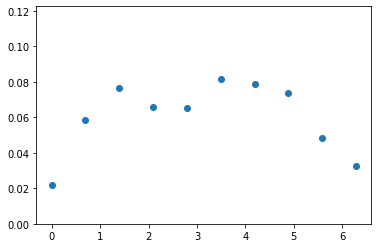

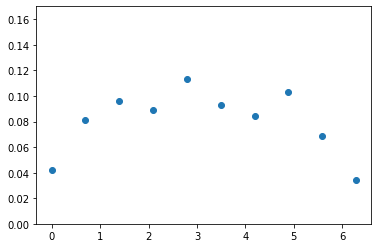

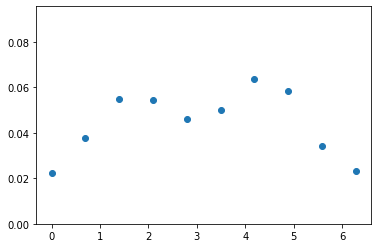

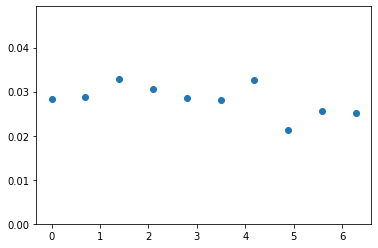

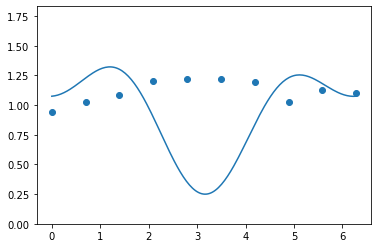

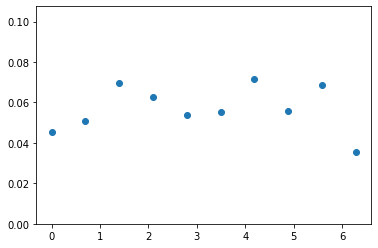

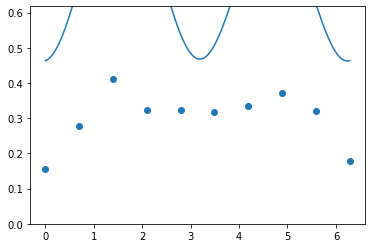

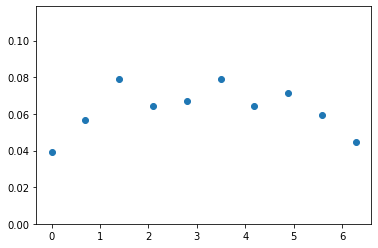

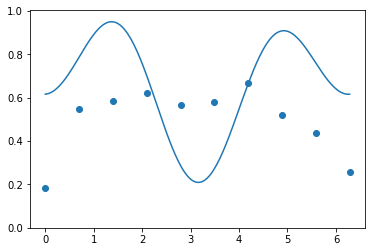

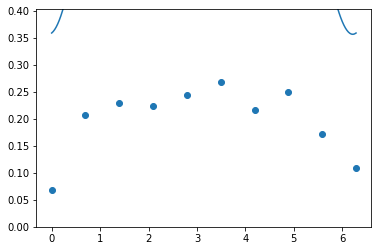

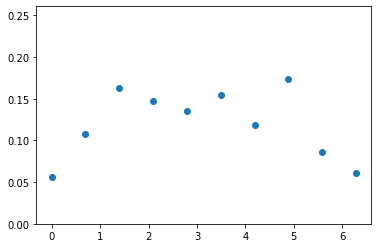

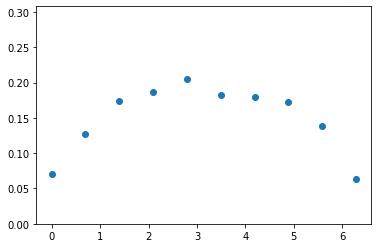

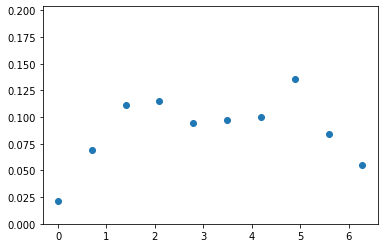

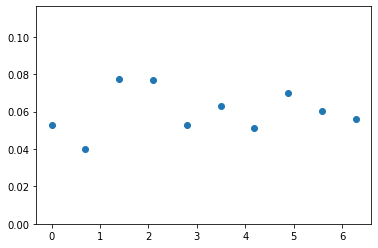

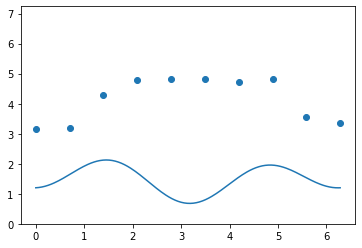

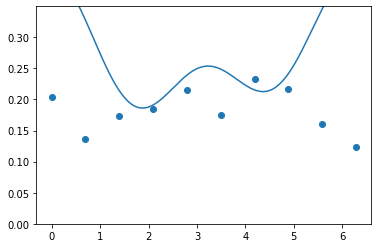

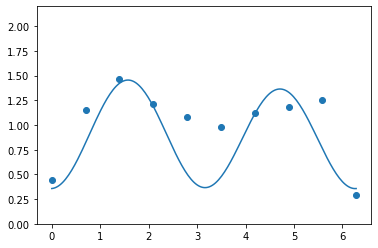

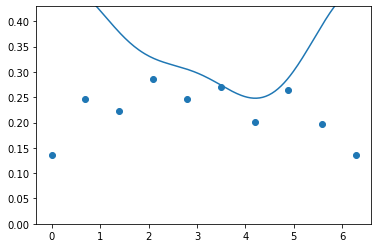

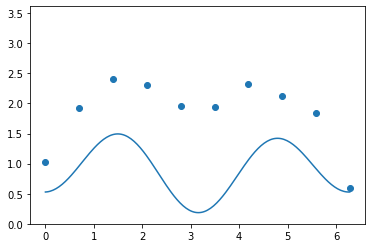

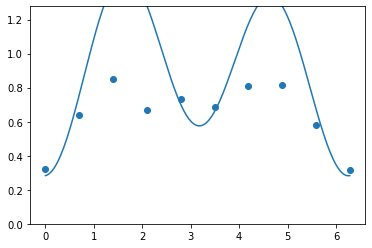

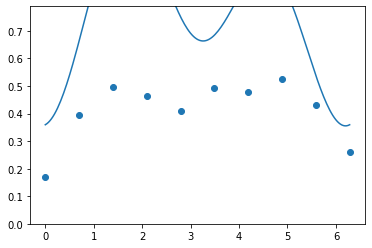

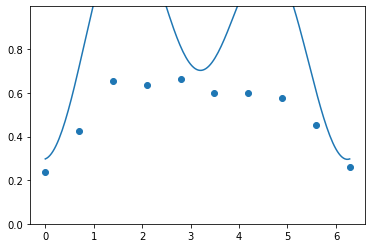

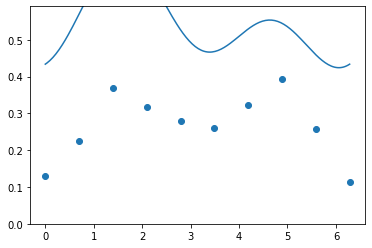

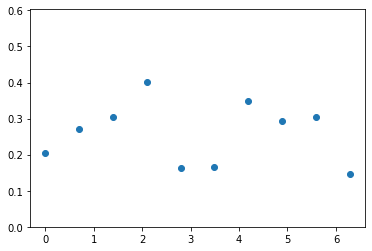

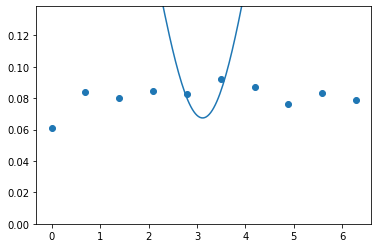

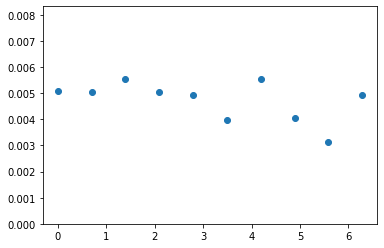

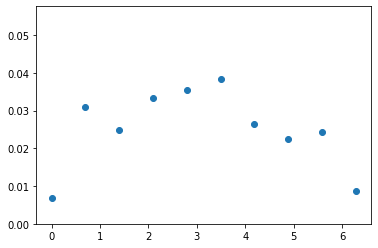

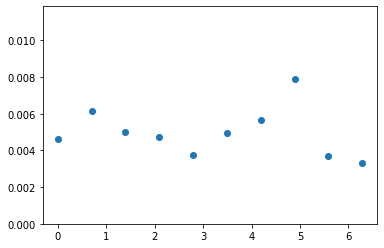

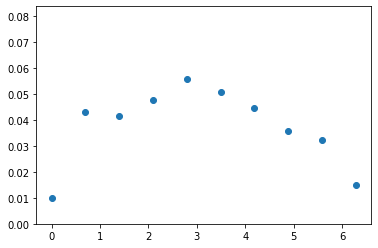

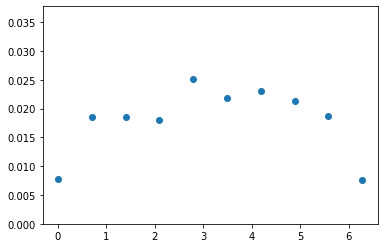

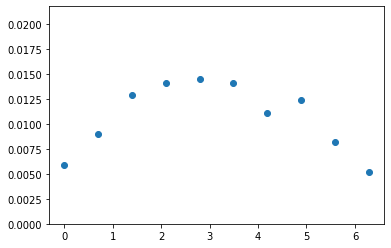

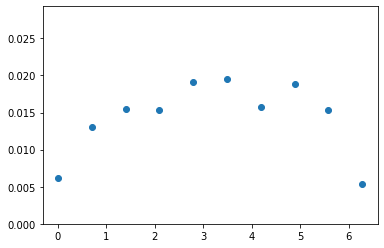

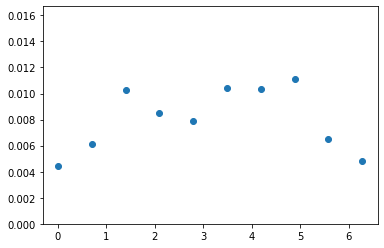

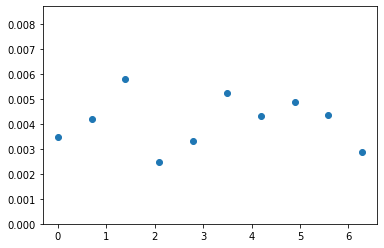

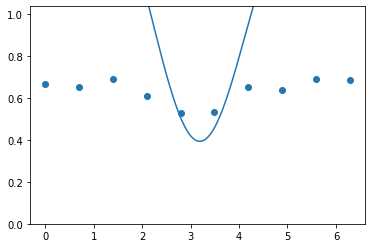

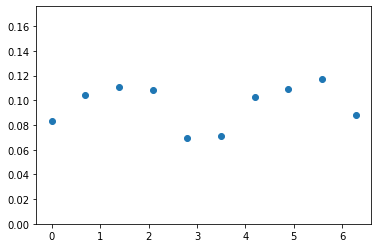

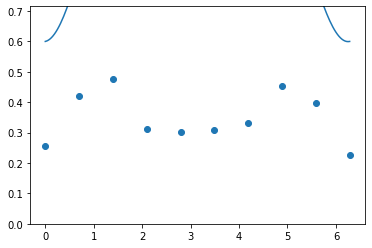

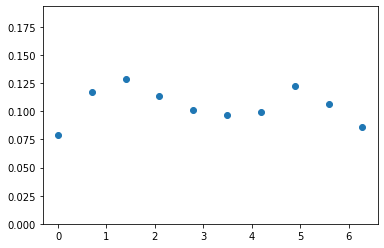

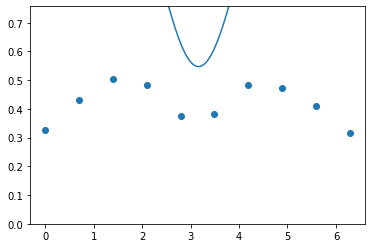

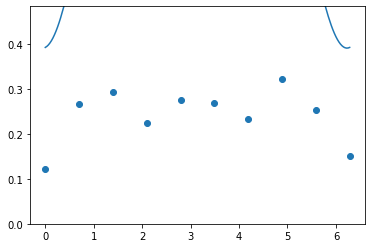

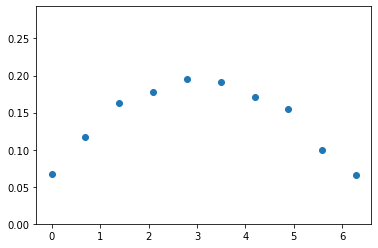

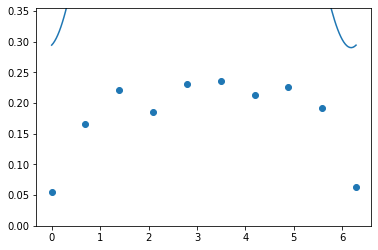

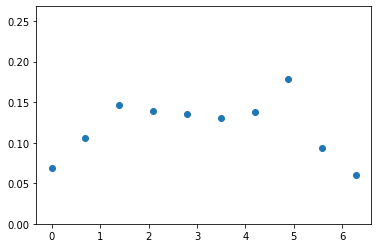

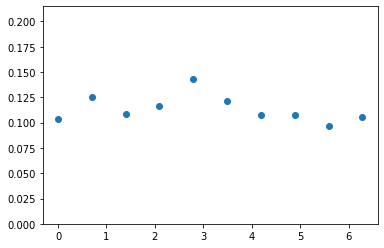

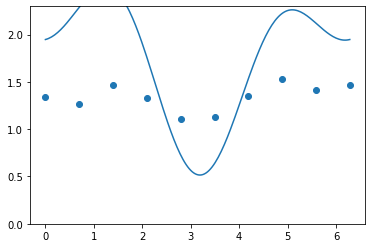

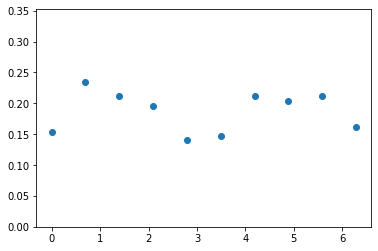

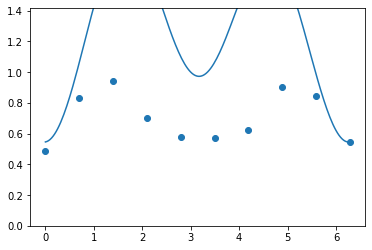

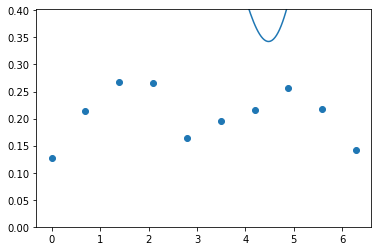

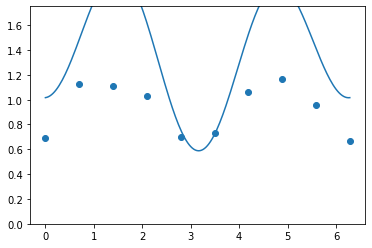

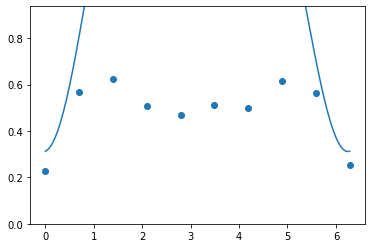

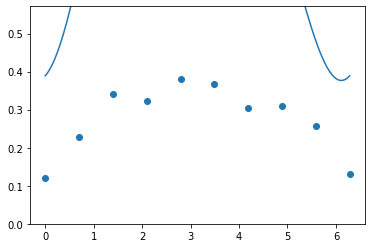

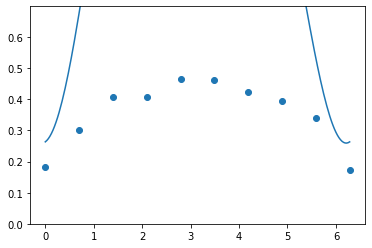

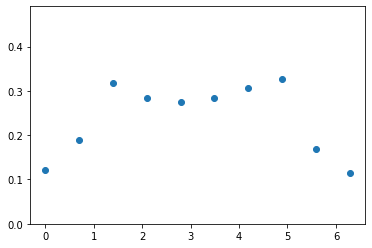

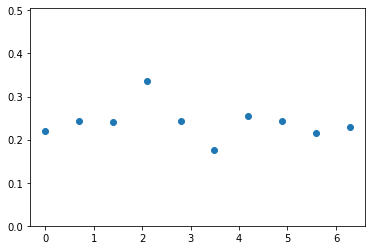

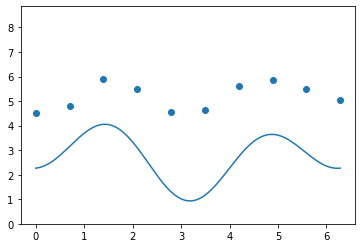

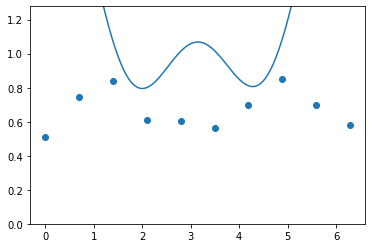

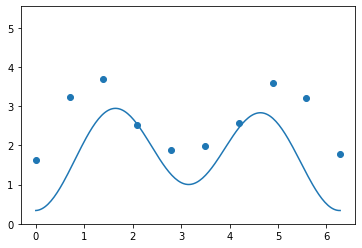

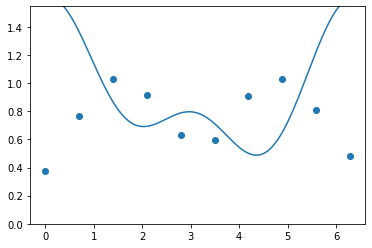

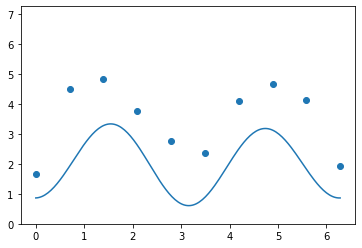

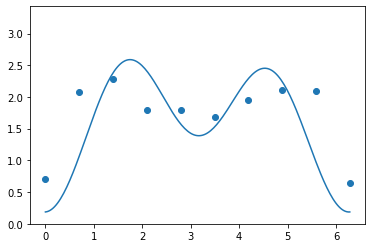

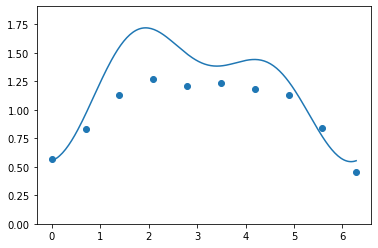

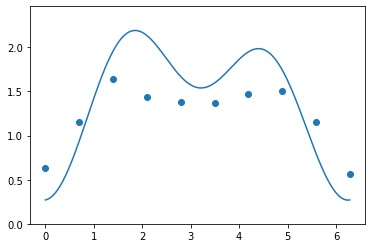

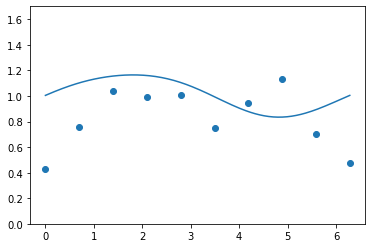

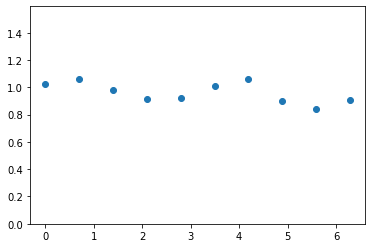

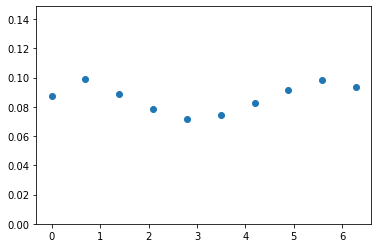

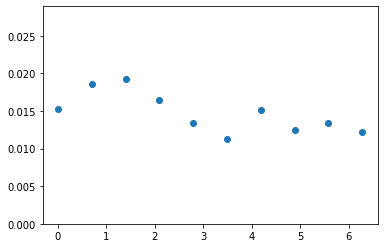

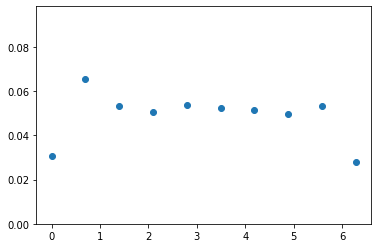

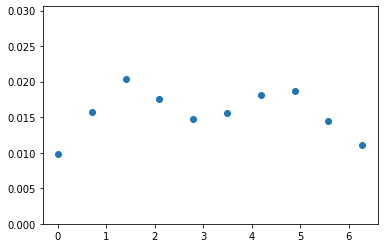

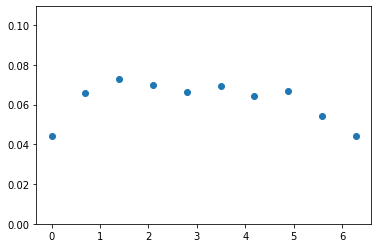

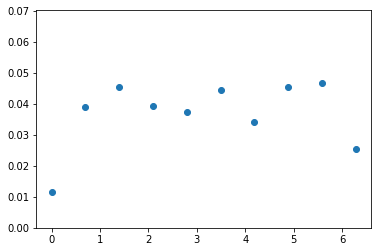

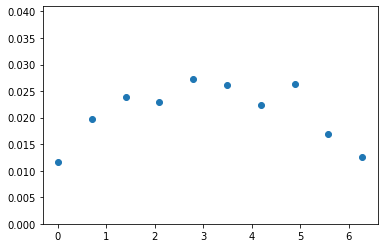

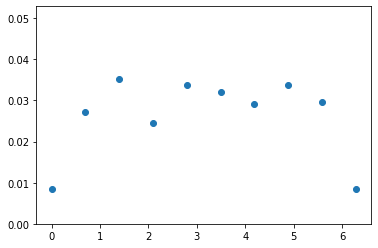

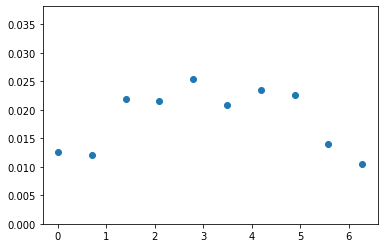

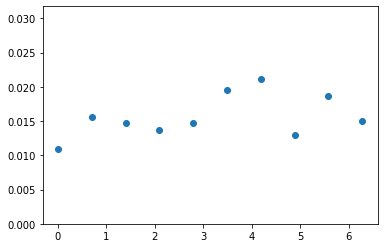

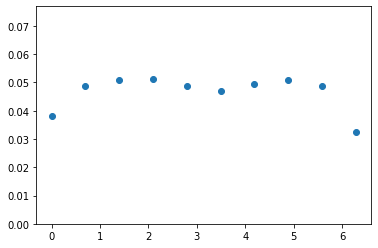

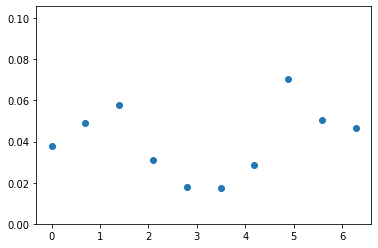

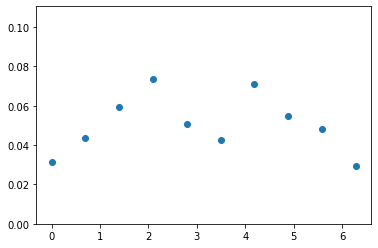

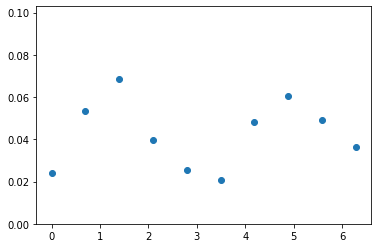

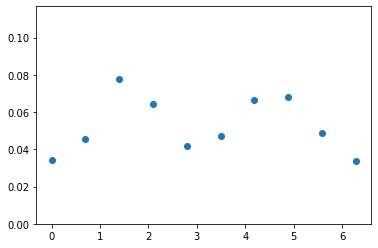

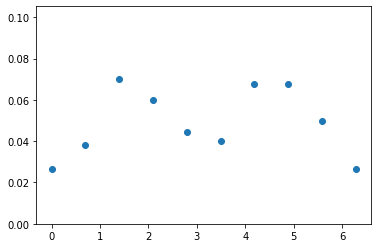

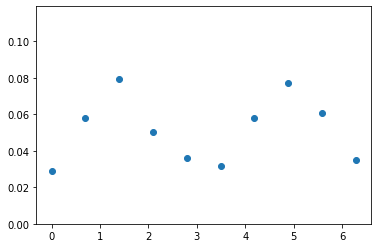

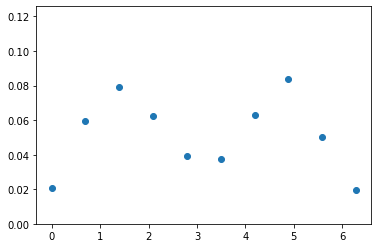

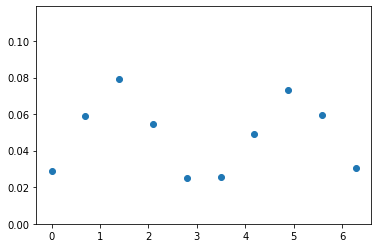

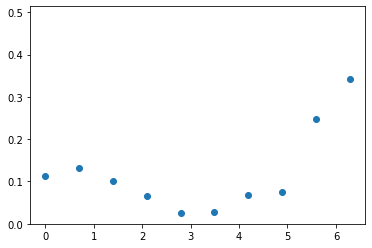

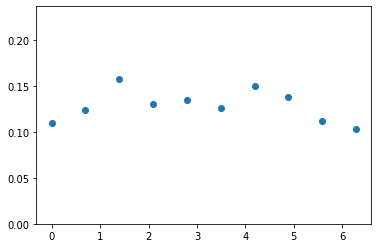

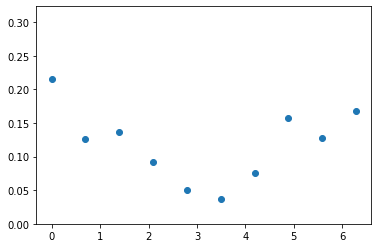

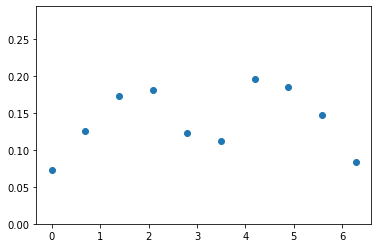

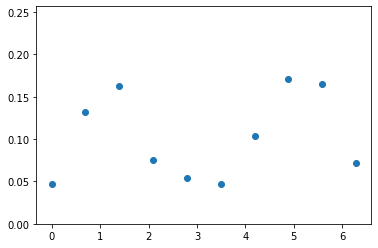

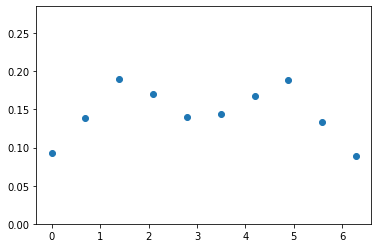

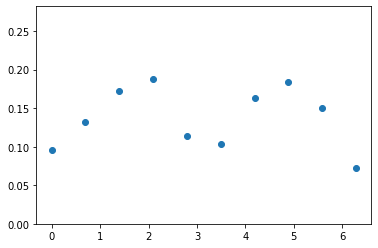

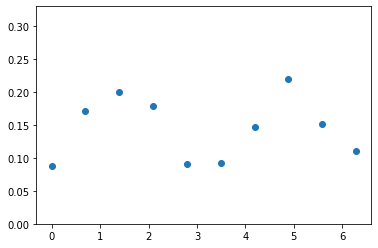

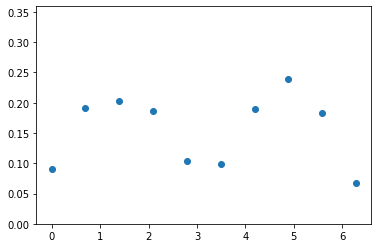

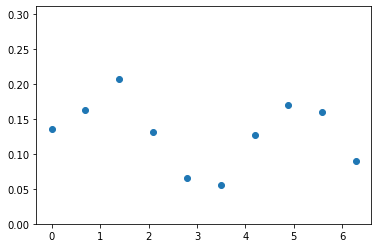

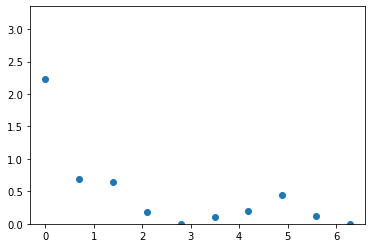

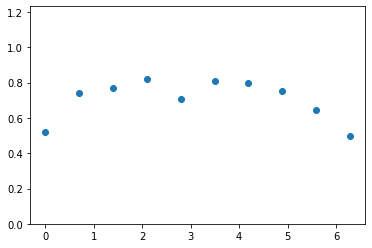

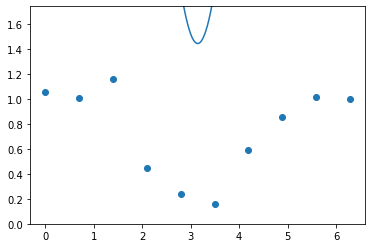

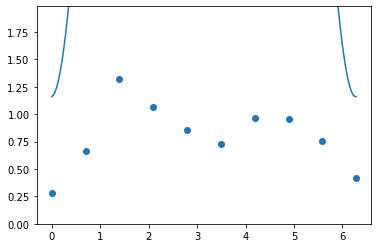

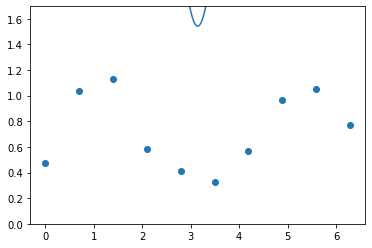

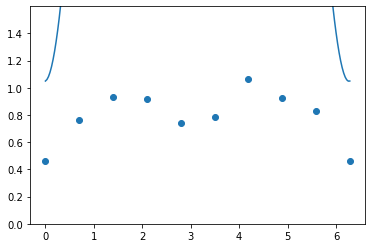

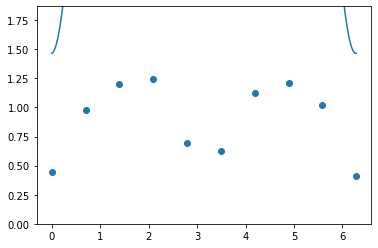

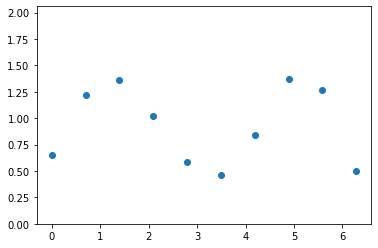

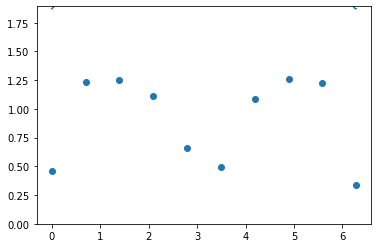

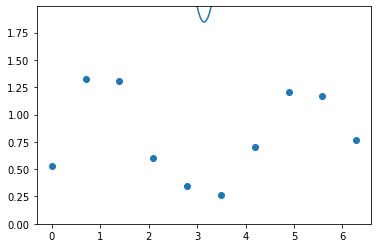

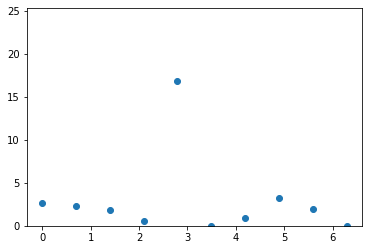

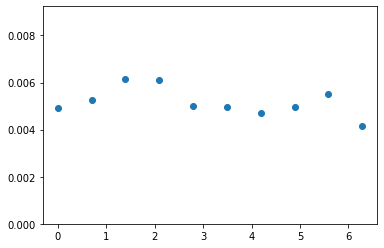

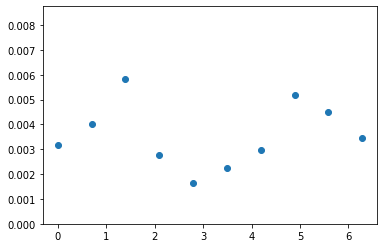

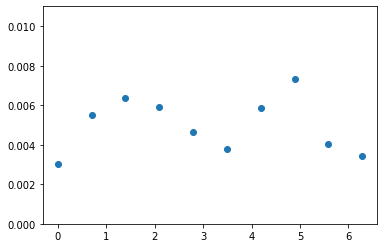

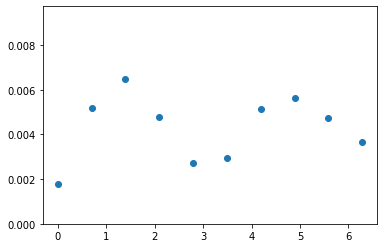

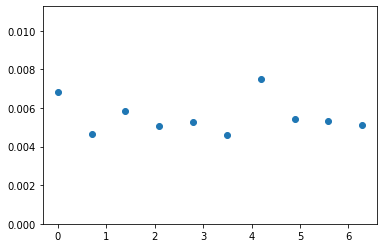

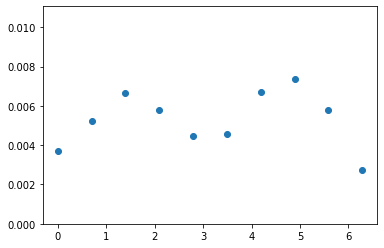

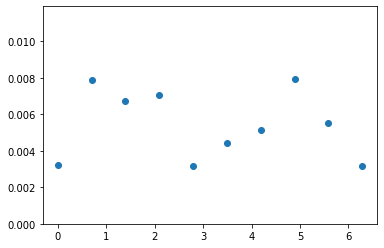

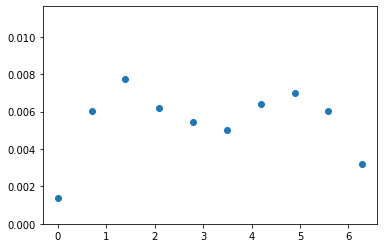

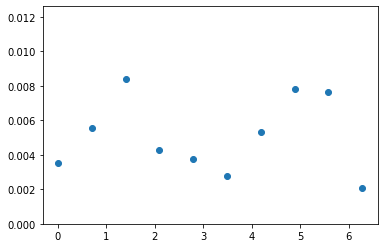

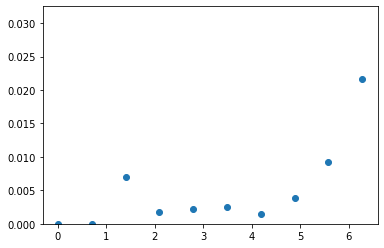

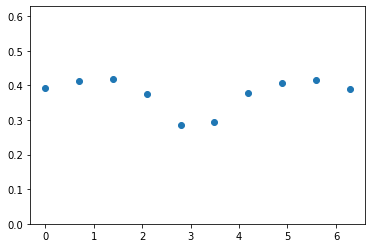

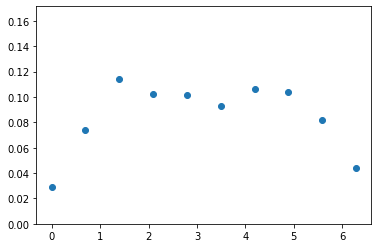

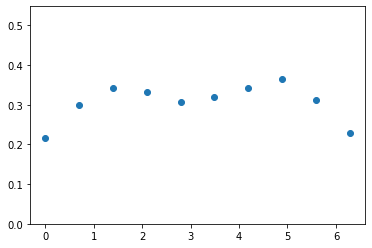

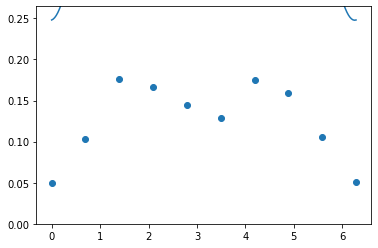

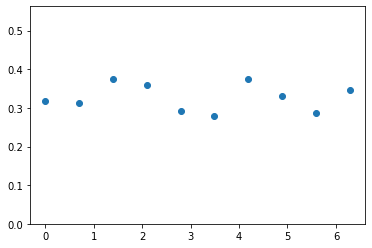

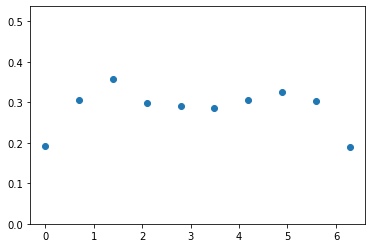

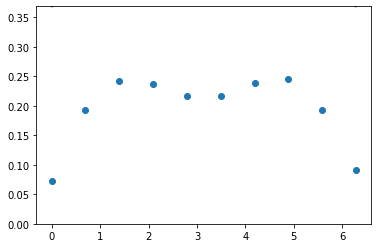

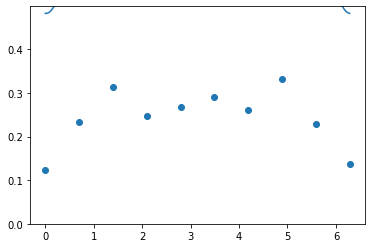

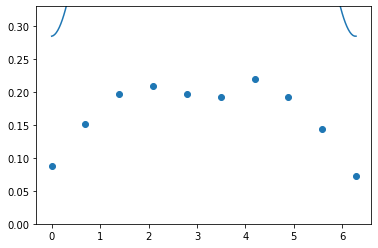

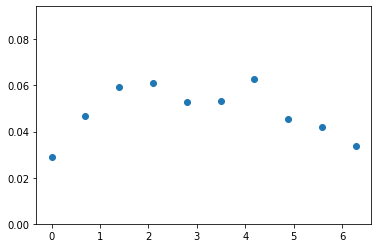

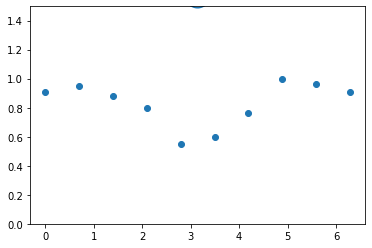

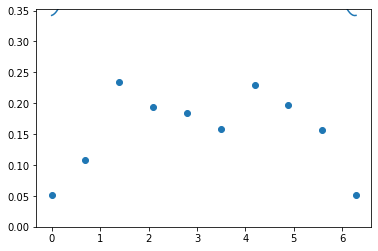

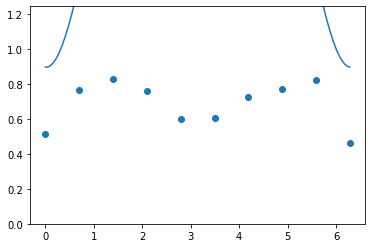

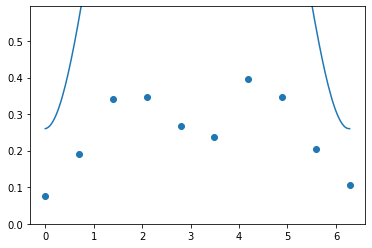

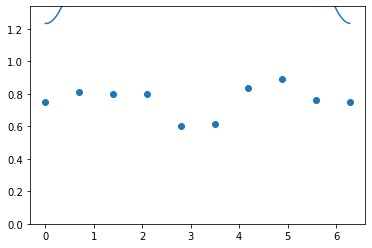

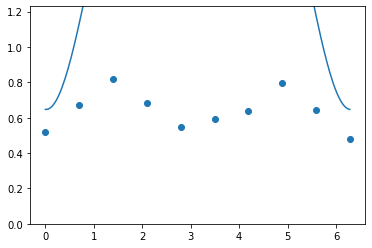

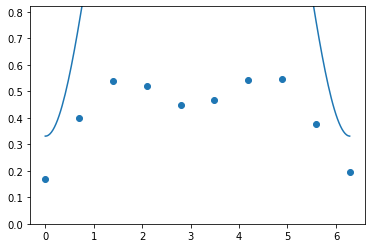

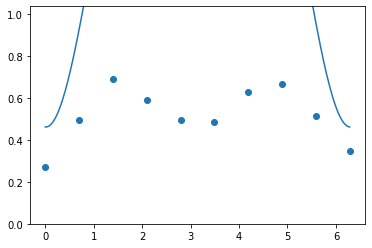

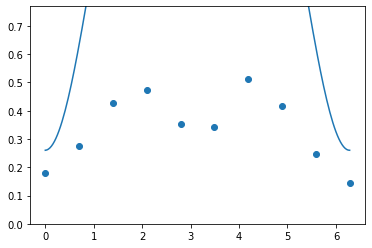

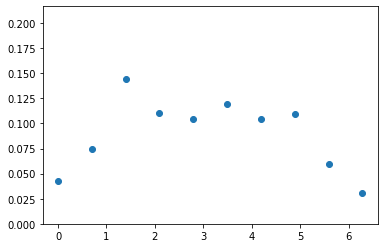

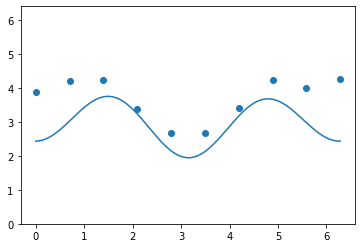

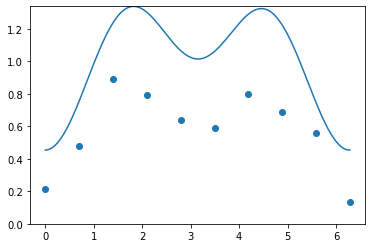

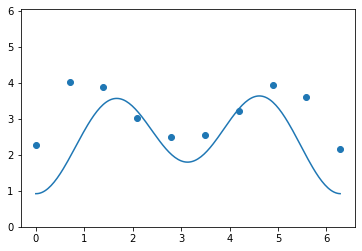

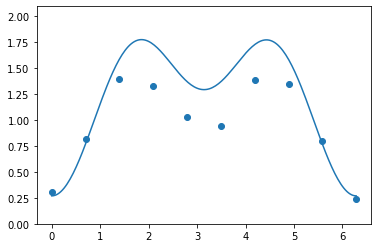

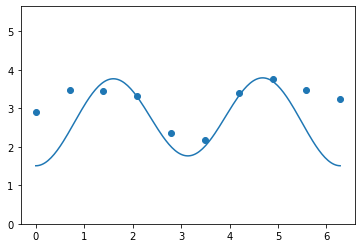

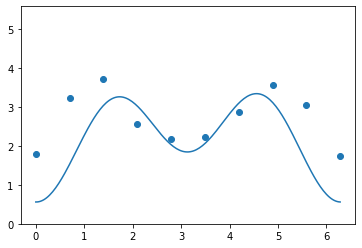

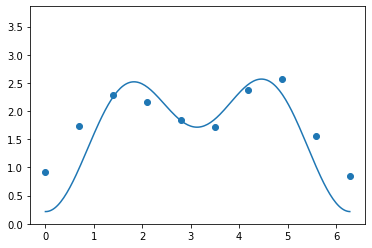

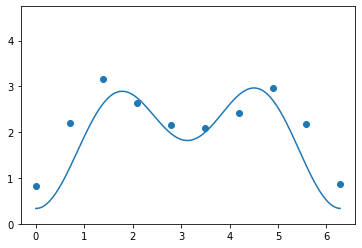

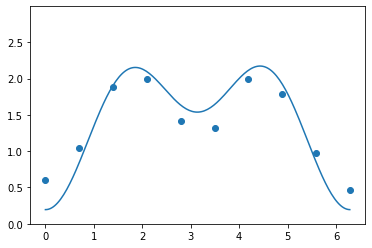

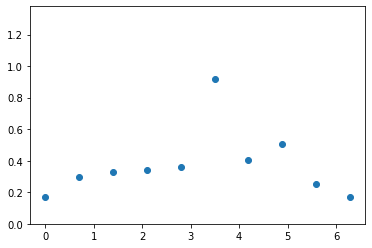

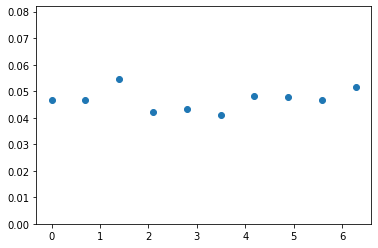

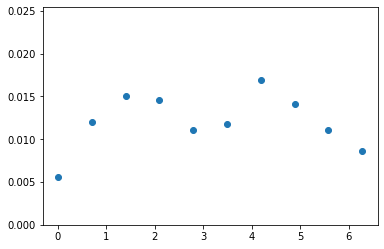

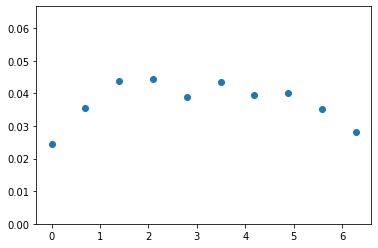

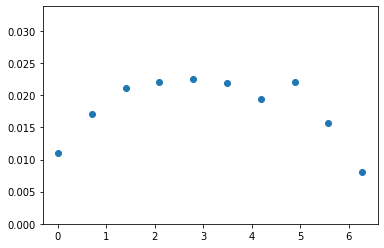

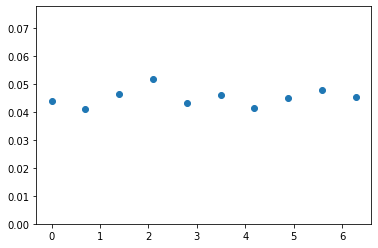

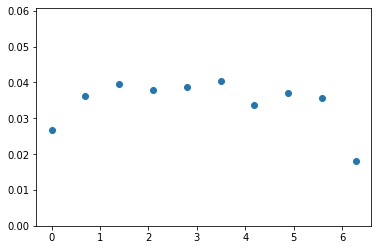

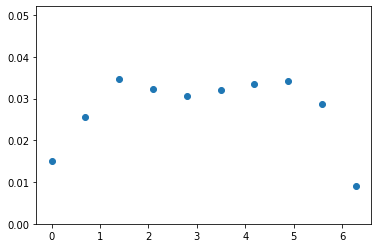

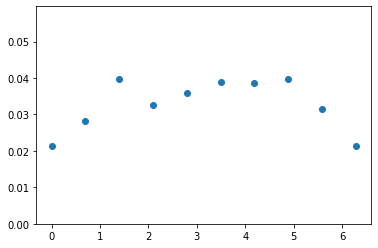

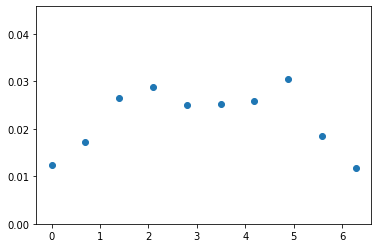

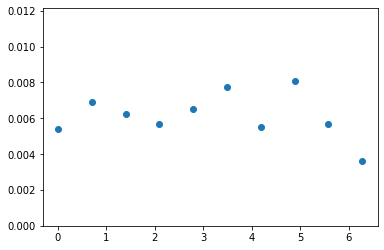

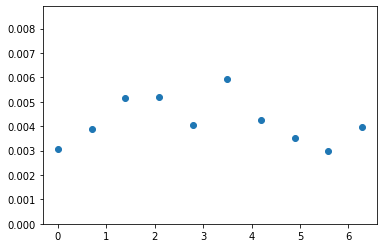

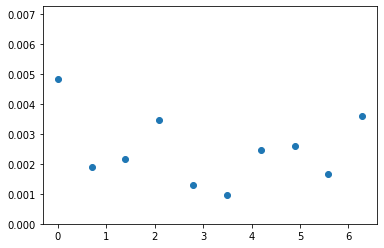

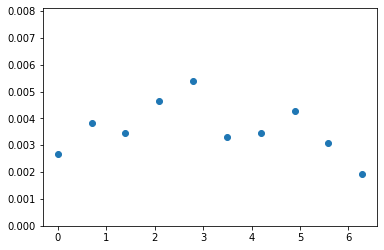

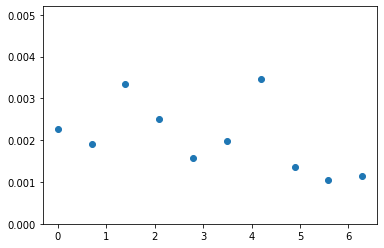

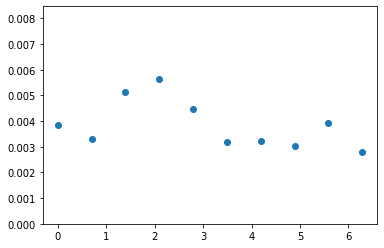

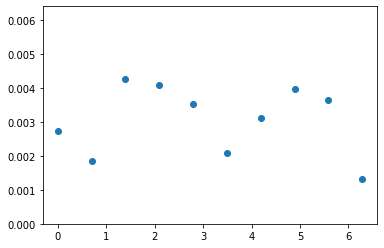

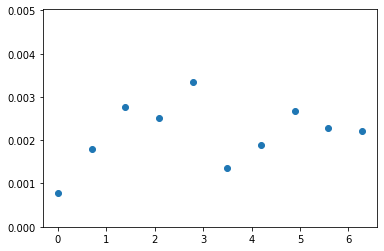

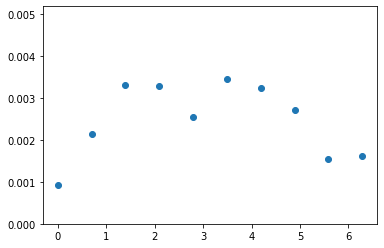

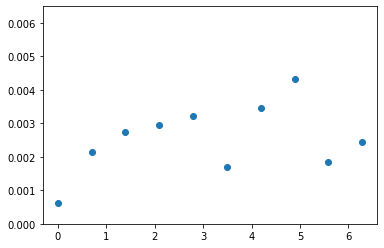

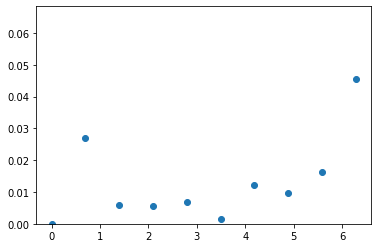

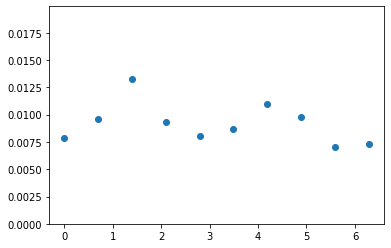

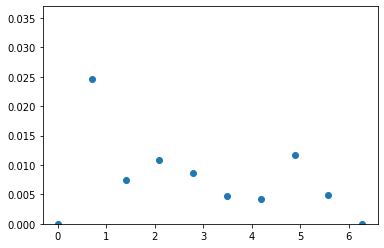

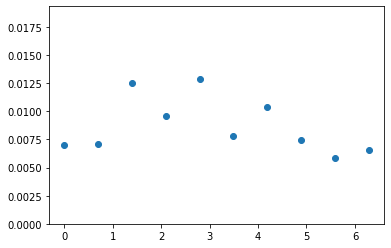

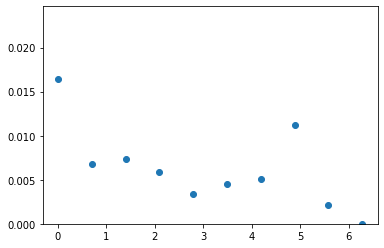

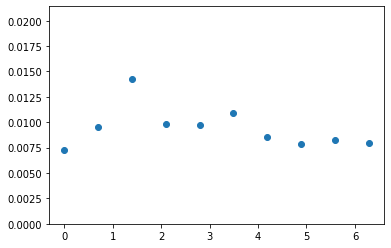

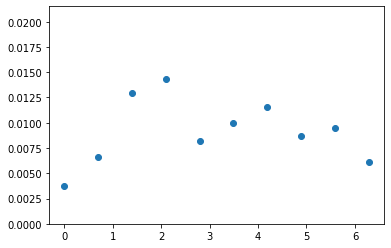

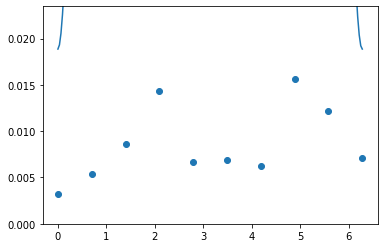

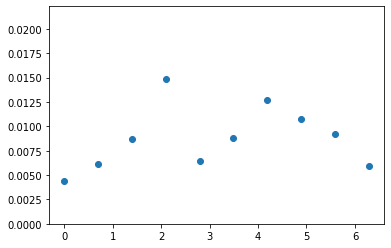

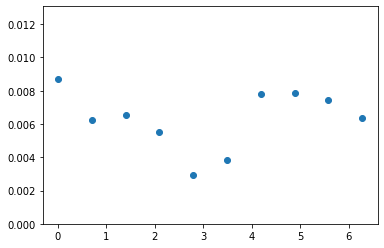

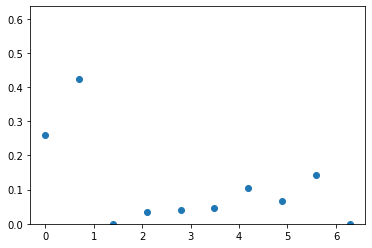

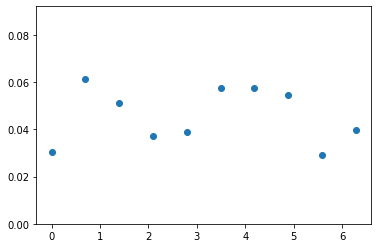

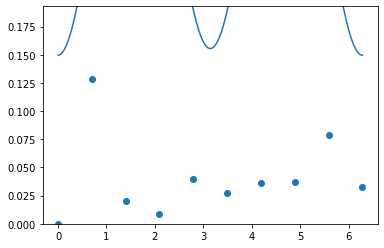

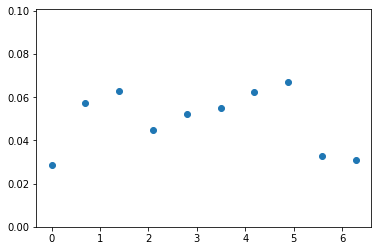

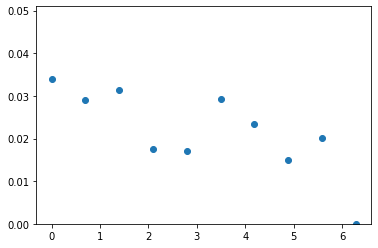

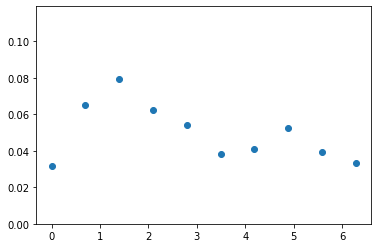

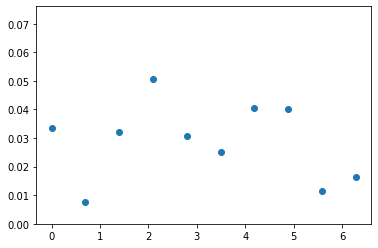

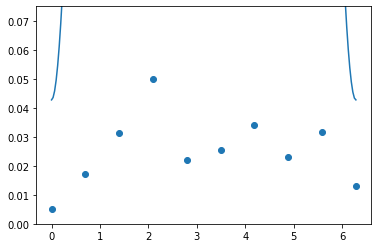

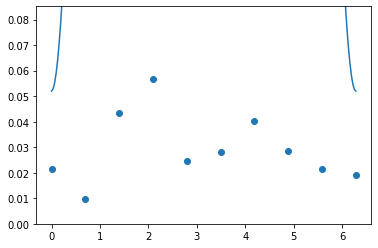

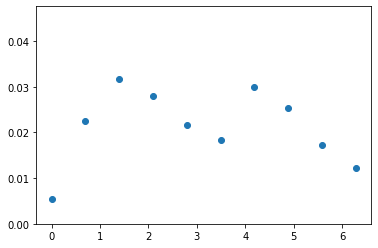

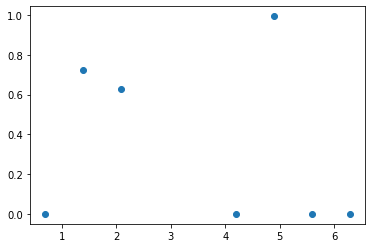

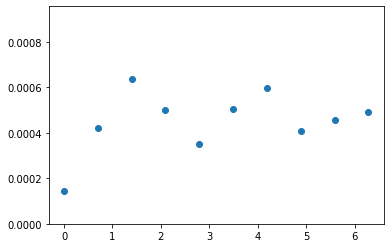

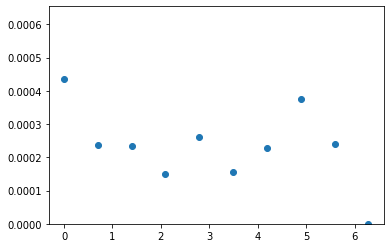

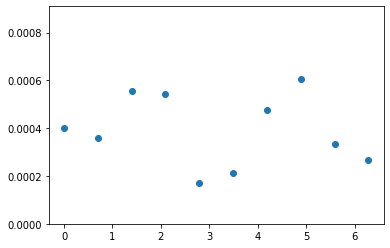

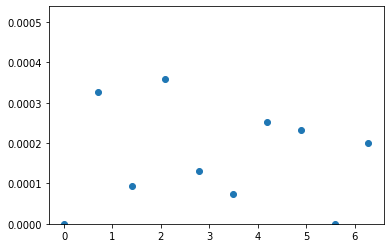

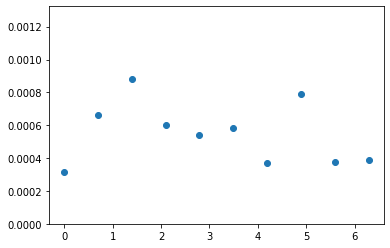

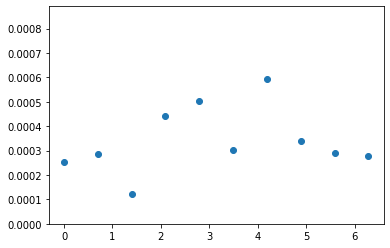

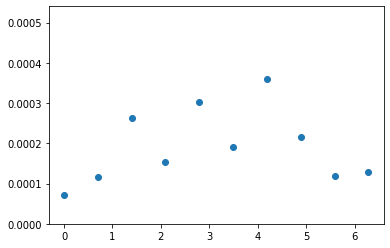

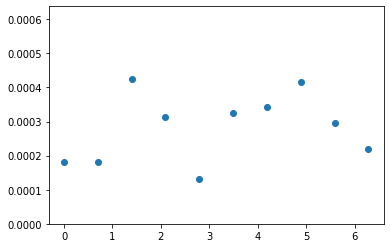

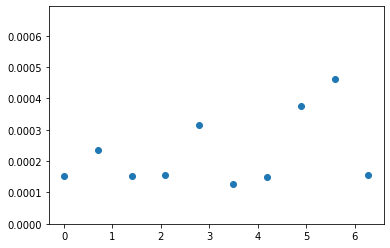

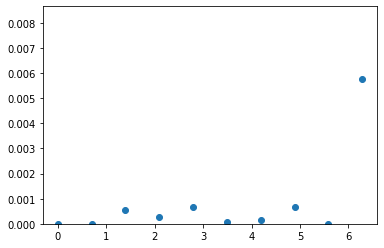

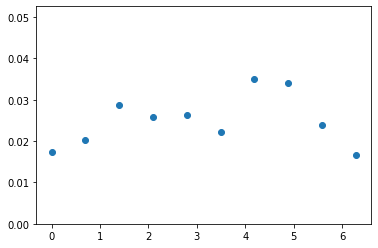

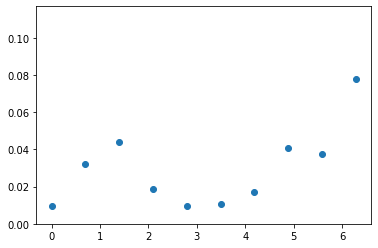

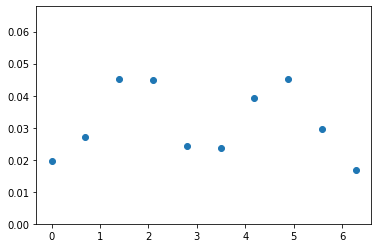

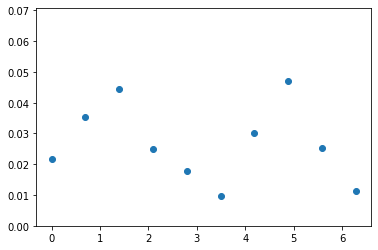

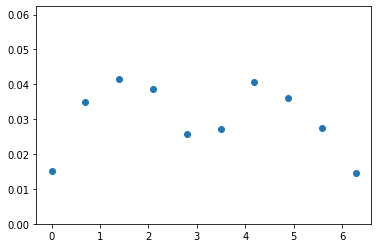

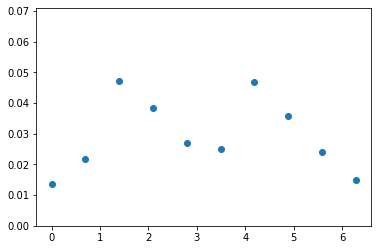

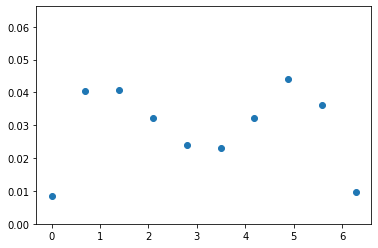

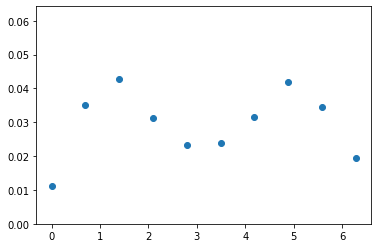

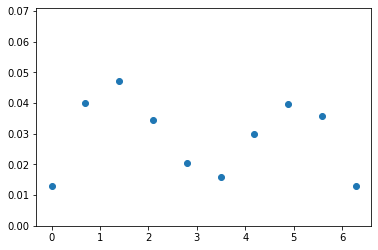

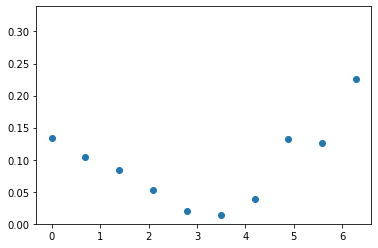

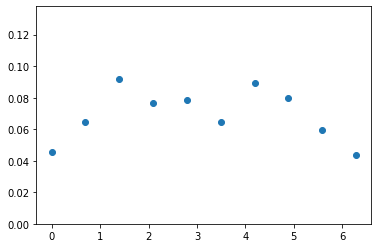

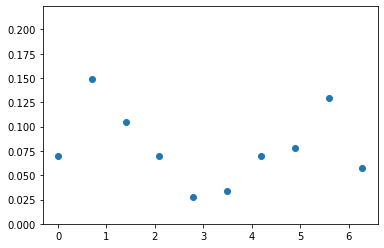

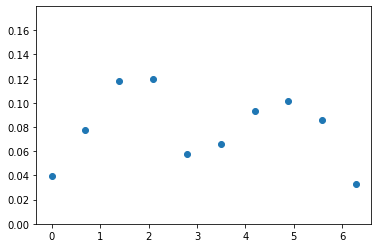

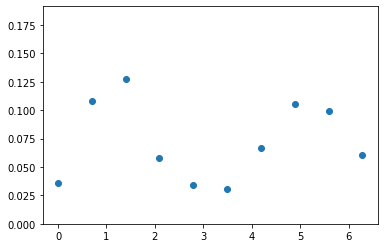

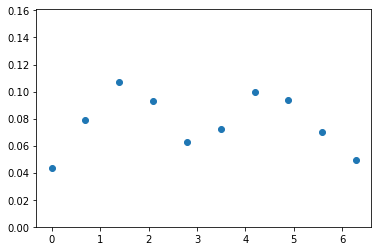

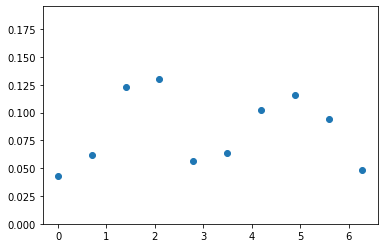

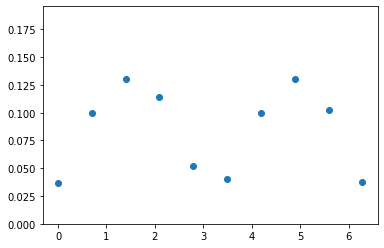

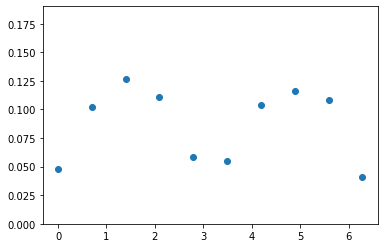

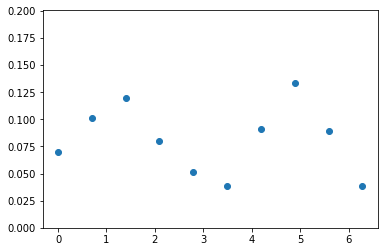

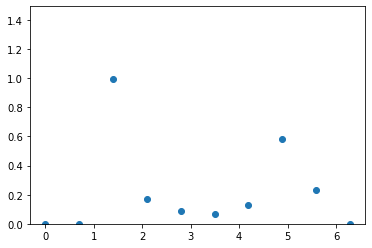

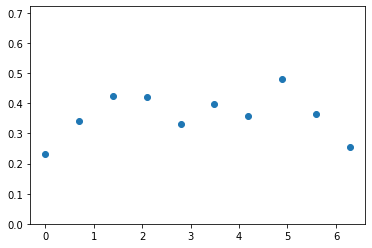

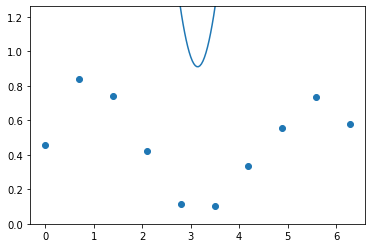

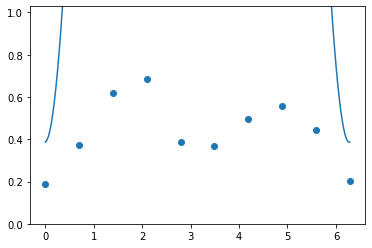

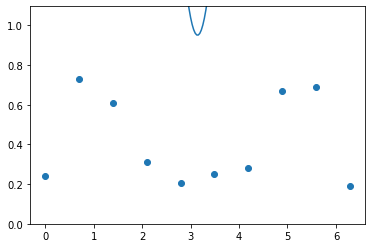

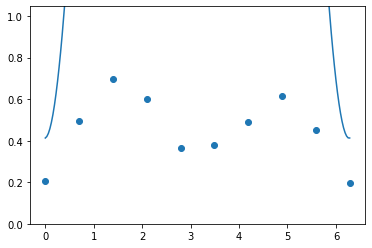

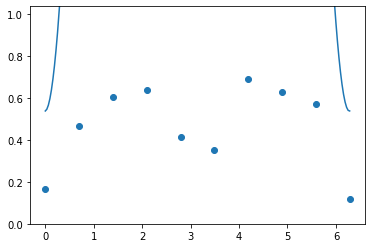

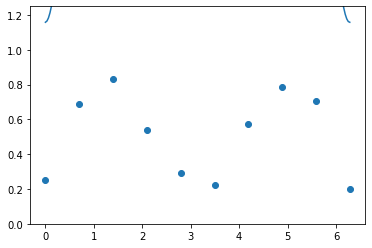

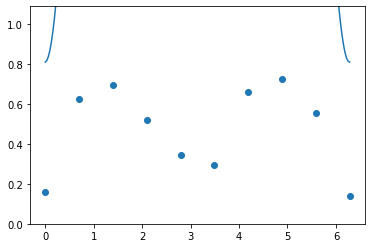

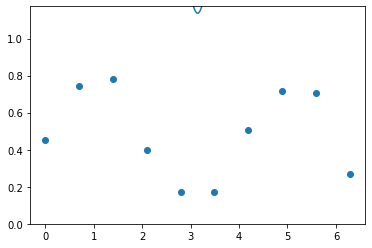

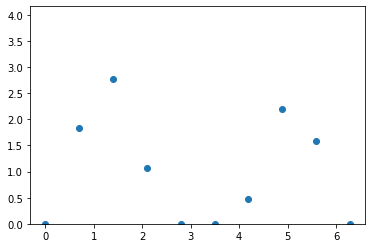

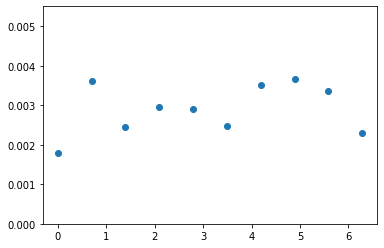

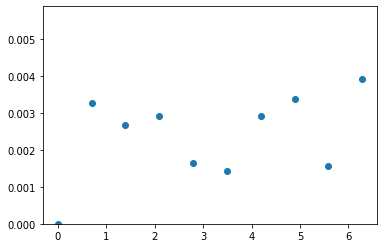

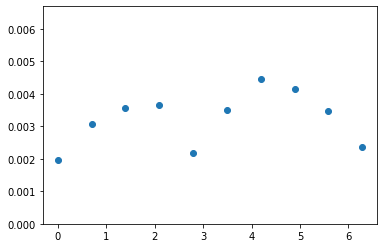

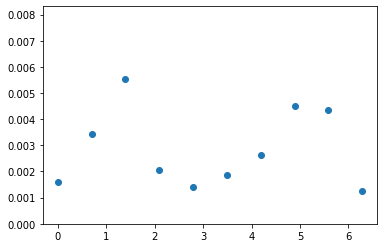

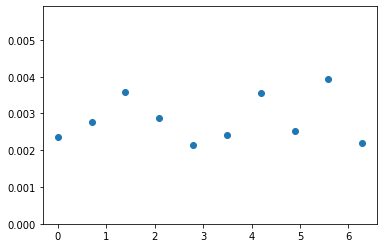

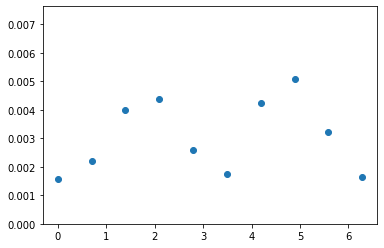

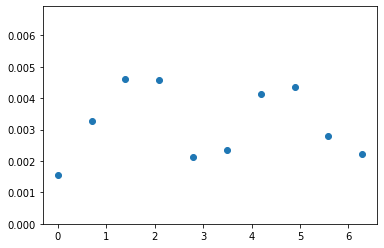

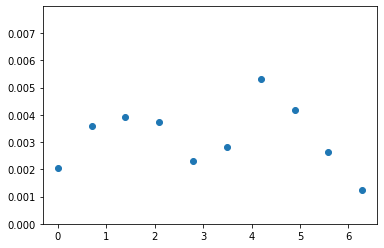

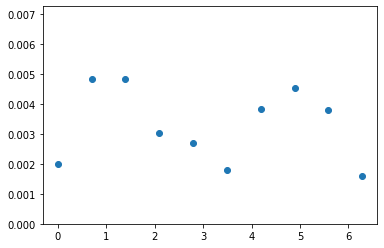

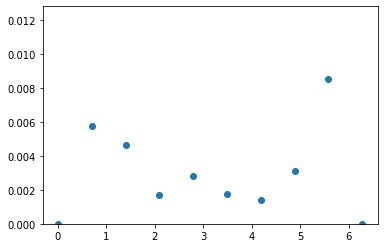

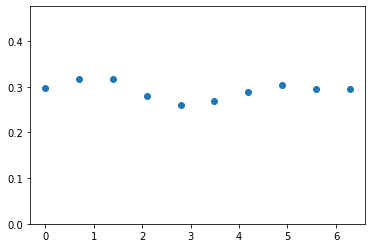

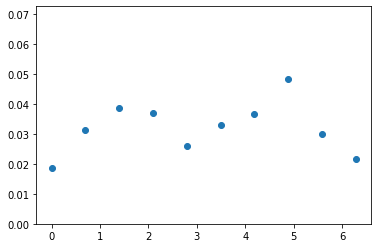

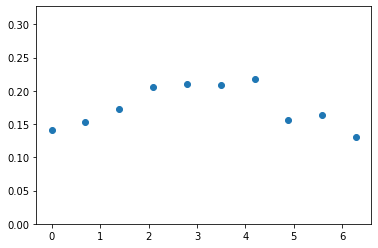

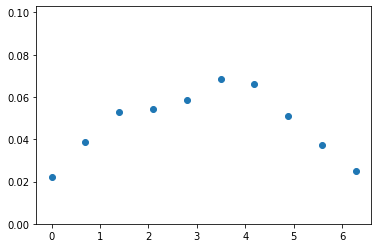

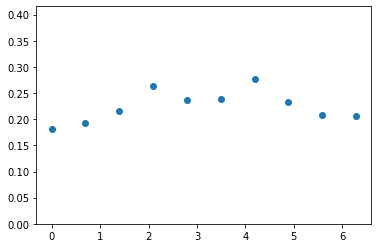

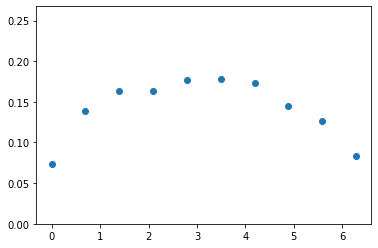

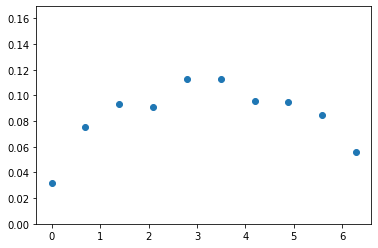

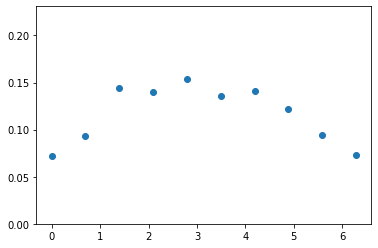

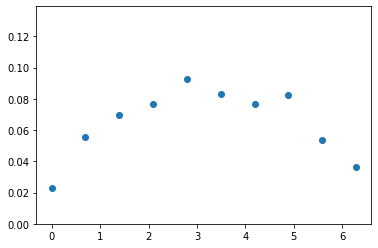

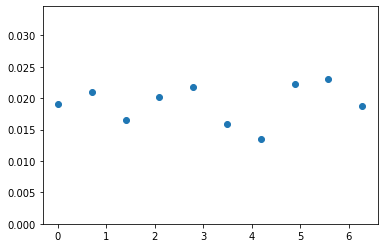

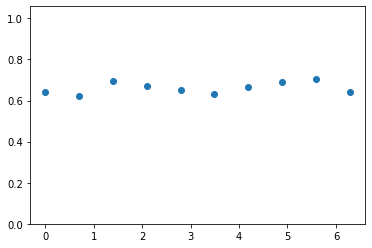

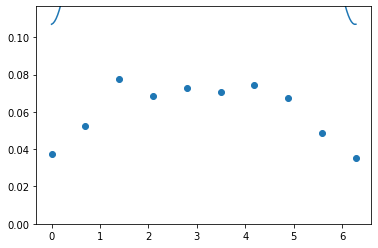

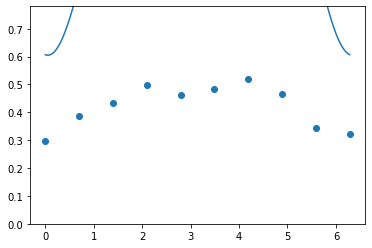

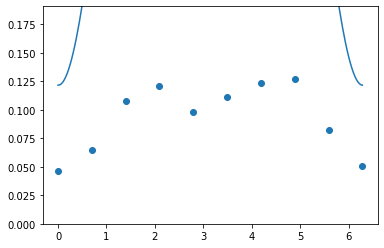

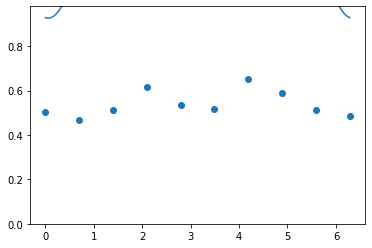

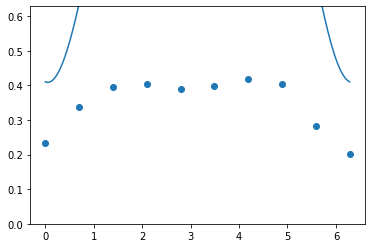

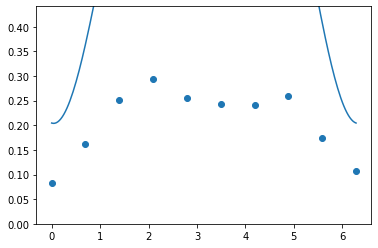

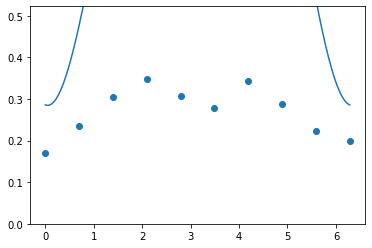

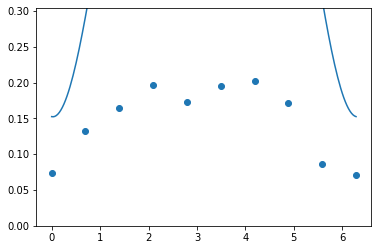

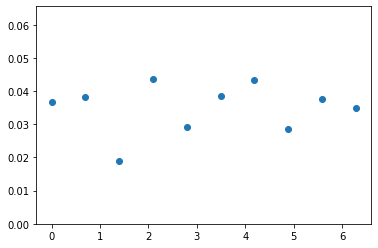

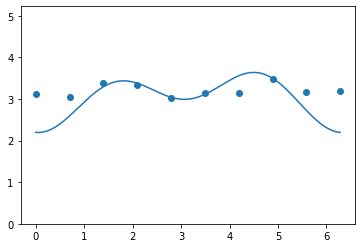

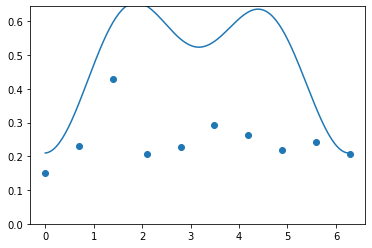

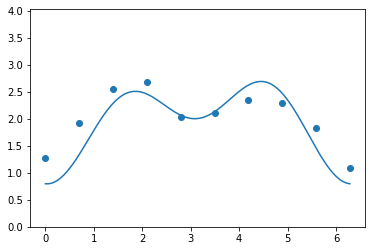

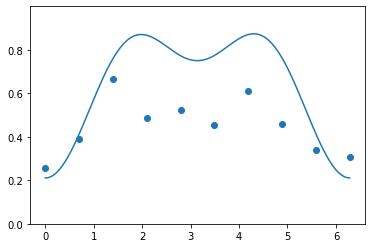

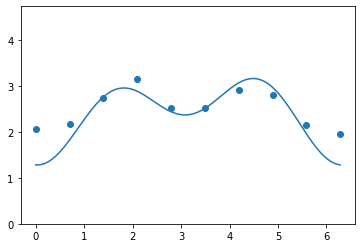

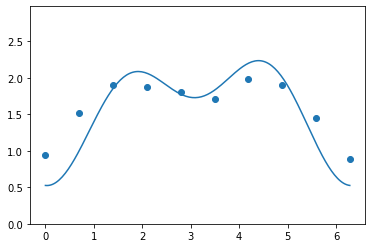

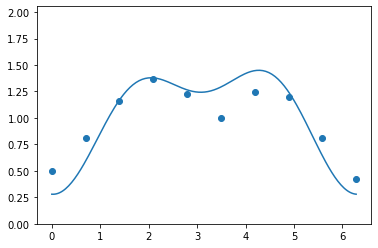

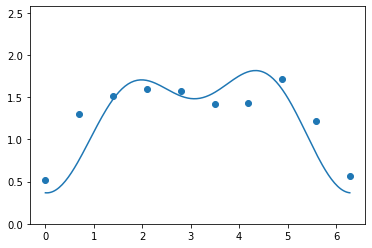

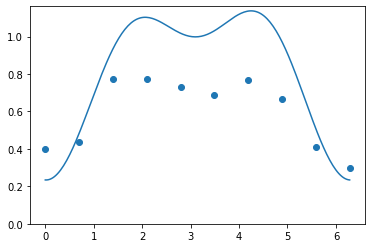

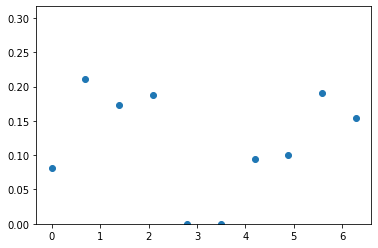

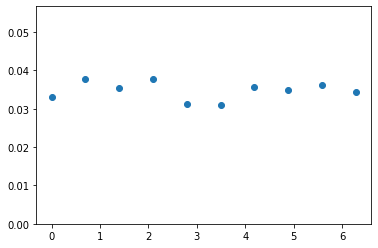

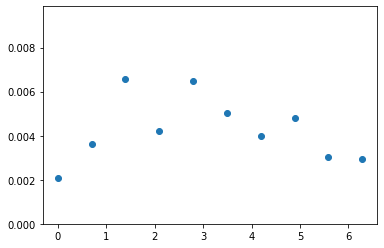

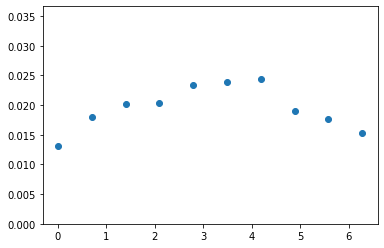

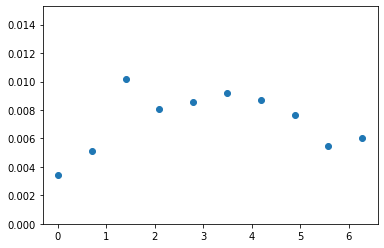

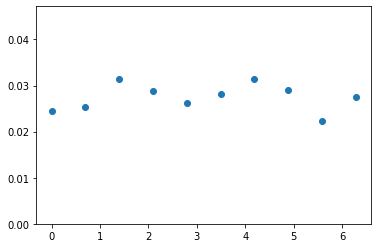

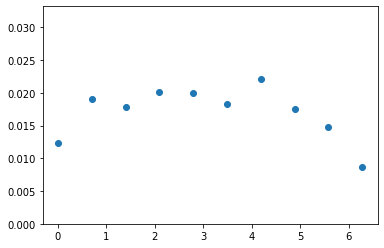

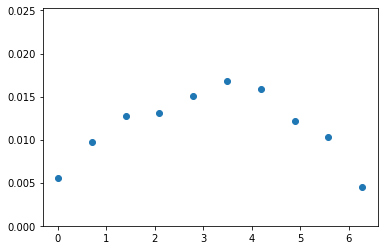

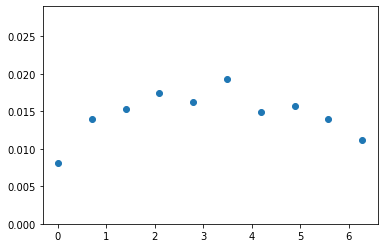

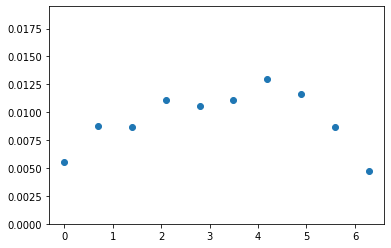

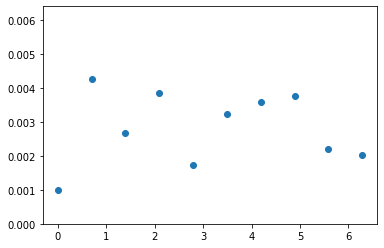

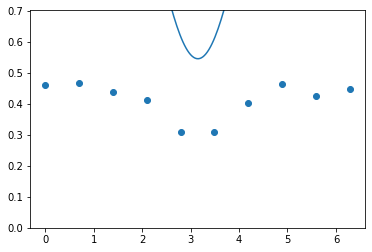

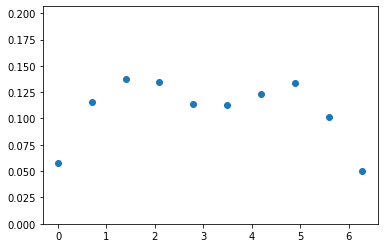

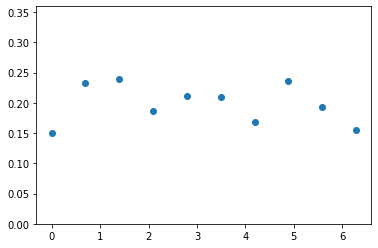

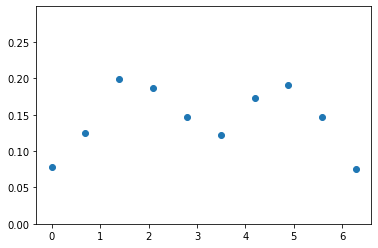

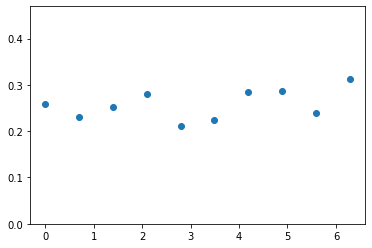

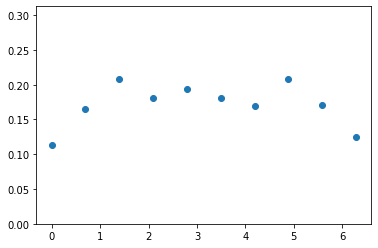

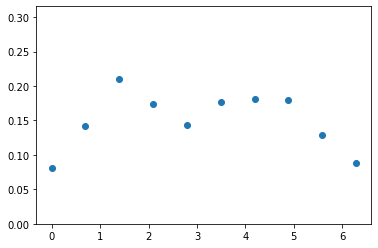

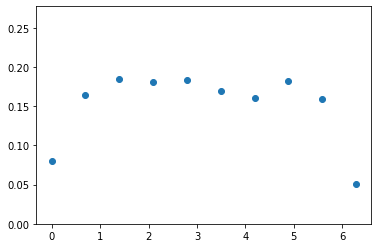

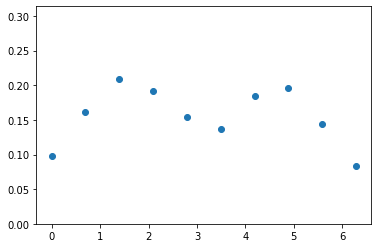

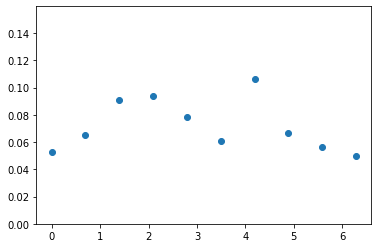

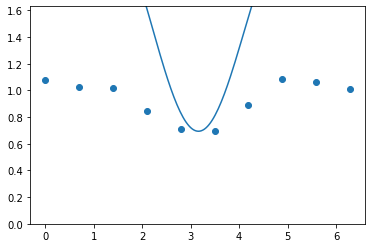

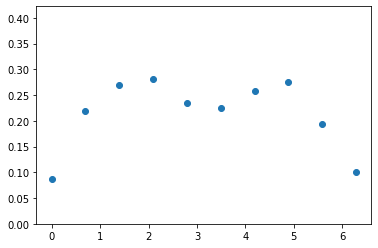

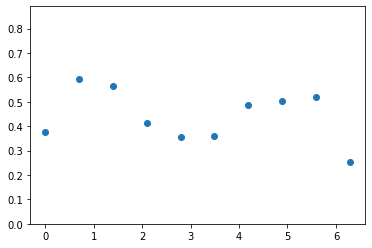

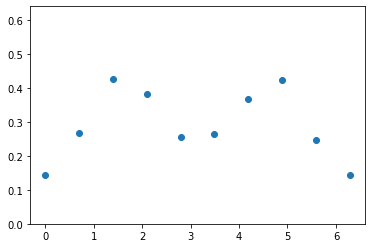

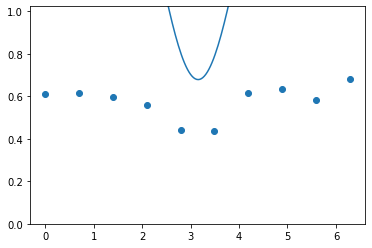

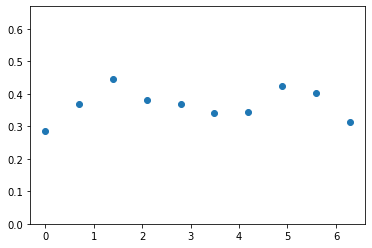

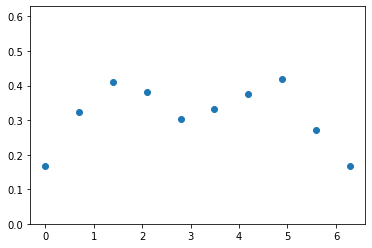

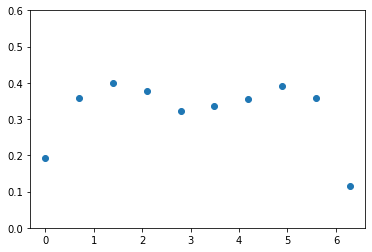

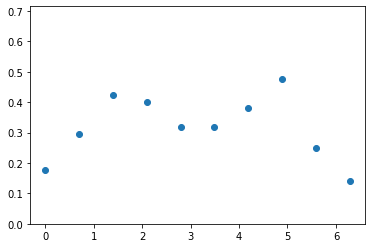

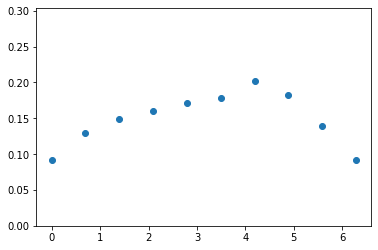

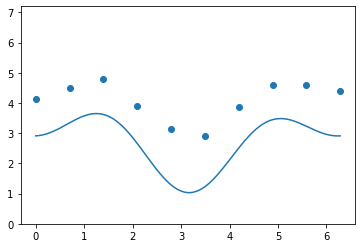

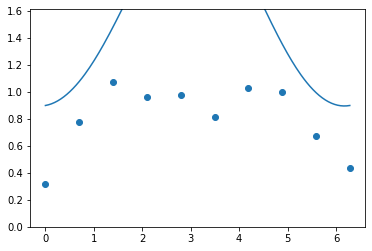

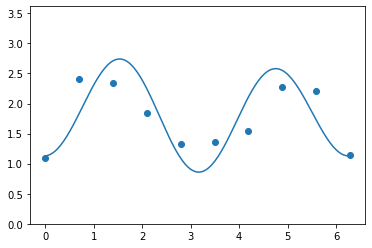

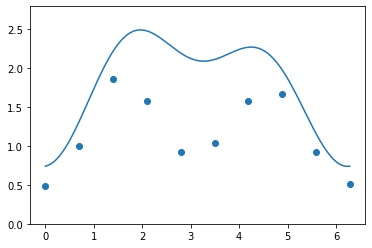

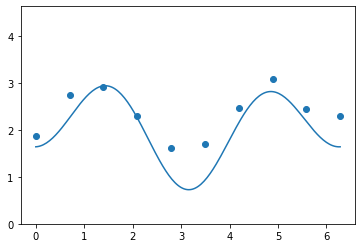

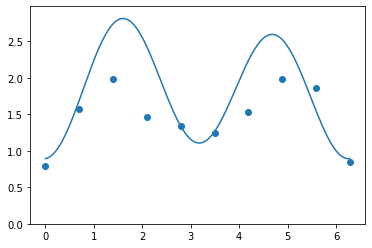

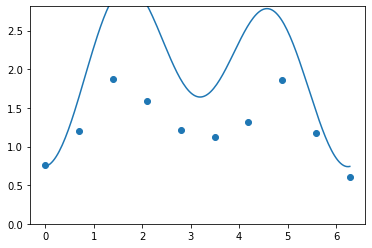

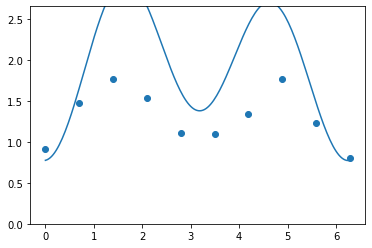

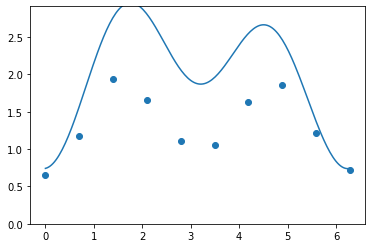

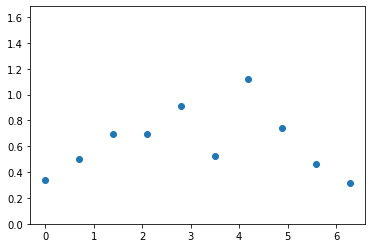

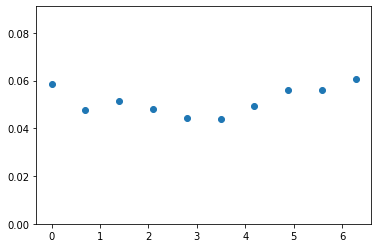

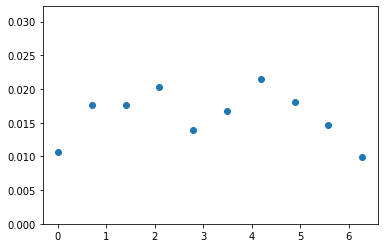

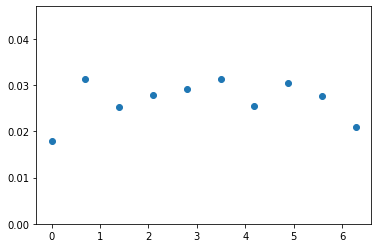

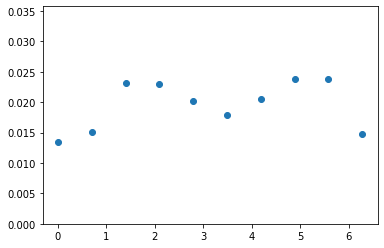

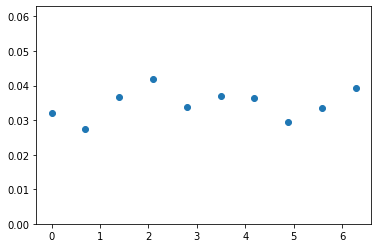

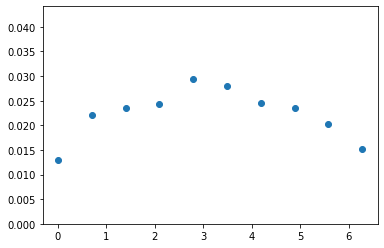

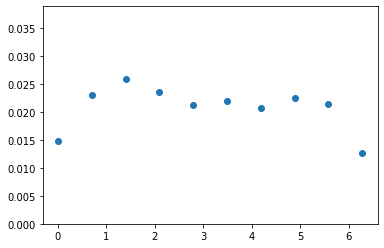

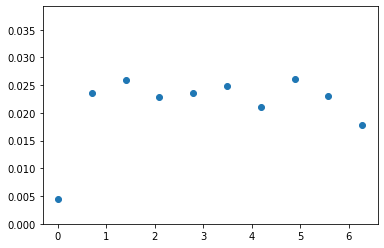

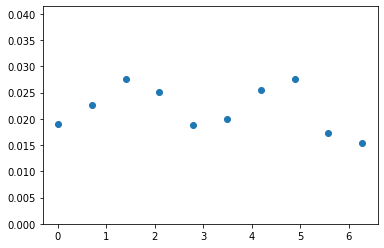

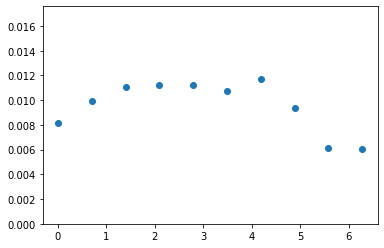

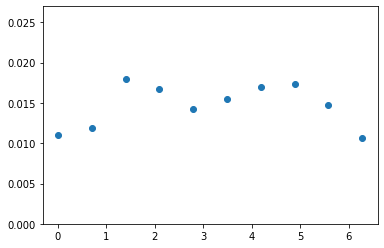

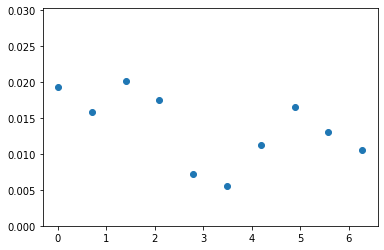

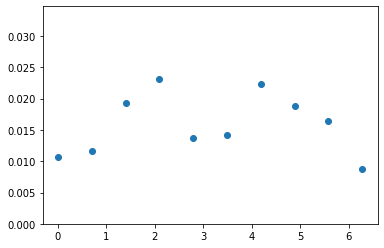

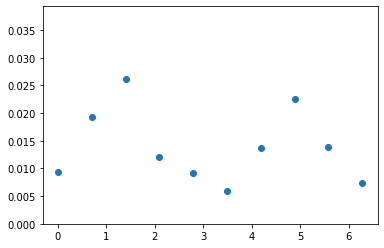

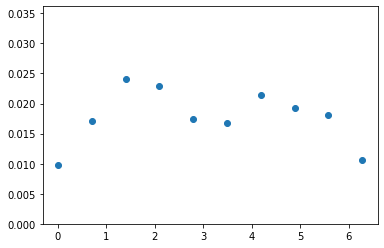

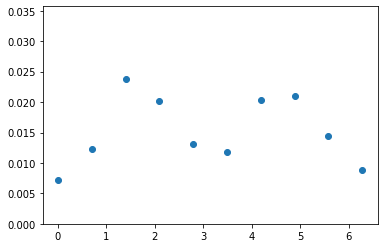

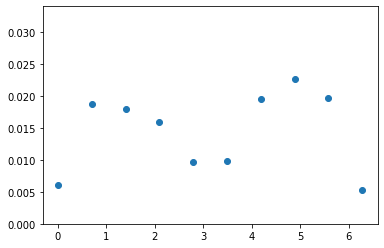

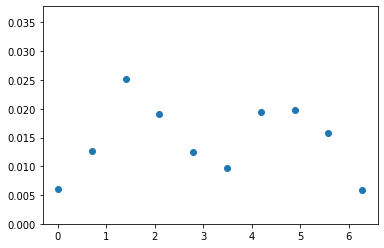

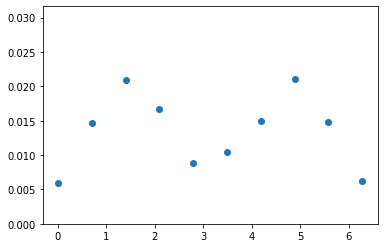

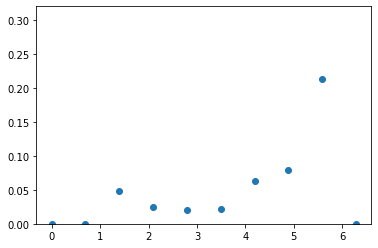

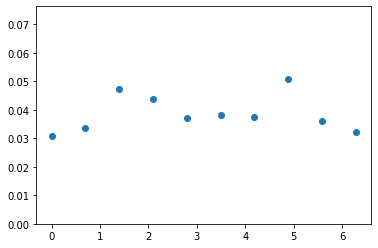

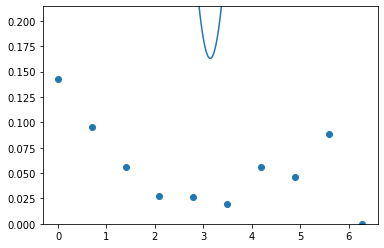

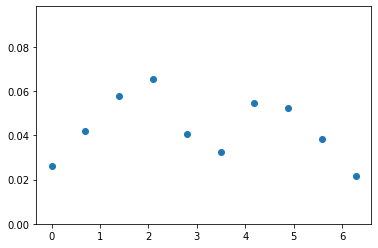

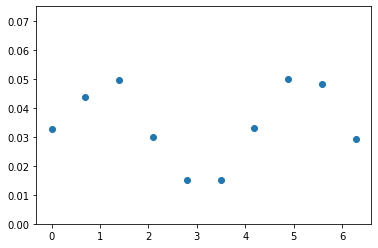

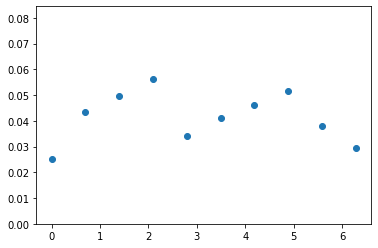

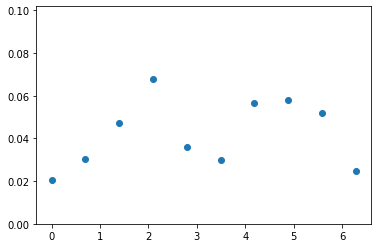

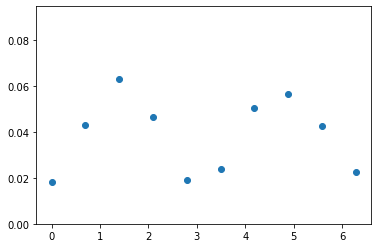

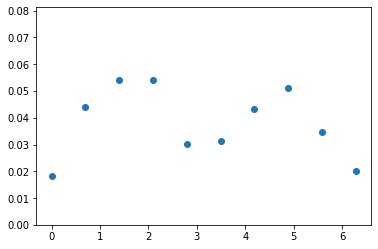

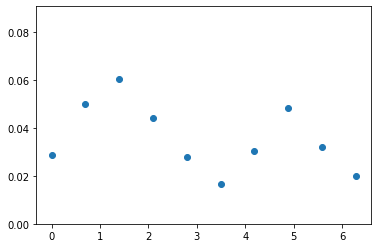

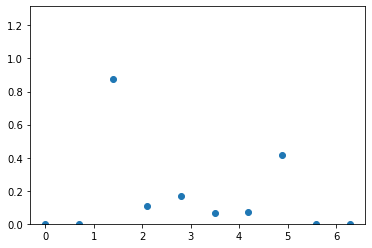

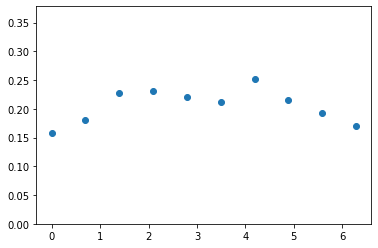

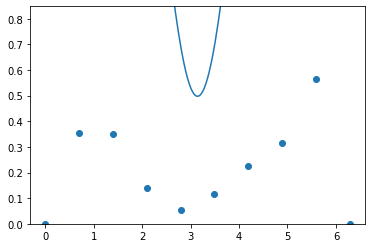

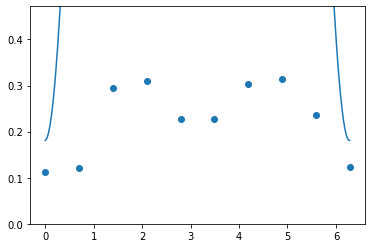

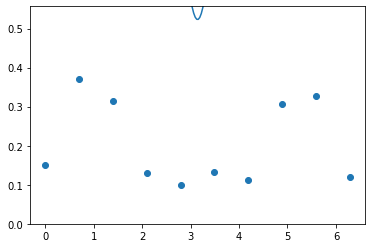

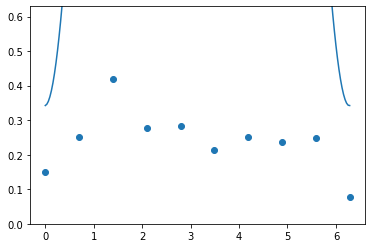

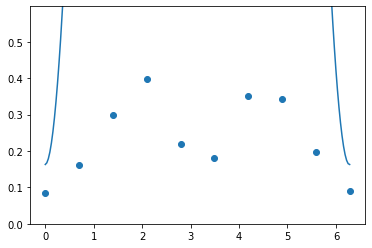

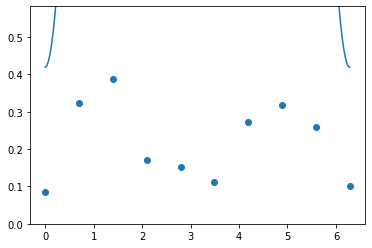

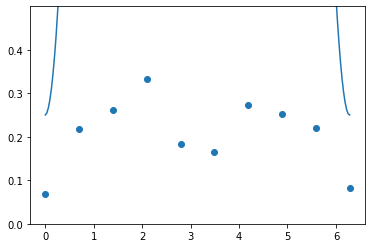

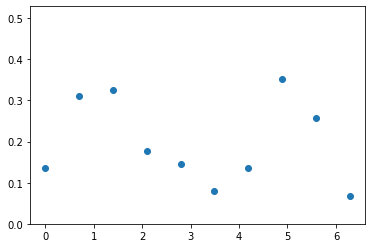

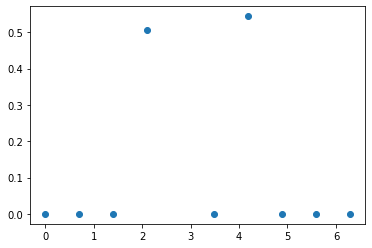

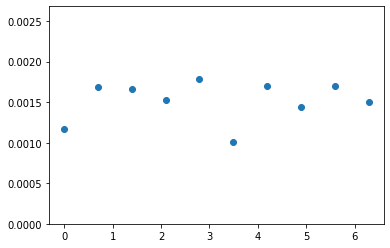

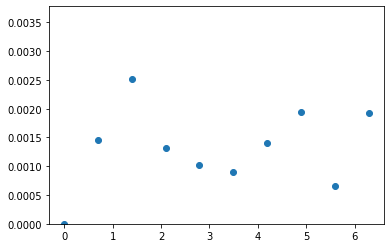

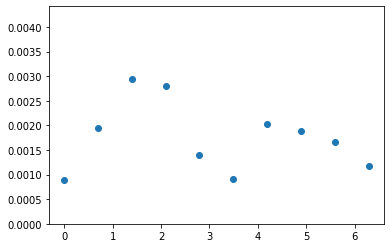

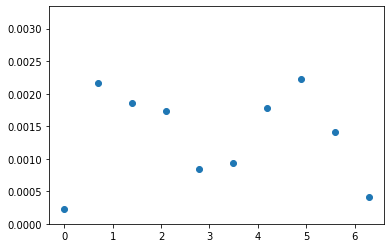

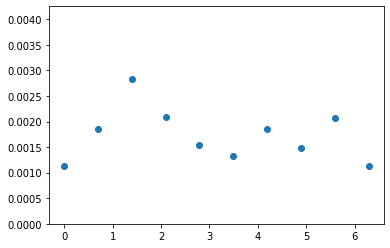

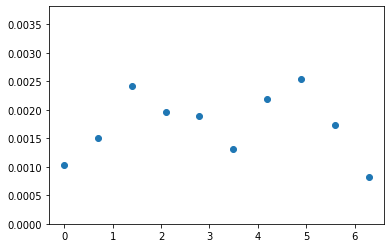

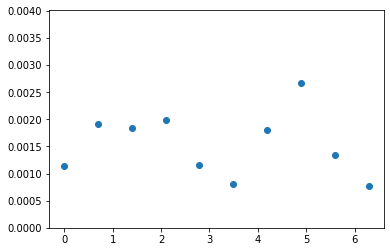

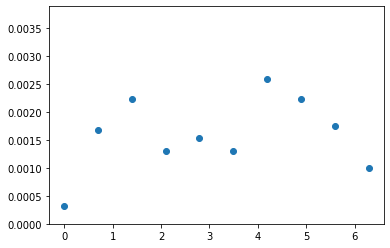

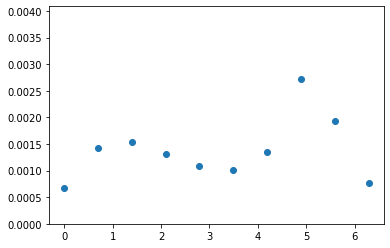

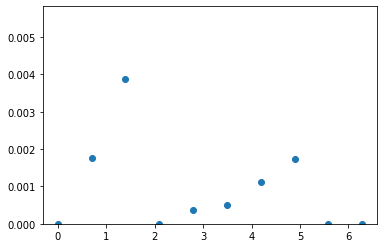

In [7]:
acceptence_corrected(df)

In [8]:
# for ws in w_bins:
#     for q2s in q2_bins:
#         for cos_ts in np.linspace(-1.0,1.0, 200):
#             crossSections = []
#             phis = []
#             for phi in np.linspace(0, 2 * np.pi, 200):
#                 crossSections.append(maid(4.81726, ws.left, q2s.left, cos_ts, np.degrees(phi)))
#                 phis.append(phi)
                
#             plt.scatter(phis,crossSections)
#             plt.show()
            